In [1]:
import numpy as np 
import pandas as pd 
import os

import cv2
from sklearn.model_selection import train_test_split
from sklearn import datasets

from torch.backends import cudnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import torchvision as tv
from torch.utils.data import TensorDataset,DataLoader

import torchvision
import torchvision.datasets as Dataset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import copy
import torchvision as tv
import cv2
from torch.utils.data import random_split
import pandas as pd
import os
from torch.utils.data import TensorDataset

import skimage.io as io
from tqdm import tqdm
from tensorboardX import SummaryWriter
from copy import deepcopy
import time

import sys

import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.optim.sgd import SGD
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from collections import Counter
from sklearn.metrics import f1_score,precision_score,recall_score
class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """
 
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)
 
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
 
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
 
    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)
 
    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)


In [2]:
sub_ids = pd.read_csv('../state-farm-distracted-driver-detection/driver_imgs_list.csv')
s = sub_ids['subject'].values.tolist()
c = sub_ids['classname'].values.tolist()
imgs = sub_ids['img'].values.tolist()
sub_dics = {}
for i in range(len(s)):
    temps = s[i]
    tempc = c[i]
    tempimgs = imgs[i]
    sub_dics[tempc+'/'+tempimgs] = temps
    '''if temps not in sub_dics:
        sub_dics[temps] = [tempc+'/'+tempimgs]
    else:
        sub_dics[temps].append(tempc+'/'+tempimgs)'''
train_annos = pd.read_csv('../state-farm-annos/train_list_d_01.csv')
train_images = train_annos['img'].values.tolist()
train_cates = train_annos['classname'].values.tolist()
train_paths = [train_cates[i]+'/'+train_images[i] for i in range(len(train_images))]

test_annos = pd.read_csv('../state-farm-annos/val_list_d_01.csv')
test_images = test_annos['img'].values.tolist()
test_cates = test_annos['classname'].values.tolist()
test_paths = [test_cates[i]+'/'+test_images[i] for i in range(len(test_images))]

globalpath = '../state-farm-distracted-driver-detection/imgs/train'
filepath = ['/c0','/c1','/c2','/c3','/c4','/c5','/c6','/c7','/c8','/c9']

trainset = []
validset = []
for label,f in enumerate(filepath):
    print(label,f)
    imgs = globalpath + f
    for dirname, _, filenames in os.walk(imgs):
        for filename in filenames:
            temppath = os.path.join(dirname, filename)
            im_o = Image.open(temppath)
            im_o = transforms.Resize([224,224])(im_o)

            anno = f + '/' +filename
            anno = anno[1:]
            if anno in train_paths:
                trainset.append([im_o,label,sub_dics[anno]])
            if anno in test_paths:
                validset.append([im_o,label,sub_dics[anno]])

        print(len(trainset),len(validset))
print('处理完成')
train_len = len(trainset)
valid_len = len(validset)
train_all = train_len

train_subs = []
for t in trainset:
    if t[2] not in train_subs:
        train_subs.append(t[2])
print(train_subs)

len_train_subs = len(train_subs)
train_sub_ids = {}
for i in range(len(train_subs)):
    train_sub_ids[train_subs[i]] = i
    

    
trainset2 = []
for t in trainset:
    trainset2.append([t[0],t[1],train_sub_ids[t[2]]])
trainset = trainset2

0 /c0

1766 723

1 /c1

3389 1367

2 /c2

5038 2035

3 /c3

6684 2735

4 /c4

8307 3438

5 /c5

9921 4136

6 /c6

11570 4812

7 /c7

12953 5431

8 /c8

14336 5959

9 /c9

15899 6525

处理完成

['p021', 'p081', 'p051', 'p061', 'p042', 'p024', 'p015', 'p014', 'p016', 'p064', 'p049', 'p022', 'p056', 'p052', 'p066', 'p039', 'p072', 'p047']


In [3]:
class MSFIN(nn.Module):
    def __init__(self,path):
        super(MSFIN,self).__init__()
        
        model = models.mobilenet_v2(pretrained=True)
        
        
        self.features = model.features
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        dim = 160



        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=10, bias=True)
        )
        
        self.classifier_d = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=len_train_subs, bias=True)
        )
        

        self.classifier_b = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=10, bias=True)
        )
        
        self.gate1 = nn.Parameter(torch.ones(1280)+1)
        self.gate2 = nn.Parameter(torch.ones(7,7)+1)
        
    def getGAP(self,f):
        return self.avgpool(f).squeeze(-1).squeeze(-1)
    def getBehaviorPreds(self,f):
        f = self.getGAP(f)
        pred = self.classifier_b(f)
        return pred
    def getIDPreds(self,f):
        f = self.getGAP(f)
        pred = self.classifier_d(f)
        return pred
    def forward_visual(self,x,is_warming = True):
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.classifier(avgf)

        gate1 = f.mean(1).unsqueeze(1)  * self.gate1.unsqueeze(-1).unsqueeze(-1)
        gate2 = (f.sum(-1).sum(-1)/49).unsqueeze(-1).unsqueeze(-1) * self.gate2.unsqueeze(0)
        gate1 = nn.Sigmoid()(gate1)
        gate2 = nn.Sigmoid()(gate2)
        gate = gate1 * gate2
        
        f_driver = f * gate

        f_behavior = f * (1-gate)
        
        preds1 = self.getIDPreds(f_driver) #Identifying drivers using f_id
        preds2 = self.getIDPreds(f_behavior) #The classifier is confused when identifying drivers using f_b.

        preds3 = self.getBehaviorPreds(f_behavior) #Recognizing driver behavior using f_b.
        preds4 = self.getBehaviorPreds(f_driver) #The classifier is confused when recognizing driver behavior using f_id.


        return f,'gate1','gate2',f_driver,f_behavior,preds1,preds2,preds3,preds4,preds
    def forward(self,x,is_warming = True):
        f = self.features(x)
        
        avgf = self.getGAP(f)
        preds = self.classifier(avgf)

        
        gate1 = f.mean(1).unsqueeze(1)  * self.gate1.unsqueeze(-1).unsqueeze(-1)
        gate2 = (f.sum(-1).sum(-1)/49).unsqueeze(-1).unsqueeze(-1) * self.gate2.unsqueeze(0)
        gate1 = nn.Sigmoid()(gate1)
        gate2 = nn.Sigmoid()(gate2)
        gate = gate1 * gate2
        
        f_driver = f * gate

        f_behavior = f * (1-gate)
        
        preds1 = self.getIDPreds(f_driver) #Identifying drivers using f_id
        preds2 = self.getIDPreds(f_behavior) #The classifier is confused when identifying drivers using f_b.

        preds3 = self.getBehaviorPreds(f_behavior) #Recognizing driver behavior using f_b.
        preds4 = self.getBehaviorPreds(f_driver) #The classifier is confused when recognizing driver behavior using f_id.


        return preds,preds1,preds2,preds3,preds4

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth

100%|██████████| 13.6M/13.6M [00:00<00:00, 74.3MB/s]

  0%|          | 0/200 [00:00<?, ?it/s]

***训练集***

main branch： 0.10875

准确识别驾驶员： 0.10125

无法准确识别驾驶员： 0.0975

准确识别行为： 0.115

无法准确识别行为： 0.10625

flag1 0.10125 flag2 0.115


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  0%|          | 1/200 [00:19<1:03:30, 19.15s/it]

valid-f1: 0.03938886465845577

valid-precision: 0.09131368330311536

valid-recall: 0.11389548722174134

process: 1  loss: 186.95021057128906  train_correct: 0.0 valid_loss 467.57055830955505  val_correct: 0.12183908045977011

The model has been saved!!

The best val_acc is  0.12183908045977011

***训练集***

main branch： 0.16375

准确识别驾驶员： 0.28875

无法准确识别驾驶员： 0.215

准确识别行为： 0.14

无法准确识别行为： 0.14125

flag1 0.28875 flag2 0.14


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 2/200 [00:33<53:08, 16.10s/it]  

valid-f1: 0.08354543321590427

valid-precision: 0.10822574900575

valid-recall: 0.16791423973347458

process: 2  loss: 177.48627090454102  train_correct: 0.0 valid_loss 466.761191368103  val_correct: 0.17164750957854405

The model has been saved!!

The best val_acc is  0.17164750957854405

***训练集***

main branch： 0.21375

准确识别驾驶员： 0.645

无法准确识别驾驶员： 0.29625

准确识别行为： 0.12875

无法准确识别行为： 0.145

flag1 0.645 flag2 0.12875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 3/200 [00:46<49:00, 14.93s/it]

valid-f1: 0.08367896461875741

valid-precision: 0.09581263245836855

valid-recall: 0.10744203306729698

process: 3  loss: 148.91225671768188  train_correct: 0.0 valid_loss 467.78820419311523  val_correct: 0.1081992337164751

***训练集***

main branch： 0.25125

准确识别驾驶员： 0.8575

无法准确识别驾驶员： 0.41375

准确识别行为： 0.13625

无法准确识别行为： 0.155

flag1 0.8575 flag2 0.13625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 4/200 [01:00<47:11, 14.44s/it]

valid-f1: 0.07672115505697616

valid-precision: 0.08038533230178091

valid-recall: 0.17280919197027647

process: 4  loss: 124.82556962966919  train_correct: 0.0 valid_loss 464.454158782959  val_correct: 0.18559386973180075

The model has been saved!!

The best val_acc is  0.18559386973180075

***训练集***

main branch： 0.36

准确识别驾驶员： 0.89375

无法准确识别驾驶员： 0.53125

准确识别行为： 0.1825

无法准确识别行为： 0.21125

flag1 0.89375 flag2 0.1825


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▎         | 5/200 [01:13<45:38, 14.05s/it]

valid-f1: 0.029814389853670666

valid-precision: 0.06509903729113643

valid-recall: 0.10568862275449102

process: 5  loss: 112.82343006134033  train_correct: 0.0 valid_loss 464.43263602256775  val_correct: 0.11279693486590038

***训练集***

main branch： 0.4775

准确识别驾驶员： 0.90875

无法准确识别驾驶员： 0.58

准确识别行为： 0.18125

无法准确识别行为： 0.2225

flag1 0.90875 flag2 0.18125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 6/200 [01:27<44:38, 13.81s/it]

valid-f1: 0.18185072403061484

valid-precision: 0.3244620977077425

valid-recall: 0.2671178043011618

process: 6  loss: 104.60143542289734  train_correct: 0.0 valid_loss 455.25951981544495  val_correct: 0.258544061302682

The model has been saved!!

The best val_acc is  0.258544061302682

***训练集***

main branch： 0.565

准确识别驾驶员： 0.93375

无法准确识别驾驶员： 0.7425

准确识别行为： 0.23875

无法准确识别行为： 0.34125

flag1 0.93375 flag2 0.23875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 7/200 [01:40<44:32, 13.85s/it]

valid-f1: 0.23847692637749188

valid-precision: 0.3685756327076724

valid-recall: 0.28988797903024865

process: 7  loss: 92.7665662765503  train_correct: 0.0 valid_loss 441.93029391765594  val_correct: 0.2875095785440613

The model has been saved!!

The best val_acc is  0.2875095785440613

***训练集***

main branch： 0.6425

准确识别驾驶员： 0.94125

无法准确识别驾驶员： 0.82

准确识别行为： 0.37375

无法准确识别行为： 0.435

flag1 0.94125 flag2 0.37375


  4%|▍         | 8/200 [01:54<44:03, 13.77s/it]

valid-f1: 0.38946676715486606

valid-precision: 0.5566107260209996

valid-recall: 0.4612548947510148

process: 8  loss: 86.56837224960327  train_correct: 0.0 valid_loss 406.81995153427124  val_correct: 0.47662835249042146

The model has been saved!!

The best val_acc is  0.47662835249042146

***训练集***

main branch： 0.6425

准确识别驾驶员： 0.91625

无法准确识别驾驶员： 0.84125

准确识别行为： 0.47625

无法准确识别行为： 0.51125

flag1 0.91625 flag2 0.47625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 9/200 [02:08<43:57, 13.81s/it]

valid-f1: 0.5817409799242148

valid-precision: 0.6533774548843585

valid-recall: 0.632280408436855

process: 9  loss: 83.91417813301086  train_correct: 0.0 valid_loss 375.89416551589966  val_correct: 0.6530268199233716

The model has been saved!!

The best val_acc is  0.6530268199233716

***训练集***

main branch： 0.6825

准确识别驾驶员： 0.94875

无法准确识别驾驶员： 0.905

准确识别行为： 0.565

无法准确识别行为： 0.5875

flag1 0.94875 flag2 0.565


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 10/200 [02:22<43:29, 13.73s/it]

valid-f1: 0.6622010703192827

valid-precision: 0.7162317103257505

valid-recall: 0.7130556141586886

process: 10  loss: 73.52894759178162  train_correct: 0.0 valid_loss 289.99817526340485  val_correct: 0.7388505747126437

The model has been saved!!

The best val_acc is  0.7388505747126437

***训练集***

main branch： 0.7175

准确识别驾驶员： 0.9475

无法准确识别驾驶员： 0.92875

准确识别行为： 0.64625

无法准确识别行为： 0.6525

flag1 0.9475 flag2 0.64625


  6%|▌         | 11/200 [02:36<43:32, 13.82s/it]

valid-f1: 0.7564522772004862

valid-precision: 0.8007781800894774

valid-recall: 0.7695136095286292

process: 11  loss: 64.95012724399567  train_correct: 0.0 valid_loss 227.34877914190292  val_correct: 0.7829885057471264

The model has been saved!!

The best val_acc is  0.7829885057471264

***训练集***

main branch： 0.70875

准确识别驾驶员： 0.93

无法准确识别驾驶员： 0.91625

准确识别行为： 0.6825

无法准确识别行为： 0.69

flag1 0.93 flag2 0.6825


  6%|▌         | 12/200 [02:49<43:18, 13.82s/it]

valid-f1: 0.745803038813725

valid-precision: 0.8004704112644576

valid-recall: 0.7694491402732537

process: 12  loss: 59.405516266822815  train_correct: 0.0 valid_loss 189.53652146458626  val_correct: 0.7866666666666666

The model has been saved!!

The best val_acc is  0.7866666666666666

***训练集***

main branch： 0.7425

准确识别驾驶员： 0.93375

无法准确识别驾驶员： 0.9025

准确识别行为： 0.72625

无法准确识别行为： 0.70875

flag1 0.93375 flag2 0.72625


  6%|▋         | 13/200 [03:03<43:04, 13.82s/it]

valid-f1: 0.7694303920993363

valid-precision: 0.8039959193929935

valid-recall: 0.7759234404390907

process: 13  loss: 55.938464879989624  train_correct: 0.0 valid_loss 169.75229373574257  val_correct: 0.7869731800766283

The model has been saved!!

The best val_acc is  0.7869731800766283

***训练集***

main branch： 0.77

准确识别驾驶员： 0.93

无法准确识别驾驶员： 0.89875

准确识别行为： 0.77

无法准确识别行为： 0.7625

flag1 0.93 flag2 0.77


  7%|▋         | 14/200 [03:17<43:03, 13.89s/it]

valid-f1: 0.7689780809503853

valid-precision: 0.7938118139241952

valid-recall: 0.7829503271783879

process: 14  loss: 46.20371127128601  train_correct: 0.0 valid_loss 143.74864855408669  val_correct: 0.7989272030651341

The model has been saved!!

The best val_acc is  0.7989272030651341

***训练集***

main branch： 0.7525

准确识别驾驶员： 0.9275

无法准确识别驾驶员： 0.88

准确识别行为： 0.75375

无法准确识别行为： 0.7475

flag1 0.9275 flag2 0.75375


  8%|▊         | 15/200 [03:31<42:41, 13.85s/it]

valid-f1: 0.7539100257736763

valid-precision: 0.8030511142222894

valid-recall: 0.7601923998218115

process: 15  loss: 47.10304009914398  train_correct: 0.0 valid_loss 146.45406460016966  val_correct: 0.778544061302682

***训练集***

main branch： 0.77

准确识别驾驶员： 0.94

无法准确识别驾驶员： 0.90125

准确识别行为： 0.77

无法准确识别行为： 0.7625

flag1 0.94 flag2 0.77


  8%|▊         | 16/200 [03:45<42:34, 13.88s/it]

valid-f1: 0.8157022988401792

valid-precision: 0.8367788684229553

valid-recall: 0.8182273152156958

process: 16  loss: 43.640706300735474  train_correct: 0.0 valid_loss 120.13062353432178  val_correct: 0.8327969348659003

The model has been saved!!

The best val_acc is  0.8327969348659003

***训练集***

main branch： 0.79875

准确识别驾驶员： 0.95625

无法准确识别驾驶员： 0.92

准确识别行为： 0.77625

无法准确识别行为： 0.77875

flag1 0.95625 flag2 0.77625


  8%|▊         | 17/200 [03:59<42:11, 13.84s/it]

valid-f1: 0.8571703529220857

valid-precision: 0.8707879299151668

valid-recall: 0.8557257538475099

process: 17  loss: 40.282665848731995  train_correct: 0.0 valid_loss 99.20096863806248  val_correct: 0.8632950191570882

The model has been saved!!

The best val_acc is  0.8632950191570882

***训练集***

main branch： 0.73875

准确识别驾驶员： 0.9475

无法准确识别驾驶员： 0.91875

准确识别行为： 0.74625

无法准确识别行为： 0.74125

flag1 0.9475 flag2 0.74625


  9%|▉         | 18/200 [04:13<42:03, 13.86s/it]

valid-f1: 0.8727712436881536

valid-precision: 0.8789551854257729

valid-recall: 0.8719011123250235

process: 18  loss: 43.0410943031311  train_correct: 0.0 valid_loss 93.73791555315256  val_correct: 0.8807662835249043

The model has been saved!!

The best val_acc is  0.8807662835249043

***训练集***

main branch： 0.785

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.92625

准确识别行为： 0.78125

无法准确识别行为： 0.77875

flag1 0.9575 flag2 0.78125


 10%|▉         | 19/200 [04:26<41:26, 13.74s/it]

valid-f1: 0.8690502557428221

valid-precision: 0.8719213274123554

valid-recall: 0.8697630003395425

process: 19  loss: 36.51250022649765  train_correct: 0.0 valid_loss 90.46600529178977  val_correct: 0.8786206896551724

***训练集***

main branch： 0.7825

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.92125

准确识别行为： 0.7875

无法准确识别行为： 0.79125

flag1 0.9575 flag2 0.7875


 10%|█         | 20/200 [04:40<41:30, 13.83s/it]

valid-f1: 0.851892197515375

valid-precision: 0.8712778712847637

valid-recall: 0.8529750014659541

process: 20  loss: 36.87599462270737  train_correct: 0.0 valid_loss 104.52648952975869  val_correct: 0.8662068965517241

***训练集***

main branch： 0.775

准确识别驾驶员： 0.945

无法准确识别驾驶员： 0.9225

准确识别行为： 0.775

无法准确识别行为： 0.7775

flag1 0.945 flag2 0.775


 10%|█         | 21/200 [04:53<40:50, 13.69s/it]

valid-f1: 0.8586067634300999

valid-precision: 0.8720571438465987

valid-recall: 0.8581773877393367

process: 21  loss: 37.913045942783356  train_correct: 0.0 valid_loss 91.47594232298434  val_correct: 0.8700383141762452

***训练集***

main branch： 0.82

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.93625

准确识别行为： 0.8275

无法准确识别行为： 0.82

flag1 0.965 flag2 0.8275


 11%|█         | 22/200 [05:07<40:19, 13.60s/it]

valid-f1: 0.8609002906622445

valid-precision: 0.8679305372959417

valid-recall: 0.8634795763479375

process: 22  loss: 31.60434716939926  train_correct: 0.0 valid_loss 97.5679741166532  val_correct: 0.873256704980843

***训练集***

main branch： 0.7975

准确识别驾驶员： 0.955

无法准确识别驾驶员： 0.92375

准确识别行为： 0.8

无法准确识别行为： 0.79375

flag1 0.955 flag2 0.8


 12%|█▏        | 23/200 [05:21<40:17, 13.66s/it]

valid-f1: 0.8395864547327185

valid-precision: 0.8511831566967965

valid-recall: 0.8414555729142739

process: 23  loss: 35.03440570831299  train_correct: 0.0 valid_loss 101.6772278714925  val_correct: 0.8504214559386973

***训练集***

main branch： 0.8175

准确识别驾驶员： 0.9525

无法准确识别驾驶员： 0.93625

准确识别行为： 0.82375

无法准确识别行为： 0.82375

flag1 0.9525 flag2 0.82375


 12%|█▏        | 24/200 [05:34<40:00, 13.64s/it]

valid-f1: 0.8684004200356572

valid-precision: 0.8823773700515568

valid-recall: 0.8694962059779854

process: 24  loss: 30.523136138916016  train_correct: 0.0 valid_loss 84.63183907419443  val_correct: 0.8812260536398467

The model has been saved!!

The best val_acc is  0.8812260536398467

***训练集***

main branch： 0.83625

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.94625

准确识别行为： 0.82125

无法准确识别行为： 0.81875

flag1 0.965 flag2 0.82125


 12%|█▎        | 25/200 [05:48<39:54, 13.68s/it]

valid-f1: 0.884091016250524

valid-precision: 0.8862961917130796

valid-recall: 0.8837361201795091

process: 25  loss: 30.863023042678833  train_correct: 0.0 valid_loss 76.39830163493752  val_correct: 0.8911877394636015

The model has been saved!!

The best val_acc is  0.8911877394636015

***训练集***

main branch： 0.81375

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.9525

准确识别行为： 0.81625

无法准确识别行为： 0.8125

flag1 0.96 flag2 0.81625


 13%|█▎        | 26/200 [06:02<39:32, 13.64s/it]

valid-f1: 0.8507979139846185

valid-precision: 0.8621981697531904

valid-recall: 0.8533308148992514

process: 26  loss: 30.85097086429596  train_correct: 0.0 valid_loss 93.63871784135699  val_correct: 0.8617624521072796

***训练集***

main branch： 0.80375

准确识别驾驶员： 0.95125

无法准确识别驾驶员： 0.91875

准确识别行为： 0.8

无法准确识别行为： 0.80625

flag1 0.95125 flag2 0.8


 14%|█▎        | 27/200 [06:15<39:17, 13.62s/it]

valid-f1: 0.8766362863090306

valid-precision: 0.8844130002959055

valid-recall: 0.8791009491905939

process: 27  loss: 33.760819256305695  train_correct: 0.0 valid_loss 80.48855472356081  val_correct: 0.8872030651340996

***训练集***

main branch： 0.81

准确识别驾驶员： 0.955

无法准确识别驾驶员： 0.92875

准确识别行为： 0.81

无法准确识别行为： 0.8075

flag1 0.955 flag2 0.81


 14%|█▍        | 28/200 [06:29<39:03, 13.62s/it]

valid-f1: 0.8494227665495805

valid-precision: 0.8594274764858192

valid-recall: 0.8506160019091901

process: 28  loss: 33.51685440540314  train_correct: 0.0 valid_loss 102.24594789557159  val_correct: 0.856551724137931

***训练集***

main branch： 0.80875

准确识别驾驶员： 0.94125

无法准确识别驾驶员： 0.91125

准确识别行为： 0.82375

无法准确识别行为： 0.8125

flag1 0.94125 flag2 0.82375


 14%|█▍        | 29/200 [06:42<38:55, 13.66s/it]

valid-f1: 0.8891427103883192

valid-precision: 0.8943130434661459

valid-recall: 0.8897394310615704

process: 29  loss: 34.36026906967163  train_correct: 0.0 valid_loss 69.41109483875334  val_correct: 0.8963984674329502

The model has been saved!!

The best val_acc is  0.8963984674329502

***训练集***

main branch： 0.8325

准确识别驾驶员： 0.955

无法准确识别驾驶员： 0.92125

准确识别行为： 0.83875

无法准确识别行为： 0.8275

flag1 0.955 flag2 0.83875


 15%|█▌        | 30/200 [06:56<38:56, 13.74s/it]

valid-f1: 0.8586251811380243

valid-precision: 0.8793972507523105

valid-recall: 0.857426211447063

process: 30  loss: 30.435037910938263  train_correct: 0.0 valid_loss 87.6290381103754  val_correct: 0.8659003831417624

***训练集***

main branch： 0.8075

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.94

准确识别行为： 0.82375

无法准确识别行为： 0.8125

flag1 0.96 flag2 0.82375


 16%|█▌        | 31/200 [07:10<38:44, 13.76s/it]

valid-f1: 0.8613806879860881

valid-precision: 0.8707962126385457

valid-recall: 0.8601387757843588

process: 31  loss: 30.855206668376923  train_correct: 0.0 valid_loss 87.26825445331633  val_correct: 0.8645210727969349

***训练集***

main branch： 0.815

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.945

准确识别行为： 0.81375

无法准确识别行为： 0.8075

flag1 0.96875 flag2 0.81375


 16%|█▌        | 32/200 [07:24<38:51, 13.88s/it]

valid-f1: 0.871076023737104

valid-precision: 0.8833118778349766

valid-recall: 0.8742029000853266

process: 32  loss: 31.602577209472656  train_correct: 0.0 valid_loss 72.22956603765488  val_correct: 0.8784674329501916

***训练集***

main branch： 0.81625

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.96

准确识别行为： 0.845

无法准确识别行为： 0.83625

flag1 0.97 flag2 0.845


 16%|█▋        | 33/200 [07:38<38:40, 13.90s/it]

valid-f1: 0.8575637169903944

valid-precision: 0.8712110194972291

valid-recall: 0.855598504400145

process: 33  loss: 28.2163268327713  train_correct: 0.0 valid_loss 86.653409358114  val_correct: 0.8631417624521073

***训练集***

main branch： 0.85625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.95875

准确识别行为： 0.85375

无法准确识别行为： 0.8475

flag1 0.975 flag2 0.85375


 17%|█▋        | 34/200 [07:53<38:42, 13.99s/it]

valid-f1: 0.8786417009827272

valid-precision: 0.9057024771885883

valid-recall: 0.878612456236478

process: 34  loss: 24.6647070646286  train_correct: 0.0 valid_loss 76.65060904994607  val_correct: 0.8908812260536398

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.95125

准确识别行为： 0.85875

无法准确识别行为： 0.8625

flag1 0.96 flag2 0.85875


 18%|█▊        | 35/200 [08:06<38:09, 13.87s/it]

valid-f1: 0.850160916319

valid-precision: 0.8655380769003512

valid-recall: 0.850701890145643

process: 35  loss: 24.35587853193283  train_correct: 0.0 valid_loss 98.33779221773148  val_correct: 0.8588505747126437

***训练集***

main branch： 0.82125

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.94625

准确识别行为： 0.82875

无法准确识别行为： 0.83625

flag1 0.9725 flag2 0.82875


 18%|█▊        | 36/200 [08:20<37:54, 13.87s/it]

valid-f1: 0.870669924280681

valid-precision: 0.8831274888601536

valid-recall: 0.8695242848177669

process: 36  loss: 28.793623208999634  train_correct: 0.0 valid_loss 80.23003892507404  val_correct: 0.8792337164750957

***训练集***

main branch： 0.82125

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.96125

准确识别行为： 0.8275

无法准确识别行为： 0.83125

flag1 0.9725 flag2 0.8275


 18%|█▊        | 37/200 [08:34<37:42, 13.88s/it]

valid-f1: 0.8757840439871007

valid-precision: 0.8868951718943983

valid-recall: 0.8739293554197551

process: 37  loss: 29.029247879981995  train_correct: 0.0 valid_loss 72.1945839105174  val_correct: 0.8842911877394636

***训练集***

main branch： 0.82875

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.955

准确识别行为： 0.83875

无法准确识别行为： 0.84375

flag1 0.97125 flag2 0.83875


 19%|█▉        | 38/200 [08:48<37:20, 13.83s/it]

valid-f1: 0.8511815651105563

valid-precision: 0.8566486653465668

valid-recall: 0.8528589981506711

process: 38  loss: 29.18488445878029  train_correct: 0.0 valid_loss 94.17327465955168  val_correct: 0.8591570881226054

***训练集***

main branch： 0.84

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.94625

准确识别行为： 0.86

无法准确识别行为： 0.85125

flag1 0.97 flag2 0.86


 20%|█▉        | 39/200 [09:02<37:18, 13.90s/it]

valid-f1: 0.8910144554159574

valid-precision: 0.9008367925623565

valid-recall: 0.8887838886984628

process: 39  loss: 24.382643818855286  train_correct: 0.0 valid_loss 73.87385143898427  val_correct: 0.8973180076628352

The model has been saved!!

The best val_acc is  0.8973180076628352

***训练集***

main branch： 0.865

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.96125

准确识别行为： 0.87

无法准确识别行为： 0.875

flag1 0.9675 flag2 0.87


 20%|██        | 40/200 [09:15<36:44, 13.78s/it]

valid-f1: 0.8816740237181353

valid-precision: 0.9062182133779084

valid-recall: 0.8823363811821514

process: 40  loss: 23.074225932359695  train_correct: 0.0 valid_loss 78.22173640085384  val_correct: 0.8933333333333333

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.9725

准确识别行为： 0.8575

无法准确识别行为： 0.85

flag1 0.98125 flag2 0.8575


 20%|██        | 41/200 [09:29<36:27, 13.76s/it]

valid-f1: 0.8737288782673207

valid-precision: 0.8898213537101217

valid-recall: 0.8710440649603195

process: 41  loss: 23.942745327949524  train_correct: 0.0 valid_loss 85.51335035823286  val_correct: 0.8806130268199234

***训练集***

main branch： 0.84

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.945

准确识别行为： 0.84

无法准确识别行为： 0.8475

flag1 0.96 flag2 0.84


 21%|██        | 42/200 [09:42<36:05, 13.70s/it]

valid-f1: 0.8916454311439352

valid-precision: 0.9012653933629096

valid-recall: 0.8891918470142806

process: 42  loss: 28.05920574069023  train_correct: 0.0 valid_loss 77.86687510367483  val_correct: 0.8954789272030651

***训练集***

main branch： 0.875

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.95875

准确识别行为： 0.875

无法准确识别行为： 0.87625

flag1 0.9725 flag2 0.875


 22%|██▏       | 43/200 [09:56<35:50, 13.70s/it]

valid-f1: 0.888887989626727

valid-precision: 0.8950756243036398

valid-recall: 0.887216208039192

process: 43  loss: 22.143231838941574  train_correct: 0.0 valid_loss 77.41227776091546  val_correct: 0.894712643678161

***训练集***

main branch： 0.84

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.95375

准确识别行为： 0.85

无法准确识别行为： 0.855

flag1 0.97625 flag2 0.85


 22%|██▏       | 44/200 [10:10<35:36, 13.69s/it]

valid-f1: 0.8982775224604733

valid-precision: 0.9027385448928935

valid-recall: 0.8973106252277088

process: 44  loss: 26.290436387062073  train_correct: 0.0 valid_loss 64.91928259376436  val_correct: 0.9029885057471264

The model has been saved!!

The best val_acc is  0.9029885057471264

***训练集***

main branch： 0.8725

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.94375

准确识别行为： 0.88

无法准确识别行为： 0.8725

flag1 0.9675 flag2 0.88


 22%|██▎       | 45/200 [10:24<35:24, 13.71s/it]

valid-f1: 0.8876280754525793

valid-precision: 0.8927808512999833

valid-recall: 0.8871545992328009

process: 45  loss: 22.626016199588776  train_correct: 0.0 valid_loss 74.33174208458513  val_correct: 0.8916475095785441

***训练集***

main branch： 0.8425

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.96

准确识别行为： 0.86

无法准确识别行为： 0.845

flag1 0.9675 flag2 0.86


 23%|██▎       | 46/200 [10:38<35:30, 13.84s/it]

valid-f1: 0.9017232294459356

valid-precision: 0.907951741180212

valid-recall: 0.8997643673947382

process: 46  loss: 26.252341225743294  train_correct: 0.0 valid_loss 71.07480135909282  val_correct: 0.9068199233716475

The model has been saved!!

The best val_acc is  0.9068199233716475

***训练集***

main branch： 0.8575

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.96625

准确识别行为： 0.865

无法准确识别行为： 0.85

flag1 0.97375 flag2 0.865


 24%|██▎       | 47/200 [10:51<35:09, 13.79s/it]

valid-f1: 0.89941107553691

valid-precision: 0.9198008514376953

valid-recall: 0.8954558461416966

process: 47  loss: 22.488220304250717  train_correct: 0.0 valid_loss 72.11465315707028  val_correct: 0.9066666666666666

***训练集***

main branch： 0.8425

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.95375

准确识别行为： 0.855

无法准确识别行为： 0.855

flag1 0.96625 flag2 0.855


 24%|██▍       | 48/200 [11:05<35:07, 13.86s/it]

valid-f1: 0.8740450682203089

valid-precision: 0.8939272491993882

valid-recall: 0.87189134001142

process: 48  loss: 25.566262662410736  train_correct: 0.0 valid_loss 89.21109440503642  val_correct: 0.8812260536398467

***训练集***

main branch： 0.87125

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.96125

准确识别行为： 0.88

无法准确识别行为： 0.875

flag1 0.9725 flag2 0.88


 24%|██▍       | 49/200 [11:19<35:02, 13.93s/it]

valid-f1: 0.8940948923768524

valid-precision: 0.9076560805516642

valid-recall: 0.89356303652676

process: 49  loss: 21.400905191898346  train_correct: 0.0 valid_loss 74.18883401341736  val_correct: 0.9017624521072797

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.96375

准确识别行为： 0.88875

无法准确识别行为： 0.8925

flag1 0.98 flag2 0.88875


 25%|██▌       | 50/200 [11:34<35:00, 14.00s/it]

valid-f1: 0.9144350375043446

valid-precision: 0.9204060610632416

valid-recall: 0.9127406818482499

process: 50  loss: 19.544055342674255  train_correct: 0.0 valid_loss 60.56736267101951  val_correct: 0.9201532567049808

The model has been saved!!

The best val_acc is  0.9201532567049808

***训练集***

main branch： 0.84625

准确识别驾驶员： 0.94625

无法准确识别驾驶员： 0.93875

准确识别行为： 0.865

无法准确识别行为： 0.85375

flag1 0.94625 flag2 0.865


 26%|██▌       | 51/200 [11:48<34:41, 13.97s/it]

valid-f1: 0.8983433210874203

valid-precision: 0.9137160367029553

valid-recall: 0.8959382449049784

process: 51  loss: 25.005665987730026  train_correct: 0.0 valid_loss 72.66401960677467  val_correct: 0.9042145593869731

***训练集***

main branch： 0.83375

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.9725

准确识别行为： 0.84

无法准确识别行为： 0.83625

flag1 0.97625 flag2 0.84


 26%|██▌       | 52/200 [12:02<34:34, 14.01s/it]

valid-f1: 0.8745536458512355

valid-precision: 0.8988649987761825

valid-recall: 0.8705305588821096

process: 52  loss: 26.462131798267365  train_correct: 0.0 valid_loss 90.32304608961567  val_correct: 0.8824521072796935

***训练集***

main branch： 0.85625

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.965

准确识别行为： 0.86625

无法准确识别行为： 0.86875

flag1 0.97875 flag2 0.86625


 26%|██▋       | 53/200 [12:15<34:09, 13.94s/it]

valid-f1: 0.8389837389288699

valid-precision: 0.8777451975136688

valid-recall: 0.8345010910433969

process: 53  loss: 22.030388295650482  train_correct: 0.0 valid_loss 110.2717085601762  val_correct: 0.8427586206896551

***训练集***

main branch： 0.82625

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.94875

准确识别行为： 0.84125

无法准确识别行为： 0.8225

flag1 0.96375 flag2 0.84125


 27%|██▋       | 54/200 [12:29<33:45, 13.88s/it]

valid-f1: 0.851052946200889

valid-precision: 0.8725838071324462

valid-recall: 0.8456339756445302

process: 54  loss: 26.894136667251587  train_correct: 0.0 valid_loss 97.06595287006348  val_correct: 0.8547126436781609

***训练集***

main branch： 0.85875

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.97375

准确识别行为： 0.86375

无法准确识别行为： 0.855

flag1 0.9825 flag2 0.86375


 28%|██▊       | 55/200 [12:43<33:39, 13.93s/it]

valid-f1: 0.8902864779026938

valid-precision: 0.9117175368258066

valid-recall: 0.886798351197629

process: 55  loss: 23.212932497262955  train_correct: 0.0 valid_loss 76.79626522026956  val_correct: 0.896551724137931

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.95625

准确识别行为： 0.89375

无法准确识别行为： 0.88875

flag1 0.96875 flag2 0.89375


 28%|██▊       | 56/200 [12:57<33:21, 13.90s/it]

valid-f1: 0.8950981620392187

valid-precision: 0.906339557413218

valid-recall: 0.8920171447948638

process: 56  loss: 20.415776640176773  train_correct: 0.0 valid_loss 76.77496071346104  val_correct: 0.9005363984674329

***训练集***

main branch： 0.86375

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.955

准确识别行为： 0.86375

无法准确识别行为： 0.86375

flag1 0.9675 flag2 0.86375


 28%|██▊       | 57/200 [13:11<33:19, 13.98s/it]

valid-f1: 0.8982866143130387

valid-precision: 0.9075681751861252

valid-recall: 0.8951417680817141

process: 57  loss: 23.367445468902588  train_correct: 0.0 valid_loss 67.26718409033492  val_correct: 0.9000766283524905

***训练集***

main branch： 0.885

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.95375

准确识别行为： 0.89

无法准确识别行为： 0.88125

flag1 0.97625 flag2 0.89


 29%|██▉       | 58/200 [13:25<33:03, 13.96s/it]

valid-f1: 0.9157856393641595

valid-precision: 0.9184393233194615

valid-recall: 0.9146692319370551

process: 58  loss: 20.617865100502968  train_correct: 0.0 valid_loss 57.83481868635863  val_correct: 0.9203065134099617

The model has been saved!!

The best val_acc is  0.9203065134099617

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.95875

准确识别行为： 0.8825

无法准确识别行为： 0.8825

flag1 0.97 flag2 0.8825


 30%|██▉       | 59/200 [13:39<32:50, 13.98s/it]

valid-f1: 0.9006461993029756

valid-precision: 0.9055373666520043

valid-recall: 0.9001034371743023

process: 59  loss: 19.75346663594246  train_correct: 0.0 valid_loss 62.55885411752388  val_correct: 0.9063601532567049

***训练集***

main branch： 0.885

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.94875

准确识别行为： 0.88125

无法准确识别行为： 0.88625

flag1 0.96125 flag2 0.88125


 30%|███       | 60/200 [13:53<32:25, 13.90s/it]

valid-f1: 0.8793563396440194

valid-precision: 0.8850613522245163

valid-recall: 0.8782905928349998

process: 60  loss: 21.325701534748077  train_correct: 0.0 valid_loss 77.31474937894382  val_correct: 0.8852107279693486

***训练集***

main branch： 0.875

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.97125

准确识别行为： 0.86875

无法准确识别行为： 0.86875

flag1 0.98 flag2 0.86875


 30%|███       | 61/200 [14:07<32:17, 13.94s/it]

valid-f1: 0.9098349674896007

valid-precision: 0.9139082366165621

valid-recall: 0.9092761549998851

process: 61  loss: 21.80332064628601  train_correct: 0.0 valid_loss 59.28966028103605  val_correct: 0.9149425287356322

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.96125

准确识别行为： 0.88875

无法准确识别行为： 0.8775

flag1 0.9675 flag2 0.88875


 31%|███       | 62/200 [14:22<32:30, 14.14s/it]

valid-f1: 0.8592664050397503

valid-precision: 0.8818922112085513

valid-recall: 0.8597958697140264

process: 62  loss: 20.05088521540165  train_correct: 0.0 valid_loss 84.99249508790672  val_correct: 0.8691187739463602

***训练集***

main branch： 0.86625

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.95375

准确识别行为： 0.87625

无法准确识别行为： 0.87

flag1 0.9625 flag2 0.87625


 32%|███▏      | 63/200 [14:36<32:26, 14.20s/it]

valid-f1: 0.8978180628717374

valid-precision: 0.9041001766045644

valid-recall: 0.8965153294027992

process: 63  loss: 20.878447234630585  train_correct: 0.0 valid_loss 64.18577888095751  val_correct: 0.9037547892720307

***训练集***

main branch： 0.87

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.95375

准确识别行为： 0.87375

无法准确识别行为： 0.8675

flag1 0.97125 flag2 0.87375


 32%|███▏      | 64/200 [14:50<32:23, 14.29s/it]

valid-f1: 0.8664862547009559

valid-precision: 0.8782872729697149

valid-recall: 0.868472283392528

process: 64  loss: 21.680752843618393  train_correct: 0.0 valid_loss 87.2912657726556  val_correct: 0.872183908045977

***训练集***

main branch： 0.85375

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.96625

准确识别行为： 0.87375

无法准确识别行为： 0.87125

flag1 0.97125 flag2 0.87375


 32%|███▎      | 65/200 [15:04<31:57, 14.20s/it]

valid-f1: 0.8997549998298433

valid-precision: 0.9142254837904791

valid-recall: 0.8962788137232588

process: 65  loss: 21.958122342824936  train_correct: 0.0 valid_loss 80.40762893902138  val_correct: 0.9057471264367816

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.95625

准确识别行为： 0.875

无法准确识别行为： 0.865

flag1 0.96875 flag2 0.875


 33%|███▎      | 66/200 [15:18<31:38, 14.17s/it]

valid-f1: 0.8861310537518092

valid-precision: 0.8982979141049696

valid-recall: 0.8843444802817771

process: 66  loss: 21.02298402786255  train_correct: 0.0 valid_loss 73.79980520484969  val_correct: 0.89272030651341

***训练集***

main branch： 0.87125

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.9575

准确识别行为： 0.88375

无法准确识别行为： 0.87

flag1 0.97 flag2 0.88375


 34%|███▎      | 67/200 [15:32<31:08, 14.05s/it]

valid-f1: 0.8679496732019079

valid-precision: 0.8880782776012692

valid-recall: 0.8700649085428396

process: 67  loss: 21.72834223508835  train_correct: 0.0 valid_loss 80.54062763368711  val_correct: 0.8772413793103448

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.9575

准确识别行为： 0.905

无法准确识别行为： 0.895

flag1 0.975 flag2 0.905

预热结束


 34%|███▍      | 68/200 [15:46<31:01, 14.10s/it]

valid-f1: 0.9094874301751179

valid-precision: 0.9117999466534343

valid-recall: 0.9089170238586032

process: 68  loss: 17.660034596920013  train_correct: 0.0 valid_loss 54.89483714196831  val_correct: 0.9140229885057471

***训练集***

main branch： 0.70375

准确识别驾驶员： 0.82625

无法准确识别驾驶员： 0.82125

准确识别行为： 0.735

无法准确识别行为： 0.6925

flag1 0.82625 flag2 0.735


 34%|███▍      | 69/200 [16:00<30:32, 13.99s/it]

valid-f1: 0.5618937108318263

valid-precision: 0.7314025194645044

valid-recall: 0.5961618721585186

process: 69  loss: 304.9996819496155  train_correct: 0.0 valid_loss 270.8913581073284  val_correct: 0.5865134099616858

***训练集***

main branch： 0.65

准确识别驾驶员： 0.8625

无法准确识别驾驶员： 0.86625

准确识别行为： 0.685

无法准确识别行为： 0.63875

flag1 0.8625 flag2 0.685


 35%|███▌      | 70/200 [16:14<29:59, 13.85s/it]

valid-f1: 0.8573891048959673

valid-precision: 0.871947467314274

valid-recall: 0.8520379280573473

process: 70  loss: 125.56527805328369  train_correct: 0.0 valid_loss 154.8557553589344  val_correct: 0.8603831417624521

***训练集***

main branch： 0.79875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.97125

准确识别行为： 0.80625

无法准确识别行为： 0.7775

flag1 0.97625 flag2 0.80625


 36%|███▌      | 71/200 [16:27<29:32, 13.74s/it]

valid-f1: 0.8848749964029416

valid-precision: 0.8917686019075018

valid-recall: 0.8823277373227583

process: 71  loss: 101.25480961799622  train_correct: 0.0 valid_loss 168.59390929341316  val_correct: 0.887816091954023

***训练集***

main branch： 0.85875

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.98

准确识别行为： 0.865

无法准确识别行为： 0.82875

flag1 0.98375 flag2 0.865


 36%|███▌      | 72/200 [16:41<29:08, 13.66s/it]

valid-f1: 0.9136761153174154

valid-precision: 0.9246858848794546

valid-recall: 0.9103099773206175

process: 72  loss: 88.21360874176025  train_correct: 0.0 valid_loss 170.69865864515305  val_correct: 0.9178544061302683

***训练集***

main branch： 0.88

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.98625

准确识别行为： 0.9

无法准确识别行为： 0.86875

flag1 0.98375 flag2 0.9


 36%|███▋      | 73/200 [16:54<28:49, 13.62s/it]

valid-f1: 0.9235589123917656

valid-precision: 0.9279457422001196

valid-recall: 0.9217846764579338

process: 73  loss: 77.79830312728882  train_correct: 0.0 valid_loss 162.80261519551277  val_correct: 0.9281226053639847

The model has been saved!!

The best val_acc is  0.9281226053639847

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.98625

准确识别行为： 0.8975

无法准确识别行为： 0.87625

flag1 0.98625 flag2 0.8975


 37%|███▋      | 74/200 [17:07<28:23, 13.52s/it]

valid-f1: 0.9213553794715145

valid-precision: 0.9311274475269338

valid-recall: 0.9177932090240588

process: 74  loss: 69.1003806591034  train_correct: 0.0 valid_loss 167.22100433707237  val_correct: 0.9253639846743295

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.9825

准确识别行为： 0.89125

无法准确识别行为： 0.865

flag1 0.985 flag2 0.89125


 38%|███▊      | 75/200 [17:21<28:11, 13.53s/it]

valid-f1: 0.9041187984020942

valid-precision: 0.9140796378320266

valid-recall: 0.901445335495595

process: 75  loss: 62.95347237586975  train_correct: 0.0 valid_loss 166.37221863865852  val_correct: 0.9095785440613027

***训练集***

main branch： 0.88

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.98

准确识别行为： 0.88875

无法准确识别行为： 0.8625

flag1 0.9825 flag2 0.88875


 38%|███▊      | 76/200 [17:34<27:48, 13.46s/it]

valid-f1: 0.900440041822041

valid-precision: 0.9150027811495451

valid-recall: 0.8990636332138395

process: 76  loss: 58.60229539871216  train_correct: 0.0 valid_loss 181.43825083971024  val_correct: 0.9075862068965517

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.98625

准确识别行为： 0.88875

无法准确识别行为： 0.83875

flag1 0.98625 flag2 0.88875


 38%|███▊      | 77/200 [17:48<27:34, 13.45s/it]

valid-f1: 0.9081419932254257

valid-precision: 0.930366455153975

valid-recall: 0.9060845092959486

process: 77  loss: 52.71866703033447  train_correct: 0.0 valid_loss 160.93529838323593  val_correct: 0.9167816091954023

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.9875

准确识别行为： 0.91125

无法准确识别行为： 0.83625

flag1 0.99 flag2 0.91125


 39%|███▉      | 78/200 [18:01<27:28, 13.51s/it]

valid-f1: 0.8943574798261565

valid-precision: 0.909494579994265

valid-recall: 0.8947955042790902

process: 78  loss: 49.01681959629059  train_correct: 0.0 valid_loss 157.0528302192688  val_correct: 0.9045210727969348

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.975

准确识别行为： 0.8975

无法准确识别行为： 0.7575

flag1 0.98 flag2 0.8975


 40%|███▉      | 79/200 [18:15<27:06, 13.44s/it]

valid-f1: 0.8896525270207526

valid-precision: 0.9103651315322157

valid-recall: 0.8878430445960461

process: 79  loss: 47.06224572658539  train_correct: 0.0 valid_loss 157.34754493832588  val_correct: 0.8982375478927203

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.96875

准确识别行为： 0.86875

无法准确识别行为： 0.71875

flag1 0.98375 flag2 0.86875


 40%|████      | 80/200 [18:28<26:53, 13.44s/it]

valid-f1: 0.9104139213211578

valid-precision: 0.9270195096574909

valid-recall: 0.9072323813574347

process: 80  loss: 46.71347188949585  train_correct: 0.0 valid_loss 142.31384901702404  val_correct: 0.9175478927203066

***训练集***

main branch： 0.885

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.97625

准确识别行为： 0.88375

无法准确识别行为： 0.70625

flag1 0.98 flag2 0.88375


 40%|████      | 81/200 [18:41<26:33, 13.39s/it]

valid-f1: 0.9071607226579748

valid-precision: 0.9175147881389417

valid-recall: 0.9053418540990446

process: 81  loss: 43.244895577430725  train_correct: 0.0 valid_loss 148.86101159453392  val_correct: 0.9135632183908046

***训练集***

main branch： 0.895

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.9725

准确识别行为： 0.89375

无法准确识别行为： 0.67625

flag1 0.98 flag2 0.89375


 41%|████      | 82/200 [18:55<26:23, 13.42s/it]

valid-f1: 0.9067455557301525

valid-precision: 0.9140228278413078

valid-recall: 0.9049596340845575

process: 82  loss: 41.48126220703125  train_correct: 0.0 valid_loss 127.31921564042568  val_correct: 0.912183908045977

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.9725

准确识别行为： 0.9

无法准确识别行为： 0.655

flag1 0.98125 flag2 0.9


 42%|████▏     | 83/200 [19:08<26:06, 13.39s/it]

valid-f1: 0.8895967218260699

valid-precision: 0.9089948773379521

valid-recall: 0.8888235871518241

process: 83  loss: 39.232473850250244  train_correct: 0.0 valid_loss 127.84832221269608  val_correct: 0.8999233716475096

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.96875

准确识别行为： 0.8875

无法准确识别行为： 0.63125

flag1 0.97375 flag2 0.8875


 42%|████▏     | 84/200 [19:22<25:52, 13.38s/it]

valid-f1: 0.9205790291406654

valid-precision: 0.9321922901789726

valid-recall: 0.9176293714969121

process: 84  loss: 38.39618384838104  train_correct: 0.0 valid_loss 119.17093947529793  val_correct: 0.9256704980842911

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.9625

准确识别行为： 0.8875

无法准确识别行为： 0.5775

flag1 0.9875 flag2 0.8875


 42%|████▎     | 85/200 [19:35<25:43, 13.43s/it]

valid-f1: 0.9094021847373975

valid-precision: 0.9234434602661205

valid-recall: 0.9070628498239375

process: 85  loss: 36.713038206100464  train_correct: 0.0 valid_loss 117.98778194189072  val_correct: 0.9166283524904214

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.9475

准确识别行为： 0.90625

无法准确识别行为： 0.575

flag1 0.9775 flag2 0.90625


 43%|████▎     | 86/200 [19:48<25:26, 13.39s/it]

valid-f1: 0.8839979518113033

valid-precision: 0.9016626633960296

valid-recall: 0.8809030412662734

process: 86  loss: 35.60521912574768  train_correct: 0.0 valid_loss 122.56232488155365  val_correct: 0.8899616858237548

***训练集***

main branch： 0.89

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.94875

准确识别行为： 0.8875

无法准确识别行为： 0.52125

flag1 0.95875 flag2 0.8875


 44%|████▎     | 87/200 [20:02<25:16, 13.42s/it]

valid-f1: 0.9147899461079566

valid-precision: 0.9235572622538296

valid-recall: 0.913262073820231

process: 87  loss: 37.76286327838898  train_correct: 0.0 valid_loss 98.9001200646162  val_correct: 0.9206130268199234

***训练集***

main branch： 0.91625

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.9575

准确识别行为： 0.90625

无法准确识别行为： 0.5475

flag1 0.98625 flag2 0.90625


 44%|████▍     | 88/200 [20:15<24:56, 13.36s/it]

valid-f1: 0.9096313568428955

valid-precision: 0.9167743001634527

valid-recall: 0.908503430182359

process: 88  loss: 33.14701008796692  train_correct: 0.0 valid_loss 106.02272480726242  val_correct: 0.9144827586206896

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.9525

准确识别行为： 0.895

无法准确识别行为： 0.49

flag1 0.98375 flag2 0.895


 44%|████▍     | 89/200 [20:29<24:48, 13.41s/it]

valid-f1: 0.8877551093182697

valid-precision: 0.893676297777039

valid-recall: 0.8872211456079583

process: 89  loss: 34.259447157382965  train_correct: 0.0 valid_loss 108.62082183361053  val_correct: 0.89455938697318

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.95125

准确识别行为： 0.89125

无法准确识别行为： 0.47

flag1 0.98875 flag2 0.89125


 45%|████▌     | 90/200 [20:42<24:32, 13.39s/it]

valid-f1: 0.9142614410873259

valid-precision: 0.9222863626778507

valid-recall: 0.9114504934655461

process: 90  loss: 32.688942551612854  train_correct: 0.0 valid_loss 94.19256955385208  val_correct: 0.919080459770115

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.94375

准确识别行为： 0.91

无法准确识别行为： 0.47375

flag1 0.98125 flag2 0.91


 46%|████▌     | 91/200 [20:55<24:14, 13.35s/it]

valid-f1: 0.9103144836302766

valid-precision: 0.9172112205812051

valid-recall: 0.9085042371663958

process: 91  loss: 29.868275701999664  train_correct: 0.0 valid_loss 94.16215582191944  val_correct: 0.9157088122605364

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.9175

准确识别行为： 0.89125

无法准确识别行为： 0.4425

flag1 0.985 flag2 0.89125


 46%|████▌     | 92/200 [21:09<24:10, 13.43s/it]

valid-f1: 0.8802036015319086

valid-precision: 0.8966833174867614

valid-recall: 0.8815600448911048

process: 92  loss: 29.876599371433258  train_correct: 0.0 valid_loss 99.04536837339401  val_correct: 0.8893486590038314

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.91375

准确识别行为： 0.88875

无法准确识别行为： 0.41125

flag1 0.985 flag2 0.88875


 46%|████▋     | 93/200 [21:22<23:51, 13.38s/it]

valid-f1: 0.8740235879121532

valid-precision: 0.8999163447936273

valid-recall: 0.8729219001668618

process: 93  loss: 31.182755172252655  train_correct: 0.0 valid_loss 94.02859254926443  val_correct: 0.8816858237547893

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.93625

准确识别行为： 0.89625

无法准确识别行为： 0.41125

flag1 0.98125 flag2 0.89625


 47%|████▋     | 94/200 [21:36<23:42, 13.42s/it]

valid-f1: 0.898588633424563

valid-precision: 0.907455222036267

valid-recall: 0.8979972105251868

process: 94  loss: 30.2336944937706  train_correct: 0.0 valid_loss 87.27446214854717  val_correct: 0.9065134099616858

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.89625

准确识别行为： 0.905

无法准确识别行为： 0.41

flag1 0.97375 flag2 0.905


 48%|████▊     | 95/200 [21:49<23:28, 13.41s/it]

valid-f1: 0.9049154197482135

valid-precision: 0.9085899870127949

valid-recall: 0.9037820435421471

process: 95  loss: 30.93149423599243  train_correct: 0.0 valid_loss 81.42437474429607  val_correct: 0.9109578544061303

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.8975

准确识别行为： 0.87875

无法准确识别行为： 0.39125

flag1 0.97625 flag2 0.87875


 48%|████▊     | 96/200 [22:03<23:19, 13.46s/it]

valid-f1: 0.8879874822557975

valid-precision: 0.9037261139974984

valid-recall: 0.8882706178988837

process: 96  loss: 31.567524313926697  train_correct: 0.0 valid_loss 88.13179931044579  val_correct: 0.8970114942528735

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.88625

准确识别行为： 0.865

无法准确识别行为： 0.3575

flag1 0.97375 flag2 0.865


 48%|████▊     | 97/200 [22:16<23:02, 13.42s/it]

valid-f1: 0.8952280500039912

valid-precision: 0.9026190810269867

valid-recall: 0.8964405766798642

process: 97  loss: 30.409251987934113  train_correct: 0.0 valid_loss 89.1000891700387  val_correct: 0.9039080459770115

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.905

准确识别行为： 0.85375

无法准确识别行为： 0.365

flag1 0.97875 flag2 0.85375


 49%|████▉     | 98/200 [22:29<22:44, 13.38s/it]

valid-f1: 0.8941395793284125

valid-precision: 0.9118510951535683

valid-recall: 0.8931293660689432

process: 98  loss: 33.839001417160034  train_correct: 0.0 valid_loss 85.93689218908548  val_correct: 0.9037547892720307

***训练集***

main branch： 0.9

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.90375

准确识别行为： 0.90375

无法准确识别行为： 0.3625

flag1 0.97375 flag2 0.90375


 50%|████▉     | 99/200 [22:43<22:38, 13.45s/it]

valid-f1: 0.8896406157545957

valid-precision: 0.913790096865075

valid-recall: 0.8894686315036326

process: 99  loss: 27.7437527179718  train_correct: 0.0 valid_loss 84.49570413678885  val_correct: 0.901455938697318

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.8775

准确识别行为： 0.90125

无法准确识别行为： 0.37125

flag1 0.96375 flag2 0.90125


 50%|█████     | 100/200 [22:56<22:19, 13.40s/it]

valid-f1: 0.9100017668374603

valid-precision: 0.9212233763880855

valid-recall: 0.9100005012979508

process: 100  loss: 27.449087500572205  train_correct: 0.0 valid_loss 73.17252665758133  val_correct: 0.919080459770115

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.8575

准确识别行为： 0.90625

无法准确识别行为： 0.325

flag1 0.9675 flag2 0.90625


 50%|█████     | 101/200 [23:10<22:13, 13.47s/it]

valid-f1: 0.8997781526633746

valid-precision: 0.912753539346636

valid-recall: 0.8994072605101218

process: 101  loss: 26.89461636543274  train_correct: 0.0 valid_loss 76.53947452455759  val_correct: 0.9094252873563219

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.83375

准确识别行为： 0.9025

无法准确识别行为： 0.33375

flag1 0.9725 flag2 0.9025


 51%|█████     | 102/200 [23:23<21:57, 13.44s/it]

valid-f1: 0.9042446673451137

valid-precision: 0.9206916673401464

valid-recall: 0.9032171820489114

process: 102  loss: 27.566146910190582  train_correct: 0.0 valid_loss 74.84642151743174  val_correct: 0.9131034482758621

***训练集***

main branch： 0.905

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.8525

准确识别行为： 0.9

无法准确识别行为： 0.29875

flag1 0.98375 flag2 0.9


 52%|█████▏    | 103/200 [23:37<21:45, 13.46s/it]

valid-f1: 0.9000823661602622

valid-precision: 0.9072988120983005

valid-recall: 0.8996763274812677

process: 103  loss: 26.588748693466187  train_correct: 0.0 valid_loss 71.51289893686771  val_correct: 0.9069731800766283

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.895

准确识别行为： 0.89875

无法准确识别行为： 0.31625

flag1 0.9775 flag2 0.89875


 52%|█████▏    | 104/200 [23:50<21:26, 13.40s/it]

valid-f1: 0.8945404225100116

valid-precision: 0.9168189036109767

valid-recall: 0.8935958386104336

process: 104  loss: 26.26696914434433  train_correct: 0.0 valid_loss 75.71590727567673  val_correct: 0.9042145593869731

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.84

准确识别行为： 0.89125

无法准确识别行为： 0.3

flag1 0.9675 flag2 0.89125


 52%|█████▎    | 105/200 [24:03<21:09, 13.36s/it]

valid-f1: 0.9022077217338118

valid-precision: 0.9156738536484305

valid-recall: 0.9018379281173639

process: 105  loss: 27.516087770462036  train_correct: 0.0 valid_loss 76.78729822486639  val_correct: 0.9118773946360154

***训练集***

main branch： 0.905

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.83625

准确识别行为： 0.90875

无法准确识别行为： 0.29875

flag1 0.98125 flag2 0.90875


 53%|█████▎    | 106/200 [24:17<21:07, 13.48s/it]

valid-f1: 0.9092922050517785

valid-precision: 0.9220677168129807

valid-recall: 0.9059956042220753

process: 106  loss: 23.63574779033661  train_correct: 0.0 valid_loss 75.00853315740824  val_correct: 0.9149425287356322

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.84625

准确识别行为： 0.9

无法准确识别行为： 0.30125

flag1 0.97375 flag2 0.9


 54%|█████▎    | 107/200 [24:30<20:53, 13.48s/it]

valid-f1: 0.8914124192382905

valid-precision: 0.8986122008272034

valid-recall: 0.8899036093905698

process: 107  loss: 27.169121384620667  train_correct: 0.0 valid_loss 72.23403112962842  val_correct: 0.8983908045977012

***训练集***

main branch： 0.87

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.85625

准确识别行为： 0.89125

无法准确识别行为： 0.28375

flag1 0.9675 flag2 0.89125


 54%|█████▍    | 108/200 [24:44<20:47, 13.56s/it]

valid-f1: 0.8863775010875568

valid-precision: 0.9075808073040793

valid-recall: 0.8840934845743977

process: 108  loss: 29.783232390880585  train_correct: 0.0 valid_loss 73.23885447531939  val_correct: 0.8919540229885058

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.785

准确识别行为： 0.89875

无法准确识别行为： 0.25125

flag1 0.97625 flag2 0.89875


 55%|█████▍    | 109/200 [24:58<20:29, 13.52s/it]

valid-f1: 0.9010902424184009

valid-precision: 0.9096059611660788

valid-recall: 0.900804373239674

process: 109  loss: 26.573088705539703  train_correct: 0.0 valid_loss 71.14543468877673  val_correct: 0.9088122605363985

***训练集***

main branch： 0.89

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.885

准确识别行为： 0.8875

无法准确识别行为： 0.3125

flag1 0.9725 flag2 0.8875


 55%|█████▌    | 110/200 [25:11<20:19, 13.55s/it]

valid-f1: 0.8852274519456278

valid-precision: 0.8982869961752744

valid-recall: 0.8831742830280124

process: 110  loss: 27.394342303276062  train_correct: 0.0 valid_loss 77.40077628195286  val_correct: 0.8888888888888888

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.84625

准确识别行为： 0.9175

无法准确识别行为： 0.31375

flag1 0.9825 flag2 0.9175


 56%|█████▌    | 111/200 [25:25<20:06, 13.55s/it]

valid-f1: 0.9046820349220134

valid-precision: 0.91246320982866

valid-recall: 0.9030785730429883

process: 111  loss: 23.943860709667206  train_correct: 0.0 valid_loss 67.10181859508157  val_correct: 0.9100383141762453

***训练集***

main branch： 0.88

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.86375

准确识别行为： 0.8825

无法准确识别行为： 0.24375

flag1 0.97375 flag2 0.8825


 56%|█████▌    | 112/200 [25:38<19:53, 13.56s/it]

valid-f1: 0.8567112368182922

valid-precision: 0.877977246191098

valid-recall: 0.8557837494877868

process: 112  loss: 27.521043181419373  train_correct: 0.0 valid_loss 96.09236058965325  val_correct: 0.8645210727969349

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.825

准确识别行为： 0.87375

无法准确识别行为： 0.2875

flag1 0.96125 flag2 0.87375


 56%|█████▋    | 113/200 [25:52<19:52, 13.70s/it]

valid-f1: 0.9159503034067807

valid-precision: 0.9185436662265255

valid-recall: 0.9149135113773681

process: 113  loss: 28.333998322486877  train_correct: 0.0 valid_loss 59.86187520250678  val_correct: 0.9206130268199234

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.8

准确识别行为： 0.89

无法准确识别行为： 0.25375

flag1 0.97375 flag2 0.89


 57%|█████▋    | 114/200 [26:06<19:38, 13.70s/it]

valid-f1: 0.8968148247019956

valid-precision: 0.9007444500667317

valid-recall: 0.896720121878098

process: 114  loss: 25.306718051433563  train_correct: 0.0 valid_loss 68.3208668269217  val_correct: 0.9011494252873563

***训练集***

main branch： 0.8725

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.805

准确识别行为： 0.88125

无法准确识别行为： 0.28

flag1 0.9725 flag2 0.88125


 57%|█████▊    | 115/200 [26:20<19:28, 13.75s/it]

valid-f1: 0.8383839938469875

valid-precision: 0.8756267357702828

valid-recall: 0.8396152960403093

process: 115  loss: 27.032391786575317  train_correct: 0.0 valid_loss 97.60464093461633  val_correct: 0.8491954022988506

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.80125

准确识别行为： 0.8875

无法准确识别行为： 0.2875

flag1 0.9725 flag2 0.8875


 58%|█████▊    | 116/200 [26:33<19:04, 13.63s/it]

valid-f1: 0.8948306977737367

valid-precision: 0.9062788095828376

valid-recall: 0.8921614886702652

process: 116  loss: 24.68812108039856  train_correct: 0.0 valid_loss 73.06327208504081  val_correct: 0.8999233716475096

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.8

准确识别行为： 0.895

无法准确识别行为： 0.2675

flag1 0.9775 flag2 0.895


 58%|█████▊    | 117/200 [26:47<18:49, 13.61s/it]

valid-f1: 0.86844808049287

valid-precision: 0.8989651945213775

valid-recall: 0.86682484297344

process: 117  loss: 23.027274131774902  train_correct: 0.0 valid_loss 85.8743557445705  val_correct: 0.8783141762452107

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.83

准确识别行为： 0.89875

无法准确识别行为： 0.26125

flag1 0.98 flag2 0.89875


 59%|█████▉    | 118/200 [27:00<18:29, 13.54s/it]

valid-f1: 0.9073404947160167

valid-precision: 0.9195125868072672

valid-recall: 0.9049722651423895

process: 118  loss: 23.855243146419525  train_correct: 0.0 valid_loss 65.94924509525299  val_correct: 0.9134099616858238

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.83

准确识别行为： 0.88

无法准确识别行为： 0.27

flag1 0.97125 flag2 0.88


 60%|█████▉    | 119/200 [27:14<18:13, 13.49s/it]

valid-f1: 0.9032925761210752

valid-precision: 0.9173955857118898

valid-recall: 0.9015239144243102

process: 119  loss: 26.540714979171753  train_correct: 0.0 valid_loss 65.04122377000749  val_correct: 0.9103448275862069

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.79

准确识别行为： 0.89625

无法准确识别行为： 0.28875

flag1 0.97875 flag2 0.89625


 60%|██████    | 120/200 [27:27<18:06, 13.58s/it]

valid-f1: 0.8831217295971776

valid-precision: 0.9013126090656574

valid-recall: 0.8824376559227822

process: 120  loss: 23.47679516673088  train_correct: 0.0 valid_loss 79.51004067249596  val_correct: 0.8928735632183908

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.82125

准确识别行为： 0.88375

无法准确识别行为： 0.24875

flag1 0.975 flag2 0.88375


 60%|██████    | 121/200 [27:41<17:47, 13.52s/it]

valid-f1: 0.8926869803700018

valid-precision: 0.8937509982610535

valid-recall: 0.8936035059343326

process: 121  loss: 24.283828377723694  train_correct: 0.0 valid_loss 70.84041473455727  val_correct: 0.8996168582375479

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.805

准确识别行为： 0.88875

无法准确识别行为： 0.245

flag1 0.965 flag2 0.88875


 61%|██████    | 122/200 [27:54<17:35, 13.53s/it]

valid-f1: 0.8501703509330151

valid-precision: 0.8918079259218098

valid-recall: 0.8532771804950696

process: 122  loss: 25.914412558078766  train_correct: 0.0 valid_loss 91.45255747810006  val_correct: 0.8675862068965517

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.76

准确识别行为： 0.895

无法准确识别行为： 0.265

flag1 0.96625 flag2 0.895


 62%|██████▏   | 123/200 [28:08<17:19, 13.51s/it]

valid-f1: 0.9063428855428401

valid-precision: 0.9113065716080344

valid-recall: 0.9058432674157497

process: 123  loss: 25.371571242809296  train_correct: 0.0 valid_loss 67.13375101238489  val_correct: 0.9123371647509578

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.80125

准确识别行为： 0.89625

无法准确识别行为： 0.30125

flag1 0.97125 flag2 0.89625


 62%|██████▏   | 124/200 [28:21<17:12, 13.58s/it]

valid-f1: 0.8896982168578657

valid-precision: 0.900825732952048

valid-recall: 0.8890855362452343

process: 124  loss: 24.52444952726364  train_correct: 0.0 valid_loss 72.89616771787405  val_correct: 0.8944061302681993

***训练集***

main branch： 0.895

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.76375

准确识别行为： 0.89625

无法准确识别行为： 0.26

flag1 0.97625 flag2 0.89625


 62%|██████▎   | 125/200 [28:35<16:56, 13.55s/it]

valid-f1: 0.8963319207630601

valid-precision: 0.9100651902659294

valid-recall: 0.894591063483341

process: 125  loss: 23.34832900762558  train_correct: 0.0 valid_loss 70.06421819701791  val_correct: 0.9020689655172414

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.74125

准确识别行为： 0.8975

无法准确识别行为： 0.27625

flag1 0.98375 flag2 0.8975


 63%|██████▎   | 126/200 [28:48<16:40, 13.51s/it]

valid-f1: 0.8992035160853777

valid-precision: 0.9022410014338398

valid-recall: 0.8988034502402197

process: 126  loss: 22.098273992538452  train_correct: 0.0 valid_loss 64.88581450656056  val_correct: 0.9054406130268199

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.77875

准确识别行为： 0.895

无法准确识别行为： 0.23125

flag1 0.985 flag2 0.895


 64%|██████▎   | 127/200 [29:02<16:30, 13.57s/it]

valid-f1: 0.8764646781043526

valid-precision: 0.8896109062226563

valid-recall: 0.8752704460618517

process: 127  loss: 23.59196001291275  train_correct: 0.0 valid_loss 78.90171995386481  val_correct: 0.8824521072796935

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.79125

准确识别行为： 0.90625

无法准确识别行为： 0.2625

flag1 0.97375 flag2 0.90625


 64%|██████▍   | 128/200 [29:16<16:15, 13.55s/it]

valid-f1: 0.912572872680742

valid-precision: 0.9175323743535033

valid-recall: 0.9108833416033455

process: 128  loss: 20.430113047361374  train_correct: 0.0 valid_loss 61.342904103919864  val_correct: 0.9175478927203066

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.77375

准确识别行为： 0.90375

无法准确识别行为： 0.2575

flag1 0.97 flag2 0.90375


 64%|██████▍   | 129/200 [29:29<16:07, 13.63s/it]

valid-f1: 0.9031618711696122

valid-precision: 0.910507116719544

valid-recall: 0.9006628255722304

process: 129  loss: 22.857519507408142  train_correct: 0.0 valid_loss 66.11562527343631  val_correct: 0.9077394636015326

***训练集***

main branch： 0.885

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.695

准确识别行为： 0.895

无法准确识别行为： 0.26375

flag1 0.97875 flag2 0.895


 65%|██████▌   | 130/200 [29:43<15:50, 13.57s/it]

valid-f1: 0.8959318027664421

valid-precision: 0.9137585907638119

valid-recall: 0.8917825021022768

process: 130  loss: 24.386588871479034  train_correct: 0.0 valid_loss 78.70851015299559  val_correct: 0.901455938697318

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.79125

准确识别行为： 0.9075

无法准确识别行为： 0.255

flag1 0.98875 flag2 0.9075


 66%|██████▌   | 131/200 [29:57<15:38, 13.60s/it]

valid-f1: 0.8878798152532538

valid-precision: 0.9024957406897997

valid-recall: 0.8852008079246252

process: 131  loss: 20.85573038458824  train_correct: 0.0 valid_loss 70.86731317266822  val_correct: 0.8921072796934866

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.7725

准确识别行为： 0.8925

无法准确识别行为： 0.255

flag1 0.97125 flag2 0.8925


 66%|██████▌   | 132/200 [30:10<15:20, 13.54s/it]

valid-f1: 0.8789083734405885

valid-precision: 0.8969902439482299

valid-recall: 0.8793112716540259

process: 132  loss: 23.753358274698257  train_correct: 0.0 valid_loss 77.66895928606391  val_correct: 0.8899616858237548

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.7475

准确识别行为： 0.91875

无法准确识别行为： 0.245

flag1 0.97125 flag2 0.91875


 66%|██████▋   | 133/200 [30:23<15:02, 13.47s/it]

valid-f1: 0.9051824430096275

valid-precision: 0.9120920327510216

valid-recall: 0.9035252864890447

process: 133  loss: 20.322805285453796  train_correct: 0.0 valid_loss 64.64982139319181  val_correct: 0.9083524904214559

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.72375

准确识别行为： 0.905

无法准确识别行为： 0.25

flag1 0.975 flag2 0.905


 67%|██████▋   | 134/200 [30:37<14:53, 13.53s/it]

valid-f1: 0.8898741572059741

valid-precision: 0.9058951073257322

valid-recall: 0.8902390640038027

process: 134  loss: 22.54782998561859  train_correct: 0.0 valid_loss 71.57010329887271  val_correct: 0.8962452107279694

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.79875

准确识别行为： 0.88875

无法准确识别行为： 0.26875

flag1 0.9725 flag2 0.88875


 68%|██████▊   | 135/200 [30:50<14:36, 13.49s/it]

valid-f1: 0.9198525156028262

valid-precision: 0.9227808517972955

valid-recall: 0.9189304924108554

process: 135  loss: 23.163598239421844  train_correct: 0.0 valid_loss 54.4389601200819  val_correct: 0.9241379310344827

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.68375

准确识别行为： 0.90625

无法准确识别行为： 0.28125

flag1 0.97875 flag2 0.90625


 68%|██████▊   | 136/200 [31:04<14:25, 13.52s/it]

valid-f1: 0.9125232183658578

valid-precision: 0.9194937734942084

valid-recall: 0.910216837499072

process: 136  loss: 20.21284458041191  train_correct: 0.0 valid_loss 63.15335731394589  val_correct: 0.9172413793103448

***训练集***

main branch： 0.905

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.66875

准确识别行为： 0.905

无法准确识别行为： 0.2325

flag1 0.985 flag2 0.905


 68%|██████▊   | 137/200 [31:17<14:06, 13.43s/it]

valid-f1: 0.9076951844692797

valid-precision: 0.9196414260584319

valid-recall: 0.904555703987129

process: 137  loss: 20.094121009111404  train_correct: 0.0 valid_loss 66.37962843850255  val_correct: 0.9137164750957855

***训练集***

main branch： 0.91375

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.75125

准确识别行为： 0.90625

无法准确识别行为： 0.27125

flag1 0.9775 flag2 0.90625


 69%|██████▉   | 138/200 [31:31<13:56, 13.49s/it]

valid-f1: 0.9129114879697561

valid-precision: 0.9188909391441884

valid-recall: 0.9115488674643943

process: 138  loss: 20.501255095005035  train_correct: 0.0 valid_loss 57.96054461784661  val_correct: 0.9186206896551724

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.65375

准确识别行为： 0.895

无法准确识别行为： 0.235

flag1 0.96625 flag2 0.895


 70%|██████▉   | 139/200 [31:44<13:40, 13.45s/it]

valid-f1: 0.9190389675886965

valid-precision: 0.9285266881891383

valid-recall: 0.9167917359118574

process: 139  loss: 22.27379709482193  train_correct: 0.0 valid_loss 61.42378718778491  val_correct: 0.9250574712643678

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.725

准确识别行为： 0.90125

无法准确识别行为： 0.28375

flag1 0.975 flag2 0.90125


 70%|███████   | 140/200 [31:57<13:23, 13.40s/it]

valid-f1: 0.8914027914922672

valid-precision: 0.9039932976457503

valid-recall: 0.8913411266214946

process: 140  loss: 21.91059535741806  train_correct: 0.0 valid_loss 72.49938347749412  val_correct: 0.9000766283524905

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.76875

准确识别行为： 0.87875

无法准确识别行为： 0.2525

flag1 0.97 flag2 0.87875


 70%|███████   | 141/200 [32:11<13:15, 13.48s/it]

valid-f1: 0.9222950635543171

valid-precision: 0.9273029599345355

valid-recall: 0.9217429977862986

process: 141  loss: 24.70316183567047  train_correct: 0.0 valid_loss 53.427160300314426  val_correct: 0.9264367816091954

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.75625

准确识别行为： 0.90375

无法准确识别行为： 0.25875

flag1 0.98875 flag2 0.90375


 71%|███████   | 142/200 [32:24<13:00, 13.45s/it]

valid-f1: 0.9150940690565635

valid-precision: 0.9164134335389376

valid-recall: 0.9148140685447397

process: 142  loss: 20.54868718981743  train_correct: 0.0 valid_loss 61.68073624745011  val_correct: 0.9181609195402299

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.7475

准确识别行为： 0.9025

无法准确识别行为： 0.21125

flag1 0.97875 flag2 0.9025


 72%|███████▏  | 143/200 [32:38<12:51, 13.53s/it]

valid-f1: 0.9125204294997291

valid-precision: 0.9182412143766362

valid-recall: 0.9108659998240436

process: 143  loss: 20.57681754231453  train_correct: 0.0 valid_loss 61.77942827157676  val_correct: 0.9172413793103448

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.70875

准确识别行为： 0.89125

无法准确识别行为： 0.28

flag1 0.97625 flag2 0.89125


 72%|███████▏  | 144/200 [32:52<12:35, 13.49s/it]

valid-f1: 0.8954704337892714

valid-precision: 0.9098928315519457

valid-recall: 0.8923017621858997

process: 144  loss: 23.086628884077072  train_correct: 0.0 valid_loss 72.14833750762045  val_correct: 0.9013026819923372

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.75125

准确识别行为： 0.91

无法准确识别行为： 0.235

flag1 0.98 flag2 0.91


 72%|███████▎  | 145/200 [33:05<12:25, 13.55s/it]

valid-f1: 0.890024249359211

valid-precision: 0.9048154691369167

valid-recall: 0.8882406613254694

process: 145  loss: 19.83952969312668  train_correct: 0.0 valid_loss 67.64874586835504  val_correct: 0.8953256704980843

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.6275

准确识别行为： 0.915

无法准确识别行为： 0.245

flag1 0.98625 flag2 0.915


 73%|███████▎  | 146/200 [33:19<12:10, 13.54s/it]

valid-f1: 0.8936114350538885

valid-precision: 0.9039562141056872

valid-recall: 0.8920173298110736

process: 146  loss: 18.43491232395172  train_correct: 0.0 valid_loss 68.3310811612755  val_correct: 0.8985440613026819

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.66875

准确识别行为： 0.90125

无法准确识别行为： 0.2675

flag1 0.97375 flag2 0.90125


 74%|███████▎  | 147/200 [33:32<11:56, 13.52s/it]

valid-f1: 0.8978701249840724

valid-precision: 0.898969580129874

valid-recall: 0.8986087972890406

process: 147  loss: 21.360048949718475  train_correct: 0.0 valid_loss 67.90971517190337  val_correct: 0.9022222222222223

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.64125

准确识别行为： 0.88875

无法准确识别行为： 0.25

flag1 0.965 flag2 0.88875


 74%|███████▍  | 148/200 [33:46<11:49, 13.65s/it]

valid-f1: 0.8764380802566629

valid-precision: 0.8984703078867794

valid-recall: 0.8760722659681767

process: 148  loss: 23.29081255197525  train_correct: 0.0 valid_loss 77.1981243994087  val_correct: 0.8841379310344828

***训练集***

main branch： 0.91375

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.6375

准确识别行为： 0.92

无法准确识别行为： 0.23625

flag1 0.97125 flag2 0.92


 74%|███████▍  | 149/200 [34:00<11:39, 13.72s/it]

valid-f1: 0.903554363041998

valid-precision: 0.911701793862146

valid-recall: 0.9029080904214531

process: 149  loss: 20.0301476418972  train_correct: 0.0 valid_loss 61.99891132116318  val_correct: 0.9098850574712644

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.67375

准确识别行为： 0.89625

无法准确识别行为： 0.2775

flag1 0.95875 flag2 0.89625


 75%|███████▌  | 150/200 [34:14<11:28, 13.77s/it]

valid-f1: 0.8808831762906545

valid-precision: 0.8997763968813779

valid-recall: 0.879831264196897

process: 150  loss: 24.22837221622467  train_correct: 0.0 valid_loss 77.62726128660142  val_correct: 0.8881226053639847

***训练集***

main branch： 0.885

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.6

准确识别行为： 0.88375

无法准确识别行为： 0.25875

flag1 0.9675 flag2 0.88375


 76%|███████▌  | 151/200 [34:28<11:13, 13.75s/it]

valid-f1: 0.8451408231252483

valid-precision: 0.8871072962886133

valid-recall: 0.8528596453859179

process: 151  loss: 23.298033595085144  train_correct: 0.0 valid_loss 91.73101101722568  val_correct: 0.8662068965517241

***训练集***

main branch： 0.9225

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.7175

准确识别行为： 0.9225

无法准确识别行为： 0.26625

flag1 0.98 flag2 0.9225


 76%|███████▌  | 152/200 [34:42<11:04, 13.84s/it]

valid-f1: 0.9053863346127698

valid-precision: 0.9184007351981958

valid-recall: 0.9052152385512864

process: 152  loss: 18.5886789560318  train_correct: 0.0 valid_loss 63.61413133144379  val_correct: 0.9120306513409961

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.65375

准确识别行为： 0.9075

无法准确识别行为： 0.2575

flag1 0.97625 flag2 0.9075


 76%|███████▋  | 153/200 [34:55<10:47, 13.77s/it]

valid-f1: 0.904756913034159

valid-precision: 0.9090300947325562

valid-recall: 0.9042708472224581

process: 153  loss: 20.285994470119476  train_correct: 0.0 valid_loss 59.106948679313064  val_correct: 0.9100383141762453

***训练集***

main branch： 0.905

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.695

准确识别行为： 0.905

无法准确识别行为： 0.235

flag1 0.9725 flag2 0.905


 77%|███████▋  | 154/200 [35:09<10:36, 13.84s/it]

valid-f1: 0.8942551487850487

valid-precision: 0.9085878418753393

valid-recall: 0.8925228768122228

process: 154  loss: 22.933326721191406  train_correct: 0.0 valid_loss 69.69102831557393  val_correct: 0.9002298850574713

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.60375

准确识别行为： 0.9025

无法准确识别行为： 0.27

flag1 0.98 flag2 0.9025


 78%|███████▊  | 155/200 [35:23<10:17, 13.73s/it]

valid-f1: 0.9004660352746805

valid-precision: 0.9170603189514086

valid-recall: 0.8972133835380462

process: 155  loss: 19.29034811258316  train_correct: 0.0 valid_loss 72.04869895428419  val_correct: 0.9075862068965517

***训练集***

main branch： 0.905

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.6125

准确识别行为： 0.905

无法准确识别行为： 0.23875

flag1 0.9725 flag2 0.905


 78%|███████▊  | 156/200 [35:36<10:02, 13.70s/it]

valid-f1: 0.9052779453380708

valid-precision: 0.9100650335565706

valid-recall: 0.9039760298760127

process: 156  loss: 21.621286660432816  train_correct: 0.0 valid_loss 64.70551055110991  val_correct: 0.9120306513409961

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.66875

准确识别行为： 0.9075

无法准确识别行为： 0.26375

flag1 0.975 flag2 0.9075


 78%|███████▊  | 157/200 [35:50<09:51, 13.75s/it]

valid-f1: 0.9117986176162411

valid-precision: 0.9198258804973009

valid-recall: 0.9098739917748082

process: 157  loss: 21.678719758987427  train_correct: 0.0 valid_loss 64.39653972536325  val_correct: 0.9161685823754789

***训练集***

main branch： 0.925

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.54

准确识别行为： 0.92125

无法准确识别行为： 0.25625

flag1 0.965 flag2 0.92125


 79%|███████▉  | 158/200 [36:04<09:33, 13.66s/it]

valid-f1: 0.8926470295644655

valid-precision: 0.9073231421473438

valid-recall: 0.8913031957780913

process: 158  loss: 19.602595150470734  train_correct: 0.0 valid_loss 66.65635712258518  val_correct: 0.9000766283524905

***训练集***

main branch： 0.92

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.64625

准确识别行为： 0.91375

无法准确识别行为： 0.25375

flag1 0.97 flag2 0.91375


 80%|███████▉  | 159/200 [36:17<09:19, 13.65s/it]

valid-f1: 0.8768468782508322

valid-precision: 0.8923655429319061

valid-recall: 0.8761539683931219

process: 159  loss: 20.614419728517532  train_correct: 0.0 valid_loss 77.4479698445648  val_correct: 0.886743295019157

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.72125

准确识别行为： 0.89625

无法准确识别行为： 0.2425

flag1 0.96625 flag2 0.89625


 80%|████████  | 160/200 [36:31<09:06, 13.67s/it]

valid-f1: 0.9126454906454319

valid-precision: 0.9184358908631994

valid-recall: 0.9114685074242894

process: 160  loss: 22.52755504846573  train_correct: 0.0 valid_loss 58.55727929994464  val_correct: 0.9175478927203066

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.6425

准确识别行为： 0.915

无法准确识别行为： 0.27375

flag1 0.965 flag2 0.915


 80%|████████  | 161/200 [36:45<08:55, 13.72s/it]

valid-f1: 0.8870600515197522

valid-precision: 0.9068649129782745

valid-recall: 0.8841609870776882

process: 161  loss: 20.289476096630096  train_correct: 0.0 valid_loss 81.95195874758065  val_correct: 0.894712643678161

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.6475

准确识别行为： 0.89875

无法准确识别行为： 0.22

flag1 0.97875 flag2 0.89875


 81%|████████  | 162/200 [36:58<08:37, 13.61s/it]

valid-f1: 0.8971390678440322

valid-precision: 0.9011992324551787

valid-recall: 0.8966496070835801

process: 162  loss: 21.517343804240227  train_correct: 0.0 valid_loss 68.80924398265779  val_correct: 0.9032950191570881

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.5275

准确识别行为： 0.905

无法准确识别行为： 0.2475

flag1 0.97625 flag2 0.905


 82%|████████▏ | 163/200 [37:12<08:22, 13.58s/it]

valid-f1: 0.8773867186539134

valid-precision: 0.8932842701767327

valid-recall: 0.8767125557467594

process: 163  loss: 21.384166657924652  train_correct: 0.0 valid_loss 86.32926583848894  val_correct: 0.8822988505747127

***训练集***

main branch： 0.905

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.605

准确识别行为： 0.9075

无法准确识别行为： 0.2625

flag1 0.97125 flag2 0.9075


 82%|████████▏ | 164/200 [37:25<08:10, 13.62s/it]

valid-f1: 0.8981072228488095

valid-precision: 0.9092926729427344

valid-recall: 0.8960869633860673

process: 164  loss: 21.512664198875427  train_correct: 0.0 valid_loss 70.76845286786556  val_correct: 0.9037547892720307

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.6275

准确识别行为： 0.89875

无法准确识别行为： 0.26625

flag1 0.96625 flag2 0.89875


 82%|████████▎ | 165/200 [37:39<07:55, 13.59s/it]

valid-f1: 0.8934012550146516

valid-precision: 0.913686434320848

valid-recall: 0.8903533917238364

process: 165  loss: 22.52471861243248  train_correct: 0.0 valid_loss 75.31869757454842  val_correct: 0.901455938697318

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.58375

准确识别行为： 0.89

无法准确识别行为： 0.22625

flag1 0.97875 flag2 0.89


 83%|████████▎ | 166/200 [37:53<07:41, 13.58s/it]

valid-f1: 0.8960480904466046

valid-precision: 0.907368068118527

valid-recall: 0.8937304675543102

process: 166  loss: 22.524586856365204  train_correct: 0.0 valid_loss 71.13687586225569  val_correct: 0.9036015325670498

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.67

准确识别行为： 0.89875

无法准确识别行为： 0.3025

flag1 0.975 flag2 0.89875


 84%|████████▎ | 167/200 [38:06<07:26, 13.55s/it]

valid-f1: 0.9192559706170245

valid-precision: 0.9244817753264224

valid-recall: 0.9176514878568028

process: 167  loss: 20.670822083950043  train_correct: 0.0 valid_loss 57.46330407075584  val_correct: 0.9241379310344827

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.56625

准确识别行为： 0.905

无法准确识别行为： 0.25

flag1 0.97 flag2 0.905


 84%|████████▍ | 168/200 [38:20<07:14, 13.58s/it]

valid-f1: 0.9009853661233729

valid-precision: 0.9072577470757286

valid-recall: 0.8992079606431943

process: 168  loss: 21.342918187379837  train_correct: 0.0 valid_loss 63.839227247051895  val_correct: 0.9066666666666666

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.525

准确识别行为： 0.885

无法准确识别行为： 0.285

flag1 0.9725 flag2 0.885


 84%|████████▍ | 169/200 [38:33<06:59, 13.53s/it]

valid-f1: 0.8947947121359695

valid-precision: 0.9039048726121164

valid-recall: 0.8924696563467902

process: 169  loss: 22.65122416615486  train_correct: 0.0 valid_loss 75.62718475051224  val_correct: 0.9006896551724138

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.57875

准确识别行为： 0.91875

无法准确识别行为： 0.23625

flag1 0.98125 flag2 0.91875


 85%|████████▌ | 170/200 [38:46<06:44, 13.47s/it]

valid-f1: 0.9099819008910552

valid-precision: 0.9109199696108284

valid-recall: 0.9110084581508675

process: 170  loss: 18.453625351190567  train_correct: 0.0 valid_loss 63.259277718141675  val_correct: 0.9137164750957855

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.53125

准确识别行为： 0.91625

无法准确识别行为： 0.2575

flag1 0.98625 flag2 0.91625


 86%|████████▌ | 171/200 [39:00<06:32, 13.53s/it]

valid-f1: 0.9112870263658183

valid-precision: 0.915890739017329

valid-recall: 0.9091805570689793

process: 171  loss: 18.813130766153336  train_correct: 0.0 valid_loss 62.75676066055894  val_correct: 0.9157088122605364

***训练集***

main branch： 0.91375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.5325

准确识别行为： 0.905

无法准确识别行为： 0.24125

flag1 0.98 flag2 0.905


 86%|████████▌ | 172/200 [39:13<06:17, 13.48s/it]

valid-f1: 0.8975902387599805

valid-precision: 0.9097475899100086

valid-recall: 0.8965471489222768

process: 172  loss: 18.929695397615433  train_correct: 0.0 valid_loss 67.0557905267924  val_correct: 0.9060536398467433

***训练集***

main branch： 0.93

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.6475

准确识别行为： 0.9325

无法准确识别行为： 0.3

flag1 0.985 flag2 0.9325


 86%|████████▋ | 173/200 [39:27<06:04, 13.51s/it]

valid-f1: 0.9111252201734992

valid-precision: 0.9206214407073121

valid-recall: 0.9096412029538581

process: 173  loss: 15.350081890821457  train_correct: 0.0 valid_loss 64.29297577030957  val_correct: 0.9166283524904214

***训练集***

main branch： 0.92

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.56

准确识别行为： 0.92625

无法准确识别行为： 0.22375

flag1 0.97375 flag2 0.92625


 87%|████████▋ | 174/200 [39:41<05:50, 13.49s/it]

valid-f1: 0.8925313186861507

valid-precision: 0.9043003888254717

valid-recall: 0.8909690959946774

process: 174  loss: 16.39969030022621  train_correct: 0.0 valid_loss 70.9251205548644  val_correct: 0.8980842911877395

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.54125

准确识别行为： 0.89875

无法准确识别行为： 0.21

flag1 0.9625 flag2 0.89875


 88%|████████▊ | 175/200 [39:54<05:37, 13.49s/it]

valid-f1: 0.9160469682902391

valid-precision: 0.9227269573126573

valid-recall: 0.9140770435885187

process: 175  loss: 20.408317655324936  train_correct: 0.0 valid_loss 61.5722648575902  val_correct: 0.92

***训练集***

main branch： 0.905

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.68

准确识别行为： 0.91125

无法准确识别行为： 0.27125

flag1 0.9875 flag2 0.91125


 88%|████████▊ | 176/200 [40:07<05:22, 13.44s/it]

valid-f1: 0.899347566212556

valid-precision: 0.905226279100872

valid-recall: 0.898972249313293

process: 176  loss: 18.499090045690536  train_correct: 0.0 valid_loss 64.27570123039186  val_correct: 0.9055938697318008

***训练集***

main branch： 0.925

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.485

准确识别行为： 0.92375

无法准确识别行为： 0.24125

flag1 0.97625 flag2 0.92375


 88%|████████▊ | 177/200 [40:21<05:08, 13.42s/it]

valid-f1: 0.8976648444037562

valid-precision: 0.9065731719589134

valid-recall: 0.8961742652222238

process: 177  loss: 17.378486394882202  train_correct: 0.0 valid_loss 67.20319680683315  val_correct: 0.9037547892720307

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.66375

准确识别行为： 0.89625

无法准确识别行为： 0.26125

flag1 0.985 flag2 0.89625


 89%|████████▉ | 178/200 [40:34<04:55, 13.45s/it]

valid-f1: 0.8606680221257216

valid-precision: 0.8906711417626877

valid-recall: 0.8611565697172987

process: 178  loss: 20.142298221588135  train_correct: 0.0 valid_loss 88.4833167269826  val_correct: 0.8746360153256705

***训练集***

main branch： 0.895

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.63375

准确识别行为： 0.90125

无法准确识别行为： 0.2575

flag1 0.97875 flag2 0.90125


 90%|████████▉ | 179/200 [40:48<04:42, 13.44s/it]

valid-f1: 0.8956345612110841

valid-precision: 0.904777536930881

valid-recall: 0.8935304849995397

process: 179  loss: 20.295809537172318  train_correct: 0.0 valid_loss 66.80363616999239  val_correct: 0.9002298850574713

***训练集***

main branch： 0.92375

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.5025

准确识别行为： 0.92625

无法准确识别行为： 0.2725

flag1 0.98125 flag2 0.92625


 90%|█████████ | 180/200 [41:01<04:29, 13.49s/it]

valid-f1: 0.9037477496774274

valid-precision: 0.9151221494881915

valid-recall: 0.9008777640990397

process: 180  loss: 16.47768023610115  train_correct: 0.0 valid_loss 67.24242263101041  val_correct: 0.9088122605363985

***训练集***

main branch： 0.92125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.55375

准确识别行为： 0.915

无法准确识别行为： 0.24

flag1 0.97875 flag2 0.915


 90%|█████████ | 181/200 [41:15<04:15, 13.45s/it]

valid-f1: 0.8811547762173431

valid-precision: 0.9151197433947648

valid-recall: 0.8794768486356797

process: 181  loss: 18.198424369096756  train_correct: 0.0 valid_loss 81.60149951931089  val_correct: 0.8922605363984675

***训练集***

main branch： 0.91375

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.435

准确识别行为： 0.9275

无法准确识别行为： 0.27

flag1 0.97625 flag2 0.9275


 91%|█████████ | 182/200 [41:28<04:02, 13.49s/it]

valid-f1: 0.9092754046448901

valid-precision: 0.9218042211029245

valid-recall: 0.9077670410770807

process: 182  loss: 17.72926339507103  train_correct: 0.0 valid_loss 61.58345206361264  val_correct: 0.9161685823754789

***训练集***

main branch： 0.92375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.62875

准确识别行为： 0.92375

无法准确识别行为： 0.2575

flag1 0.98 flag2 0.92375


 92%|█████████▏| 183/200 [41:41<03:48, 13.42s/it]

valid-f1: 0.9073550817126778

valid-precision: 0.9178683220376473

valid-recall: 0.905216554547688

process: 183  loss: 16.556925803422928  train_correct: 0.0 valid_loss 66.59770360589027  val_correct: 0.9140229885057471

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.62625

准确识别行为： 0.91375

无法准确识别行为： 0.23875

flag1 0.985 flag2 0.91375


 92%|█████████▏| 184/200 [41:55<03:34, 13.40s/it]

valid-f1: 0.8887542328790724

valid-precision: 0.8993979519202382

valid-recall: 0.887353904078952

process: 184  loss: 17.950361728668213  train_correct: 0.0 valid_loss 72.46766822878271  val_correct: 0.8967049808429118

***训练集***

main branch： 0.93125

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.61625

准确识别行为： 0.93125

无法准确识别行为： 0.29125

flag1 0.9825 flag2 0.93125


 92%|█████████▎| 185/200 [42:08<03:22, 13.49s/it]

valid-f1: 0.8993735384266477

valid-precision: 0.9138928949905463

valid-recall: 0.8987064456604099

process: 185  loss: 16.010049492120743  train_correct: 0.0 valid_loss 66.35146808531135  val_correct: 0.9075862068965517

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.65125

准确识别行为： 0.92625

无法准确识别行为： 0.24

flag1 0.9725 flag2 0.92625


 93%|█████████▎| 186/200 [42:22<03:08, 13.45s/it]

valid-f1: 0.85413304250461

valid-precision: 0.8979019105274004

valid-recall: 0.8625864417734903

process: 186  loss: 17.94266963005066  train_correct: 0.0 valid_loss 89.72957039065659  val_correct: 0.8775478927203065

***训练集***

main branch： 0.88

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.61125

准确识别行为： 0.89

无法准确识别行为： 0.24125

flag1 0.9825 flag2 0.89


 94%|█████████▎| 187/200 [42:35<02:55, 13.48s/it]

valid-f1: 0.922359804984402

valid-precision: 0.9248736897984594

valid-recall: 0.9213996071118498

process: 187  loss: 22.570539861917496  train_correct: 0.0 valid_loss 54.95684103760868  val_correct: 0.9272030651340997

***训练集***

main branch： 0.905

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.6275

准确识别行为： 0.91125

无法准确识别行为： 0.285

flag1 0.98 flag2 0.91125


 94%|█████████▍| 188/200 [42:49<02:41, 13.48s/it]

valid-f1: 0.913365921766945

valid-precision: 0.9236184769237294

valid-recall: 0.9110821931134291

process: 188  loss: 19.697020828723907  train_correct: 0.0 valid_loss 58.18386005796492  val_correct: 0.9178544061302683

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.5325

准确识别行为： 0.91875

无法准确识别行为： 0.26375

flag1 0.97125 flag2 0.91875


 94%|█████████▍| 189/200 [43:02<02:28, 13.49s/it]

valid-f1: 0.8876738374366404

valid-precision: 0.8991001050230493

valid-recall: 0.8878238791281963

process: 189  loss: 18.838957518339157  train_correct: 0.0 valid_loss 75.28185370750725  val_correct: 0.8951724137931034

***训练集***

main branch： 0.91

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.53625

准确识别行为： 0.9175

无法准确识别行为： 0.25125

flag1 0.98 flag2 0.9175


 95%|█████████▌| 190/200 [43:16<02:14, 13.45s/it]

valid-f1: 0.8978429470941911

valid-precision: 0.9121927374150655

valid-recall: 0.8954644040247901

process: 190  loss: 18.108080357313156  train_correct: 0.0 valid_loss 73.71943525969982  val_correct: 0.9046743295019157

***训练集***

main branch： 0.91875

准确识别驾驶员： 0.9925

无法准确识别驾驶员： 0.5075

准确识别行为： 0.91

无法准确识别行为： 0.25625

flag1 0.9925 flag2 0.91


 96%|█████████▌| 191/200 [43:29<02:00, 13.43s/it]

valid-f1: 0.9099113030145645

valid-precision: 0.9211179846575259

valid-recall: 0.9076796149200778

process: 191  loss: 16.921013176441193  train_correct: 0.0 valid_loss 61.035816225688905  val_correct: 0.9152490421455939

***训练集***

main branch： 0.92

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.59375

准确识别行为： 0.93125

无法准确识别行为： 0.285

flag1 0.9875 flag2 0.93125


 96%|█████████▌| 192/200 [43:43<01:48, 13.54s/it]

valid-f1: 0.9146333577214525

valid-precision: 0.9251791193558988

valid-recall: 0.9130530988160747

process: 192  loss: 16.08402982354164  train_correct: 0.0 valid_loss 58.31426389608532  val_correct: 0.9219923371647509

***训练集***

main branch： 0.9225

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.53

准确识别行为： 0.92125

无法准确识别行为： 0.245

flag1 0.98875 flag2 0.92125


 96%|█████████▋| 193/200 [43:56<01:34, 13.47s/it]

valid-f1: 0.9116353260507267

valid-precision: 0.9293205664598011

valid-recall: 0.9100473348293499

process: 193  loss: 16.06534956395626  train_correct: 0.0 valid_loss 63.5963637791574  val_correct: 0.9184674329501916

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.63

准确识别行为： 0.91

无法准确识别行为： 0.24625

flag1 0.9775 flag2 0.91


 97%|█████████▋| 194/200 [44:10<01:21, 13.52s/it]

valid-f1: 0.9309152279239481

valid-precision: 0.9413786119527836

valid-recall: 0.9282247553401003

process: 194  loss: 19.975361168384552  train_correct: 0.0 valid_loss 48.49839870817959  val_correct: 0.9357854406130268

The model has been saved!!

The best val_acc is  0.9357854406130268

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.5075

准确识别行为： 0.905

无法准确识别行为： 0.2575

flag1 0.9725 flag2 0.905


 98%|█████████▊| 195/200 [44:23<01:07, 13.47s/it]

valid-f1: 0.8928849363177012

valid-precision: 0.9038672066837077

valid-recall: 0.8902224564599697

process: 195  loss: 20.91489613056183  train_correct: 0.0 valid_loss 71.39537962619215  val_correct: 0.8940996168582376

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.47875

准确识别行为： 0.91875

无法准确识别行为： 0.2575

flag1 0.97625 flag2 0.91875


 98%|█████████▊| 196/200 [44:37<00:54, 13.50s/it]

valid-f1: 0.918625429890804

valid-precision: 0.9320397204942072

valid-recall: 0.9138476081302185

process: 196  loss: 18.54183605313301  train_correct: 0.0 valid_loss 64.36777861788869  val_correct: 0.9210727969348659

***训练集***

main branch： 0.905

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.4025

准确识别行为： 0.90625

无法准确识别行为： 0.2275

flag1 0.96625 flag2 0.90625


 98%|█████████▊| 197/200 [44:50<00:40, 13.49s/it]

valid-f1: 0.899438524616745

valid-precision: 0.9097428746494582

valid-recall: 0.9006748287826969

process: 197  loss: 21.25376659631729  train_correct: 0.0 valid_loss 64.39824927318841  val_correct: 0.9020689655172414

***训练集***

main branch： 0.9

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.5925

准确识别行为： 0.90125

无法准确识别行为： 0.29

flag1 0.9825 flag2 0.90125


 99%|█████████▉| 198/200 [45:04<00:26, 13.46s/it]

valid-f1: 0.9026684941674417

valid-precision: 0.9115838234561131

valid-recall: 0.9025391571291973

process: 198  loss: 20.68464744091034  train_correct: 0.0 valid_loss 61.92888425476849  val_correct: 0.9103448275862069

***训练集***

main branch： 0.915

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.5075

准确识别行为： 0.9125

无法准确识别行为： 0.31

flag1 0.98 flag2 0.9125


100%|█████████▉| 199/200 [45:17<00:13, 13.54s/it]

valid-f1: 0.8888458685905759

valid-precision: 0.9100344455742404

valid-recall: 0.8863399552157437

process: 199  loss: 17.887240022420883  train_correct: 0.0 valid_loss 68.24093907512724  val_correct: 0.8951724137931034

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.55875

准确识别行为： 0.90875

无法准确识别行为： 0.19375

flag1 0.97375 flag2 0.90875


100%|██████████| 200/200 [45:31<00:00, 13.66s/it]

valid-f1: 0.9089428023026764

valid-precision: 0.9102681356699076

valid-recall: 0.9102127015298989

process: 200  loss: 19.43516443669796  train_correct: 0.0 valid_loss 61.05866502597928  val_correct: 0.9124904214559387


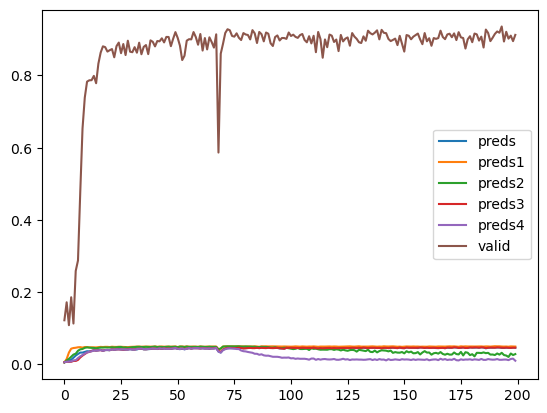

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

  0%|          | 0/200 [00:00<?, ?it/s]

***训练集***

main branch： 0.13375

准确识别驾驶员： 0.105

无法准确识别驾驶员： 0.095

准确识别行为： 0.11

无法准确识别行为： 0.09875

flag1 0.105 flag2 0.11


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  0%|          | 1/200 [00:13<45:44, 13.79s/it]

valid-f1: 0.0325097814421115

valid-precision: 0.037679270211731467

valid-recall: 0.1057388561137558

process: 1  loss: 185.8359866142273  train_correct: 0.0 valid_loss 470.1785101890564  val_correct: 0.10528735632183908

The model has been saved!!

The best val_acc is  0.10528735632183908

***训练集***

main branch： 0.1625

准确识别驾驶员： 0.27875

无法准确识别驾驶员： 0.19

准确识别行为： 0.11625

无法准确识别行为： 0.12

flag1 0.27875 flag2 0.11625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 2/200 [00:27<44:51, 13.59s/it]

valid-f1: 0.03987506096126956

valid-precision: 0.024378113384722296

valid-recall: 0.11353204373689696

process: 2  loss: 174.9012770652771  train_correct: 0.0 valid_loss 469.24483704566956  val_correct: 0.12306513409961686

The model has been saved!!

The best val_acc is  0.12306513409961686

***训练集***

main branch： 0.22875

准确识别驾驶员： 0.71125

无法准确识别驾驶员： 0.2175

准确识别行为： 0.115

无法准确识别行为： 0.11625

flag1 0.71125 flag2 0.115


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 3/200 [00:40<44:49, 13.65s/it]

valid-f1: 0.024159101904805323

valid-precision: 0.022558483288024202

valid-recall: 0.1027027027027027

process: 3  loss: 142.97213506698608  train_correct: 0.0 valid_loss 469.03842544555664  val_correct: 0.10988505747126437

***训练集***

main branch： 0.2875

准确识别驾驶员： 0.83625

无法准确识别驾驶员： 0.4125

准确识别行为： 0.12625

无法准确识别行为： 0.14375

flag1 0.83625 flag2 0.12625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 4/200 [00:54<44:19, 13.57s/it]

valid-f1: 0.0400093862192476

valid-precision: 0.024904603362086913

valid-recall: 0.11279272531278857

process: 4  loss: 124.80787897109985  train_correct: 0.0 valid_loss 468.3433644771576  val_correct: 0.12352490421455939

The model has been saved!!

The best val_acc is  0.12352490421455939

***训练集***

main branch： 0.4075

准确识别驾驶员： 0.92

无法准确识别驾驶员： 0.495

准确识别行为： 0.1125

无法准确识别行为： 0.135

flag1 0.92 flag2 0.1125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▎         | 5/200 [01:07<44:05, 13.57s/it]

valid-f1: 0.020426243771827144

valid-precision: 0.018726150993188546

valid-recall: 0.0990545879195965

process: 5  loss: 109.98480796813965  train_correct: 0.0 valid_loss 467.01484274864197  val_correct: 0.10973180076628353

***训练集***

main branch： 0.47125

准确识别驾驶员： 0.91625

无法准确识别驾驶员： 0.54125

准确识别行为： 0.17875

无法准确识别行为： 0.1975

flag1 0.91625 flag2 0.17875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 6/200 [01:21<44:08, 13.65s/it]

valid-f1: 0.07787103795780739

valid-precision: 0.12080933752702228

valid-recall: 0.13897739182340374

process: 6  loss: 102.9269552230835  train_correct: 0.0 valid_loss 463.47527170181274  val_correct: 0.15019157088122606

The model has been saved!!

The best val_acc is  0.15019157088122606

***训练集***

main branch： 0.575

准确识别驾驶员： 0.9025

无法准确识别驾驶员： 0.61625

准确识别行为： 0.21125

无法准确识别行为： 0.29375

flag1 0.9025 flag2 0.21125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 7/200 [01:35<43:47, 13.61s/it]

valid-f1: 0.17358967210950635

valid-precision: 0.1642061404400223

valid-recall: 0.2608215027983924

process: 7  loss: 96.88567852973938  train_correct: 0.0 valid_loss 454.782692193985  val_correct: 0.2732567049808429

The model has been saved!!

The best val_acc is  0.2732567049808429

***训练集***

main branch： 0.655

准确识别驾驶员： 0.945

无法准确识别驾驶员： 0.80375

准确识别行为： 0.28125

无法准确识别行为： 0.37

flag1 0.945 flag2 0.28125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 8/200 [01:49<43:42, 13.66s/it]

valid-f1: 0.18501443115666966

valid-precision: 0.3579391599868801

valid-recall: 0.28175696926923

process: 8  loss: 87.72574424743652  train_correct: 0.0 valid_loss 439.3656573295593  val_correct: 0.29379310344827586

The model has been saved!!

The best val_acc is  0.29379310344827586

***训练集***

main branch： 0.6475

准确识别驾驶员： 0.93625

无法准确识别驾驶员： 0.86

准确识别行为： 0.42375

无法准确识别行为： 0.47

flag1 0.93625 flag2 0.42375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 9/200 [02:02<43:22, 13.62s/it]

valid-f1: 0.4878565063740015

valid-precision: 0.641980067441455

valid-recall: 0.5090563586448879

process: 9  loss: 85.8160765171051  train_correct: 0.0 valid_loss 393.4952527284622  val_correct: 0.5270498084291187

The model has been saved!!

The best val_acc is  0.5270498084291187

***训练集***

main branch： 0.64875

准确识别驾驶员： 0.9225

无法准确识别驾驶员： 0.8725

准确识别行为： 0.53625

无法准确识别行为： 0.555

flag1 0.9225 flag2 0.53625


  5%|▌         | 10/200 [02:16<43:15, 13.66s/it]

valid-f1: 0.7283025304549404

valid-precision: 0.8066555702689108

valid-recall: 0.751859300709224

process: 10  loss: 80.81583762168884  train_correct: 0.0 valid_loss 346.41185569763184  val_correct: 0.7695019157088122

The model has been saved!!

The best val_acc is  0.7695019157088122

***训练集***

main branch： 0.685

准确识别驾驶员： 0.94375

无法准确识别驾驶员： 0.90875

准确识别行为： 0.635

无法准确识别行为： 0.63875

flag1 0.94375 flag2 0.635


  6%|▌         | 11/200 [02:29<42:44, 13.57s/it]

valid-f1: 0.7424516888251165

valid-precision: 0.8065502892683734

valid-recall: 0.766134437586811

process: 11  loss: 70.92879271507263  train_correct: 0.0 valid_loss 262.5438506603241  val_correct: 0.7848275862068965

The model has been saved!!

The best val_acc is  0.7848275862068965

***训练集***

main branch： 0.74125

准确识别驾驶员： 0.94875

无法准确识别驾驶员： 0.9325

准确识别行为： 0.6825

无法准确识别行为： 0.7

flag1 0.94875 flag2 0.6825


  6%|▌         | 12/200 [02:43<42:24, 13.54s/it]

valid-f1: 0.8338836373982691

valid-precision: 0.8366666970880438

valid-recall: 0.8383758089105804

process: 12  loss: 58.187440633773804  train_correct: 0.0 valid_loss 193.38563564419746  val_correct: 0.8473563218390805

The model has been saved!!

The best val_acc is  0.8473563218390805

***训练集***

main branch： 0.70875

准确识别驾驶员： 0.9475

无法准确识别驾驶员： 0.93125

准确识别行为： 0.7025

无法准确识别行为： 0.68125

flag1 0.9475 flag2 0.7025


  6%|▋         | 13/200 [02:57<42:28, 13.63s/it]

valid-f1: 0.8538966249999257

valid-precision: 0.8603333415210127

valid-recall: 0.8553132742388524

process: 13  loss: 58.42916417121887  train_correct: 0.0 valid_loss 151.9751923084259  val_correct: 0.86544061302682

The model has been saved!!

The best val_acc is  0.86544061302682

***训练集***

main branch： 0.7675

准确识别驾驶员： 0.95125

无法准确识别驾驶员： 0.935

准确识别行为： 0.77625

无法准确识别行为： 0.775

flag1 0.95125 flag2 0.77625


  7%|▋         | 14/200 [03:10<42:16, 13.64s/it]

valid-f1: 0.8296645234186218

valid-precision: 0.8372783626386167

valid-recall: 0.8334708530345184

process: 14  loss: 45.757617354393005  train_correct: 0.0 valid_loss 138.18177212774754  val_correct: 0.8401532567049809

***训练集***

main branch： 0.77125

准确识别驾驶员： 0.9525

无法准确识别驾驶员： 0.935

准确识别行为： 0.74625

无法准确识别行为： 0.75125

flag1 0.9525 flag2 0.74625


  8%|▊         | 15/200 [03:24<42:18, 13.72s/it]

valid-f1: 0.8665795793345193

valid-precision: 0.8836944982815556

valid-recall: 0.8650555478723989

process: 15  loss: 46.040356278419495  train_correct: 0.0 valid_loss 114.73663884401321  val_correct: 0.8752490421455938

The model has been saved!!

The best val_acc is  0.8752490421455938

***训练集***

main branch： 0.7625

准确识别驾驶员： 0.955

无法准确识别驾驶员： 0.9375

准确识别行为： 0.76375

无法准确识别行为： 0.76125

flag1 0.955 flag2 0.76375


  8%|▊         | 16/200 [03:38<41:49, 13.64s/it]

valid-f1: 0.8311381393639591

valid-precision: 0.8421546159691486

valid-recall: 0.8330715215700633

process: 16  loss: 42.89820730686188  train_correct: 0.0 valid_loss 107.17635875195265  val_correct: 0.8415325670498084

***训练集***

main branch： 0.765

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.94625

准确识别行为： 0.76875

无法准确识别行为： 0.77

flag1 0.965 flag2 0.76875


  8%|▊         | 17/200 [03:51<41:36, 13.64s/it]

valid-f1: 0.8301607049214328

valid-precision: 0.852721211144034

valid-recall: 0.8313852024924724

process: 17  loss: 41.00029420852661  train_correct: 0.0 valid_loss 108.0521869212389  val_correct: 0.8406130268199233

***训练集***

main branch： 0.79375

准确识别驾驶员： 0.9475

无法准确识别驾驶员： 0.93

准确识别行为： 0.7975

无法准确识别行为： 0.7875

flag1 0.9475 flag2 0.7975


  9%|▉         | 18/200 [04:05<41:13, 13.59s/it]

valid-f1: 0.8312204375262677

valid-precision: 0.8430084877665607

valid-recall: 0.8327454877730993

process: 18  loss: 38.9224408864975  train_correct: 0.0 valid_loss 105.86367749795318  val_correct: 0.8424521072796934

***训练集***

main branch： 0.81

准确识别驾驶员： 0.9525

无法准确识别驾驶员： 0.93375

准确识别行为： 0.825

无法准确识别行为： 0.81

flag1 0.9525 flag2 0.825


 10%|▉         | 19/200 [04:18<40:57, 13.58s/it]

valid-f1: 0.8417963177890406

valid-precision: 0.8488737795011219

valid-recall: 0.84506276497295

process: 19  loss: 35.56647723913193  train_correct: 0.0 valid_loss 112.76058648526669  val_correct: 0.8484291187739463

***训练集***

main branch： 0.79625

准确识别驾驶员： 0.95

无法准确识别驾驶员： 0.92625

准确识别行为： 0.77875

无法准确识别行为： 0.7925

flag1 0.95 flag2 0.77875


 10%|█         | 20/200 [04:32<40:57, 13.65s/it]

valid-f1: 0.8379823897389942

valid-precision: 0.8580809275036854

valid-recall: 0.8430186543484558

process: 20  loss: 38.57588469982147  train_correct: 0.0 valid_loss 113.3883707113564  val_correct: 0.8485823754789272

***训练集***

main branch： 0.80375

准确识别驾驶员： 0.94625

无法准确识别驾驶员： 0.9175

准确识别行为： 0.8225

无法准确识别行为： 0.8025

flag1 0.94625 flag2 0.8225


 10%|█         | 21/200 [04:46<40:40, 13.64s/it]

valid-f1: 0.8587683449968804

valid-precision: 0.8686242912452729

valid-recall: 0.8595682053381684

process: 21  loss: 35.87656468153  train_correct: 0.0 valid_loss 92.94300342723727  val_correct: 0.8691187739463602

***训练集***

main branch： 0.805

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.93875

准确识别行为： 0.82125

无法准确识别行为： 0.815

flag1 0.96125 flag2 0.82125


 11%|█         | 22/200 [05:00<40:39, 13.71s/it]

valid-f1: 0.8321466573416372

valid-precision: 0.8682222065177223

valid-recall: 0.8332441105364765

process: 22  loss: 33.75781959295273  train_correct: 0.0 valid_loss 106.18417759239674  val_correct: 0.8424521072796934

***训练集***

main branch： 0.81

准确识别驾驶员： 0.9525

无法准确识别驾驶员： 0.94375

准确识别行为： 0.81

无法准确识别行为： 0.8075

flag1 0.9525 flag2 0.81


 12%|█▏        | 23/200 [05:13<40:26, 13.71s/it]

valid-f1: 0.8638782396464674

valid-precision: 0.8716479296159738

valid-recall: 0.8644391409011984

process: 23  loss: 35.774042546749115  train_correct: 0.0 valid_loss 83.2993851006031  val_correct: 0.8754022988505747

The model has been saved!!

The best val_acc is  0.8754022988505747

***训练集***

main branch： 0.7875

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.94875

准确识别行为： 0.79125

无法准确识别行为： 0.78875

flag1 0.95875 flag2 0.79125


 12%|█▏        | 24/200 [05:27<40:04, 13.66s/it]

valid-f1: 0.8554401355363496

valid-precision: 0.8697786490274385

valid-recall: 0.856116575421028

process: 24  loss: 35.377696454524994  train_correct: 0.0 valid_loss 93.7680944763124  val_correct: 0.8677394636015325

***训练集***

main branch： 0.80375

准确识别驾驶员： 0.95125

无法准确识别驾驶员： 0.94

准确识别行为： 0.81875

无法准确识别行为： 0.81875

flag1 0.95125 flag2 0.81875


 12%|█▎        | 25/200 [05:40<39:45, 13.63s/it]

valid-f1: 0.8640688643647717

valid-precision: 0.8773972048692602

valid-recall: 0.8642511716144667

process: 25  loss: 31.792576789855957  train_correct: 0.0 valid_loss 82.71129018813372  val_correct: 0.866360153256705

***训练集***

main branch： 0.84

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.96125

准确识别行为： 0.84125

无法准确识别行为： 0.8425

flag1 0.9725 flag2 0.84125


 13%|█▎        | 26/200 [05:54<39:48, 13.73s/it]

valid-f1: 0.8712584105240506

valid-precision: 0.8832379313503557

valid-recall: 0.8708095754148806

process: 26  loss: 29.60570478439331  train_correct: 0.0 valid_loss 91.12499125674367  val_correct: 0.8798467432950191

The model has been saved!!

The best val_acc is  0.8798467432950191

***训练集***

main branch： 0.84

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.96

准确识别行为： 0.84875

无法准确识别行为： 0.84375

flag1 0.98 flag2 0.84875


 14%|█▎        | 27/200 [06:08<39:34, 13.73s/it]

valid-f1: 0.862501534456881

valid-precision: 0.8743790014562911

valid-recall: 0.8622166993011484

process: 27  loss: 28.081165432929993  train_correct: 0.0 valid_loss 95.00765877217054  val_correct: 0.8718773946360153

***训练集***

main branch： 0.8075

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.93125

准确识别行为： 0.815

无法准确识别行为： 0.815

flag1 0.9675 flag2 0.815


 14%|█▍        | 28/200 [06:22<39:14, 13.69s/it]

valid-f1: 0.8730570156681223

valid-precision: 0.8839697389249792

valid-recall: 0.873558944808682

process: 28  loss: 31.257083475589752  train_correct: 0.0 valid_loss 89.00467112660408  val_correct: 0.8801532567049808

The model has been saved!!

The best val_acc is  0.8801532567049808

***训练集***

main branch： 0.80625

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.95875

准确识别行为： 0.8275

无法准确识别行为： 0.81875

flag1 0.96375 flag2 0.8275


 14%|█▍        | 29/200 [06:35<39:06, 13.72s/it]

valid-f1: 0.8524475692390354

valid-precision: 0.879303923784479

valid-recall: 0.8559561637548961

process: 29  loss: 31.283271729946136  train_correct: 0.0 valid_loss 100.71628708392382  val_correct: 0.8662068965517241

***训练集***

main branch： 0.79625

准确识别驾驶员： 0.94

无法准确识别驾驶员： 0.93375

准确识别行为： 0.79875

无法准确识别行为： 0.7925

flag1 0.94 flag2 0.79875


 15%|█▌        | 30/200 [06:49<38:50, 13.71s/it]

valid-f1: 0.8866147526084568

valid-precision: 0.8920452813591468

valid-recall: 0.8859389703978648

process: 30  loss: 36.015059888362885  train_correct: 0.0 valid_loss 75.57339203963056  val_correct: 0.89272030651341

The model has been saved!!

The best val_acc is  0.89272030651341

***训练集***

main branch： 0.85125

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.93375

准确识别行为： 0.84875

无法准确识别行为： 0.84375

flag1 0.96 flag2 0.84875


 16%|█▌        | 31/200 [07:03<38:43, 13.75s/it]

valid-f1: 0.8651246633291045

valid-precision: 0.8745206830691152

valid-recall: 0.8634204811151717

process: 31  loss: 27.048327058553696  train_correct: 0.0 valid_loss 88.01764131244272  val_correct: 0.8703448275862069

***训练集***

main branch： 0.8075

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.96125

准确识别行为： 0.81375

无法准确识别行为： 0.81375

flag1 0.96875 flag2 0.81375


 16%|█▌        | 32/200 [07:17<38:31, 13.76s/it]

valid-f1: 0.8911112634646965

valid-precision: 0.8987030627849212

valid-recall: 0.8885244686760723

process: 32  loss: 30.975848257541656  train_correct: 0.0 valid_loss 75.6359085412696  val_correct: 0.8960919540229885

The model has been saved!!

The best val_acc is  0.8960919540229885

***训练集***

main branch： 0.8225

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.965

准确识别行为： 0.8425

无法准确识别行为： 0.8325

flag1 0.96875 flag2 0.8425


 16%|█▋        | 33/200 [07:31<38:20, 13.77s/it]

valid-f1: 0.877572337337193

valid-precision: 0.88533623157652

valid-recall: 0.8770252945188437

process: 33  loss: 27.361926674842834  train_correct: 0.0 valid_loss 80.25742055848241  val_correct: 0.8807662835249043

***训练集***

main branch： 0.8225

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.95625

准确识别行为： 0.84125

无法准确识别行为： 0.83375

flag1 0.96375 flag2 0.84125


 17%|█▋        | 34/200 [07:44<37:56, 13.71s/it]

valid-f1: 0.8835508232137469

valid-precision: 0.8933695536596797

valid-recall: 0.882071800212111

process: 34  loss: 28.499484598636627  train_correct: 0.0 valid_loss 70.54242677334696  val_correct: 0.8904214559386974

***训练集***

main branch： 0.81625

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.95875

准确识别行为： 0.82625

无法准确识别行为： 0.82125

flag1 0.96625 flag2 0.82625


 18%|█▊        | 35/200 [07:58<37:27, 13.62s/it]

valid-f1: 0.8683368741049119

valid-precision: 0.8841259361732133

valid-recall: 0.8726059272511592

process: 35  loss: 31.142463862895966  train_correct: 0.0 valid_loss 83.45358394645154  val_correct: 0.8734099616858237

***训练集***

main branch： 0.83625

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.95625

准确识别行为： 0.83

无法准确识别行为： 0.83125

flag1 0.965 flag2 0.83


 18%|█▊        | 36/200 [08:11<37:21, 13.67s/it]

valid-f1: 0.8528530159685944

valid-precision: 0.874138530407107

valid-recall: 0.8562660695724974

process: 36  loss: 29.359239637851715  train_correct: 0.0 valid_loss 88.80317442305386  val_correct: 0.8706513409961686

***训练集***

main branch： 0.8025

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.96

准确识别行为： 0.80875

无法准确识别行为： 0.8075

flag1 0.9675 flag2 0.80875


 18%|█▊        | 37/200 [08:25<37:05, 13.65s/it]

valid-f1: 0.8567217169269472

valid-precision: 0.8632712080936858

valid-recall: 0.8602540440390287

process: 37  loss: 32.44361853599548  train_correct: 0.0 valid_loss 91.58588198851794  val_correct: 0.8671264367816092

***训练集***

main branch： 0.82375

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.94625

准确识别行为： 0.84

无法准确识别行为： 0.83

flag1 0.96375 flag2 0.84


 19%|█▉        | 38/200 [08:39<37:02, 13.72s/it]

valid-f1: 0.8472117408694249

valid-precision: 0.8547971806913051

valid-recall: 0.851944488346249

process: 38  loss: 28.65912014245987  train_correct: 0.0 valid_loss 103.21650484483689  val_correct: 0.8553256704980843

***训练集***

main branch： 0.84125

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.95375

准确识别行为： 0.86125

无法准确识别行为： 0.855

flag1 0.96125 flag2 0.86125


 20%|█▉        | 39/200 [08:52<36:43, 13.68s/it]

valid-f1: 0.8720342356566831

valid-precision: 0.8766726538556331

valid-recall: 0.8725234998439383

process: 39  loss: 25.818936347961426  train_correct: 0.0 valid_loss 77.43010280095041  val_correct: 0.8764750957854406

***训练集***

main branch： 0.825

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.9525

准确识别行为： 0.83875

无法准确识别行为： 0.83625

flag1 0.9575 flag2 0.83875


 20%|██        | 40/200 [09:06<36:37, 13.74s/it]

valid-f1: 0.8945599511606563

valid-precision: 0.8977443636153302

valid-recall: 0.8939217183319406

process: 40  loss: 29.389946341514587  train_correct: 0.0 valid_loss 69.217727990821  val_correct: 0.8986973180076628

The model has been saved!!

The best val_acc is  0.8986973180076628

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.95

无法准确识别驾驶员： 0.93125

准确识别行为： 0.86

无法准确识别行为： 0.865

flag1 0.95 flag2 0.86


 20%|██        | 41/200 [09:20<36:08, 13.64s/it]

valid-f1: 0.8598471777201409

valid-precision: 0.8788757438961422

valid-recall: 0.8601335382206864

process: 41  loss: 26.443727731704712  train_correct: 0.0 valid_loss 89.68590663280338  val_correct: 0.8680459770114942

***训练集***

main branch： 0.8575

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.9575

准确识别行为： 0.86375

无法准确识别行为： 0.85625

flag1 0.96375 flag2 0.86375


 21%|██        | 42/200 [09:33<35:49, 13.60s/it]

valid-f1: 0.8495974728944798

valid-precision: 0.8666251984278471

valid-recall: 0.8502905753063006

process: 42  loss: 23.913101494312286  train_correct: 0.0 valid_loss 97.71422825567424  val_correct: 0.8577777777777778

***训练集***

main branch： 0.84625

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.95

准确识别行为： 0.85875

无法准确识别行为： 0.85875

flag1 0.9775 flag2 0.85875


 22%|██▏       | 43/200 [09:47<36:04, 13.79s/it]

valid-f1: 0.8972997014789718

valid-precision: 0.8998153515634281

valid-recall: 0.8979577773028253

process: 43  loss: 25.06958317756653  train_correct: 0.0 valid_loss 70.5707507384941  val_correct: 0.9005363984674329

The model has been saved!!

The best val_acc is  0.9005363984674329

***训练集***

main branch： 0.85875

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.97375

准确识别行为： 0.86625

无法准确识别行为： 0.86375

flag1 0.98 flag2 0.86625


 22%|██▏       | 44/200 [10:01<35:50, 13.79s/it]

valid-f1: 0.8857452687355025

valid-precision: 0.8880921831548759

valid-recall: 0.8870972199177614

process: 44  loss: 23.76962411403656  train_correct: 0.0 valid_loss 68.8136128904298  val_correct: 0.8934865900383142

***训练集***

main branch： 0.85375

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.9575

准确识别行为： 0.85375

无法准确识别行为： 0.84875

flag1 0.975 flag2 0.85375


 22%|██▎       | 45/200 [10:15<35:54, 13.90s/it]

valid-f1: 0.8740705710659384

valid-precision: 0.8827655642784416

valid-recall: 0.8739430815025212

process: 45  loss: 23.774199545383453  train_correct: 0.0 valid_loss 79.43908583838493  val_correct: 0.8812260536398467

***训练集***

main branch： 0.85

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.97

准确识别行为： 0.8675

无法准确识别行为： 0.85875

flag1 0.97875 flag2 0.8675


 23%|██▎       | 46/200 [10:29<35:35, 13.87s/it]

valid-f1: 0.8736238005456842

valid-precision: 0.8922623755695197

valid-recall: 0.8720776692947286

process: 46  loss: 24.703551173210144  train_correct: 0.0 valid_loss 82.92584045883268  val_correct: 0.8804597701149425

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.95875

准确识别行为： 0.875

无法准确识别行为： 0.865

flag1 0.97125 flag2 0.875


 24%|██▎       | 47/200 [10:43<35:21, 13.86s/it]

valid-f1: 0.8194569550787347

valid-precision: 0.8611928131467611

valid-recall: 0.8256023581889027

process: 47  loss: 23.522389829158783  train_correct: 0.0 valid_loss 117.90447142068297  val_correct: 0.8228352490421456

***训练集***

main branch： 0.83125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.9625

准确识别行为： 0.8325

无法准确识别行为： 0.8325

flag1 0.97625 flag2 0.8325


 24%|██▍       | 48/200 [10:57<35:01, 13.82s/it]

valid-f1: 0.8862901211680276

valid-precision: 0.8889029228961757

valid-recall: 0.8871445581139744

process: 48  loss: 26.300395488739014  train_correct: 0.0 valid_loss 67.10086464323103  val_correct: 0.8901149425287357

***训练集***

main branch： 0.83125

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.95375

准确识别行为： 0.84

无法准确识别行为： 0.83125

flag1 0.97 flag2 0.84


 24%|██▍       | 49/200 [11:11<34:50, 13.85s/it]

valid-f1: 0.888276485296379

valid-precision: 0.8923044044128317

valid-recall: 0.8878780104863253

process: 49  loss: 25.769411832094193  train_correct: 0.0 valid_loss 78.56859641894698  val_correct: 0.8934865900383142

***训练集***

main branch： 0.86

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.9575

准确识别行为： 0.85875

无法准确识别行为： 0.86625

flag1 0.96625 flag2 0.85875


 25%|██▌       | 50/200 [11:24<34:36, 13.85s/it]

valid-f1: 0.8844068711983025

valid-precision: 0.8981503280043606

valid-recall: 0.8872107328586869

process: 50  loss: 23.716396987438202  train_correct: 0.0 valid_loss 77.0215083276853  val_correct: 0.8948659003831417

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.96375

准确识别行为： 0.89

无法准确识别行为： 0.89125

flag1 0.9725 flag2 0.89


 26%|██▌       | 51/200 [11:38<34:08, 13.75s/it]

valid-f1: 0.8953449586563474

valid-precision: 0.9034041592569506

valid-recall: 0.8931814411295317

process: 51  loss: 18.5520099401474  train_correct: 0.0 valid_loss 74.11550676613115  val_correct: 0.9008429118773946

The model has been saved!!

The best val_acc is  0.9008429118773946

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.95375

准确识别行为： 0.8775

无法准确识别行为： 0.875

flag1 0.9825 flag2 0.8775


 26%|██▌       | 52/200 [11:52<33:57, 13.77s/it]

valid-f1: 0.8971413159467405

valid-precision: 0.9076024287718987

valid-recall: 0.895552252065205

process: 52  loss: 20.168294966220856  train_correct: 0.0 valid_loss 72.34868851397187  val_correct: 0.903448275862069

The model has been saved!!

The best val_acc is  0.903448275862069

***训练集***

main branch： 0.86

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.9675

准确识别行为： 0.85625

无法准确识别行为： 0.86125

flag1 0.9725 flag2 0.85625


 26%|██▋       | 53/200 [12:05<33:25, 13.64s/it]

valid-f1: 0.8881176963788008

valid-precision: 0.8921733534225483

valid-recall: 0.8874262045693893

process: 53  loss: 23.474035814404488  train_correct: 0.0 valid_loss 71.14524338766932  val_correct: 0.8924137931034483

***训练集***

main branch： 0.8425

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.96875

准确识别行为： 0.85625

无法准确识别行为： 0.86625

flag1 0.97 flag2 0.85625


 27%|██▋       | 54/200 [12:19<33:16, 13.67s/it]

valid-f1: 0.8700451352839812

valid-precision: 0.8812306463297059

valid-recall: 0.871485302679005

process: 54  loss: 24.240652918815613  train_correct: 0.0 valid_loss 89.58440925739706  val_correct: 0.8755555555555555

***训练集***

main branch： 0.8625

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.94875

准确识别行为： 0.8625

无法准确识别行为： 0.8475

flag1 0.96 flag2 0.8625


 28%|██▊       | 55/200 [12:32<32:52, 13.61s/it]

valid-f1: 0.8972832010274372

valid-precision: 0.9085354754276251

valid-recall: 0.8945189705050944

process: 55  loss: 23.845930218696594  train_correct: 0.0 valid_loss 70.03730070218444  val_correct: 0.901455938697318

***训练集***

main branch： 0.8675

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.9675

准确识别行为： 0.8675

无法准确识别行为： 0.8625

flag1 0.97125 flag2 0.8675


 28%|██▊       | 56/200 [12:46<32:40, 13.61s/it]

valid-f1: 0.8974245547811908

valid-precision: 0.8999829543216882

valid-recall: 0.8971369899996612

process: 56  loss: 22.907761722803116  train_correct: 0.0 valid_loss 63.96936061279848  val_correct: 0.9025287356321839

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.9525

准确识别行为： 0.88125

无法准确识别行为： 0.87875

flag1 0.96125 flag2 0.88125


 28%|██▊       | 57/200 [12:59<32:19, 13.56s/it]

valid-f1: 0.8791716614793719

valid-precision: 0.8994625706115436

valid-recall: 0.87871722866329

process: 57  loss: 21.564835339784622  train_correct: 0.0 valid_loss 79.8538875207305  val_correct: 0.8896551724137931

***训练集***

main branch： 0.8425

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.9575

准确识别行为： 0.85

无法准确识别行为： 0.84875

flag1 0.9625 flag2 0.85


 29%|██▉       | 58/200 [13:13<31:59, 13.52s/it]

valid-f1: 0.8947362378028855

valid-precision: 0.9010224459702936

valid-recall: 0.8935656716577342

process: 58  loss: 26.262177646160126  train_correct: 0.0 valid_loss 66.51952933613211  val_correct: 0.9019157088122606

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.955

准确识别行为： 0.87875

无法准确识别行为： 0.88875

flag1 0.965 flag2 0.87875


 30%|██▉       | 59/200 [13:27<31:53, 13.57s/it]

valid-f1: 0.8971687131526572

valid-precision: 0.9016250509495908

valid-recall: 0.8982618854868445

process: 59  loss: 22.02746120095253  train_correct: 0.0 valid_loss 71.55681069381535  val_correct: 0.9002298850574713

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.96

准确识别行为： 0.885

无法准确识别行为： 0.87625

flag1 0.9725 flag2 0.885


 30%|███       | 60/200 [13:40<31:35, 13.54s/it]

valid-f1: 0.8502514197623178

valid-precision: 0.8672683708274587

valid-recall: 0.86165817189815

process: 60  loss: 21.941673398017883  train_correct: 0.0 valid_loss 92.55477758310735  val_correct: 0.8606896551724138

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.95125

准确识别行为： 0.89375

无法准确识别行为： 0.88875

flag1 0.96 flag2 0.89375


 30%|███       | 61/200 [13:54<31:26, 13.57s/it]

valid-f1: 0.8813828938213584

valid-precision: 0.8841267234984495

valid-recall: 0.8849114206439369

process: 61  loss: 19.858941540122032  train_correct: 0.0 valid_loss 79.0164120644331  val_correct: 0.8899616858237548

***训练集***

main branch： 0.8525

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.95875

准确识别行为： 0.8575

无法准确识别行为： 0.845

flag1 0.9725 flag2 0.8575


 31%|███       | 62/200 [14:07<31:10, 13.56s/it]

valid-f1: 0.8805037897731145

valid-precision: 0.8847859470213285

valid-recall: 0.8843690189645608

process: 62  loss: 23.38152939081192  train_correct: 0.0 valid_loss 80.60340115334839  val_correct: 0.886743295019157

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.97625

准确识别行为： 0.8875

无法准确识别行为： 0.89

flag1 0.9825 flag2 0.8875


 32%|███▏      | 63/200 [14:21<31:04, 13.61s/it]

valid-f1: 0.9151048156162463

valid-precision: 0.921885344455409

valid-recall: 0.9137670013821163

process: 63  loss: 18.50358310341835  train_correct: 0.0 valid_loss 56.8228401185479  val_correct: 0.9201532567049808

The model has been saved!!

The best val_acc is  0.9201532567049808

***训练集***

main branch： 0.87

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.965

准确识别行为： 0.88375

无法准确识别行为： 0.875

flag1 0.975 flag2 0.88375


 32%|███▏      | 64/200 [14:34<30:42, 13.54s/it]

valid-f1: 0.8930753511951209

valid-precision: 0.906529083868244

valid-recall: 0.8928902783152346

process: 64  loss: 20.84196075797081  train_correct: 0.0 valid_loss 70.40531684318557  val_correct: 0.9013026819923372

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.96375

准确识别行为： 0.905

无法准确识别行为： 0.91125

flag1 0.98 flag2 0.905

预热结束


 32%|███▎      | 65/200 [14:48<30:18, 13.47s/it]

valid-f1: 0.9046676823674785

valid-precision: 0.9203401822825835

valid-recall: 0.9018085386733027

process: 65  loss: 17.884638398885727  train_correct: 0.0 valid_loss 67.4114839376416  val_correct: 0.9114176245210728

***训练集***

main branch： 0.685

准确识别驾驶员： 0.80375

无法准确识别驾驶员： 0.81125

准确识别行为： 0.69125

无法准确识别行为： 0.67375

flag1 0.80375 flag2 0.69125


 33%|███▎      | 66/200 [15:01<30:18, 13.57s/it]

valid-f1: 0.45911853969376243

valid-precision: 0.6901651414255111

valid-recall: 0.4578720514747525

process: 66  loss: 293.2779383659363  train_correct: 0.0 valid_loss 362.5175222158432  val_correct: 0.4657471264367816

***训练集***

main branch： 0.4925

准确识别驾驶员： 0.82125

无法准确识别驾驶员： 0.8125

准确识别行为： 0.5425

无法准确识别行为： 0.4975

flag1 0.82125 flag2 0.5425


 34%|███▎      | 67/200 [15:15<29:54, 13.49s/it]

valid-f1: 0.8336301294636046

valid-precision: 0.8492814909799105

valid-recall: 0.8303174146555611

process: 67  loss: 136.48520803451538  train_correct: 0.0 valid_loss 185.40037149190903  val_correct: 0.8375478927203065

***训练集***

main branch： 0.77375

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.96375

准确识别行为： 0.8225

无法准确识别行为： 0.76375

flag1 0.9575 flag2 0.8225


 34%|███▍      | 68/200 [15:28<29:43, 13.51s/it]

valid-f1: 0.8730035289811884

valid-precision: 0.8840617393886333

valid-recall: 0.8699400778454303

process: 68  loss: 104.64356541633606  train_correct: 0.0 valid_loss 180.39126589894295  val_correct: 0.8743295019157088

***训练集***

main branch： 0.83875

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.9825

准确识别行为： 0.8625

无法准确识别行为： 0.82875

flag1 0.9825 flag2 0.8625


 34%|███▍      | 69/200 [15:41<29:19, 13.43s/it]

valid-f1: 0.8878146799735152

valid-precision: 0.8958150356231952

valid-recall: 0.8852086116682711

process: 69  loss: 91.51067304611206  train_correct: 0.0 valid_loss 174.39241155982018  val_correct: 0.89272030651341

***训练集***

main branch： 0.85625

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.98375

准确识别行为： 0.87625

无法准确识别行为： 0.83125

flag1 0.98875 flag2 0.87625


 35%|███▌      | 70/200 [15:55<29:05, 13.43s/it]

valid-f1: 0.8832207227100237

valid-precision: 0.8871282431246886

valid-recall: 0.883513241745859

process: 70  loss: 81.59170436859131  train_correct: 0.0 valid_loss 170.42949870228767  val_correct: 0.887816091954023

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.98875

准确识别行为： 0.88

无法准确识别行为： 0.86875

flag1 0.9825 flag2 0.88


 36%|███▌      | 71/200 [16:08<28:43, 13.36s/it]

valid-f1: 0.9056040541463822

valid-precision: 0.9061368557092425

valid-recall: 0.9065180315300919

process: 71  loss: 71.71993160247803  train_correct: 0.0 valid_loss 176.50102680921555  val_correct: 0.9094252873563219

***训练集***

main branch： 0.89

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.98875

准确识别行为： 0.895

无法准确识别行为： 0.84

flag1 0.98375 flag2 0.895


 36%|███▌      | 72/200 [16:21<28:24, 13.32s/it]

valid-f1: 0.896517493341395

valid-precision: 0.9025173083780083

valid-recall: 0.8964862389319854

process: 72  loss: 65.18410396575928  train_correct: 0.0 valid_loss 178.3275539278984  val_correct: 0.9026819923371647

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.9925

无法准确识别驾驶员： 0.99375

准确识别行为： 0.885

无法准确识别行为： 0.84875

flag1 0.9925 flag2 0.885


 36%|███▋      | 73/200 [16:35<28:26, 13.44s/it]

valid-f1: 0.8954478135447802

valid-precision: 0.8991869575983044

valid-recall: 0.8950899605877561

process: 73  loss: 59.10347080230713  train_correct: 0.0 valid_loss 194.37277776002884  val_correct: 0.9011494252873563

***训练集***

main branch： 0.9

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.98625

准确识别行为： 0.905

无法准确识别行为： 0.8575

flag1 0.98875 flag2 0.905


 37%|███▋      | 74/200 [16:48<28:07, 13.40s/it]

valid-f1: 0.893859590267103

valid-precision: 0.9140584804271628

valid-recall: 0.8950438302327534

process: 74  loss: 53.35611939430237  train_correct: 0.0 valid_loss 178.0898586511612  val_correct: 0.9049808429118774

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.9875

准确识别行为： 0.8875

无法准确识别行为： 0.7975

flag1 0.9875 flag2 0.8875


 38%|███▊      | 75/200 [17:02<27:55, 13.40s/it]

valid-f1: 0.9058037838507396

valid-precision: 0.9134487784028412

valid-recall: 0.9039854984188208

process: 75  loss: 50.83483123779297  train_correct: 0.0 valid_loss 164.55975407361984  val_correct: 0.9123371647509578

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.97875

准确识别行为： 0.87875

无法准确识别行为： 0.77125

flag1 0.9825 flag2 0.87875


 38%|███▊      | 76/200 [17:15<27:36, 13.36s/it]

valid-f1: 0.8908525774206943

valid-precision: 0.9077020249528458

valid-recall: 0.8889690264330218

process: 76  loss: 49.47303795814514  train_correct: 0.0 valid_loss 164.80332589149475  val_correct: 0.8988505747126436

***训练集***

main branch： 0.905

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.97375

准确识别行为： 0.88

无法准确识别行为： 0.73875

flag1 0.9875 flag2 0.88


 38%|███▊      | 77/200 [17:29<27:30, 13.42s/it]

valid-f1: 0.9140652087810794

valid-precision: 0.9204178325532361

valid-recall: 0.9122231019933077

process: 77  loss: 46.58117198944092  train_correct: 0.0 valid_loss 143.7621969282627  val_correct: 0.9193869731800767

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.96875

准确识别行为： 0.87125

无法准确识别行为： 0.70125

flag1 0.98375 flag2 0.87125


 39%|███▉      | 78/200 [17:42<27:10, 13.37s/it]

valid-f1: 0.9145714567450298

valid-precision: 0.9143549745619375

valid-recall: 0.9154371443577348

process: 78  loss: 44.138744950294495  train_correct: 0.0 valid_loss 145.72131177783012  val_correct: 0.9193869731800767

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.96375

准确识别行为： 0.88375

无法准确识别行为： 0.65875

flag1 0.97 flag2 0.88375


 40%|███▉      | 79/200 [17:55<26:55, 13.35s/it]

valid-f1: 0.920892976875435

valid-precision: 0.9279307284231718

valid-recall: 0.9183988443420864

process: 79  loss: 42.82258367538452  train_correct: 0.0 valid_loss 129.68020495772362  val_correct: 0.9250574712643678

The model has been saved!!

The best val_acc is  0.9250574712643678

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.96875

准确识别行为： 0.89625

无法准确识别行为： 0.62

flag1 0.97875 flag2 0.89625


 40%|████      | 80/200 [18:09<26:53, 13.45s/it]

valid-f1: 0.896178630530402

valid-precision: 0.8998389426678817

valid-recall: 0.8971370169084562

process: 80  loss: 40.43559384346008  train_correct: 0.0 valid_loss 145.6259406208992  val_correct: 0.9005363984674329

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.955

准确识别行为： 0.91

无法准确识别行为： 0.64125

flag1 0.97125 flag2 0.91


 40%|████      | 81/200 [18:22<26:32, 13.39s/it]

valid-f1: 0.9138772014423463

valid-precision: 0.9244877427807708

valid-recall: 0.9123265345206629

process: 81  loss: 39.23973762989044  train_correct: 0.0 valid_loss 109.23975916206837  val_correct: 0.9204597701149425

***训练集***

main branch： 0.895

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.955

准确识别行为： 0.87625

无法准确识别行为： 0.5525

flag1 0.97875 flag2 0.87625


 41%|████      | 82/200 [18:35<26:16, 13.36s/it]

valid-f1: 0.8872251720729645

valid-precision: 0.9055154751682426

valid-recall: 0.8842262922490566

process: 82  loss: 40.276630997657776  train_correct: 0.0 valid_loss 136.87431597709656  val_correct: 0.8928735632183908

***训练集***

main branch： 0.895

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.95

准确识别行为： 0.8875

无法准确识别行为： 0.535

flag1 0.9775 flag2 0.8875


 42%|████▏     | 83/200 [18:49<26:02, 13.36s/it]

valid-f1: 0.9078193384280606

valid-precision: 0.9074763452672905

valid-recall: 0.9089183454536242

process: 83  loss: 35.934247612953186  train_correct: 0.0 valid_loss 125.78289395570755  val_correct: 0.9123371647509578

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.93625

准确识别行为： 0.885

无法准确识别行为： 0.4725

flag1 0.97125 flag2 0.885


 42%|████▏     | 84/200 [19:02<25:53, 13.39s/it]

valid-f1: 0.9139505867758475

valid-precision: 0.917244525555461

valid-recall: 0.912356256877116

process: 84  loss: 35.374892830848694  train_correct: 0.0 valid_loss 103.41260698437691  val_correct: 0.918007662835249

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.96

准确识别行为： 0.87875

无法准确识别行为： 0.43875

flag1 0.98875 flag2 0.87875


 42%|████▎     | 85/200 [19:15<25:35, 13.35s/it]

valid-f1: 0.9091872163589858

valid-precision: 0.9109011567821319

valid-recall: 0.9083116341177201

process: 85  loss: 35.028040051460266  train_correct: 0.0 valid_loss 104.38147035241127  val_correct: 0.9124904214559387

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.95625

准确识别行为： 0.88125

无法准确识别行为： 0.43875

flag1 0.98375 flag2 0.88125


 43%|████▎     | 86/200 [19:29<25:22, 13.36s/it]

valid-f1: 0.9301678672677391

valid-precision: 0.9336335063684273

valid-recall: 0.9287534769377441

process: 86  loss: 33.25454235076904  train_correct: 0.0 valid_loss 76.22372014820576  val_correct: 0.9334865900383141

The model has been saved!!

The best val_acc is  0.9334865900383141

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.94125

准确识别行为： 0.89375

无法准确识别行为： 0.38875

flag1 0.98125 flag2 0.89375


 44%|████▎     | 87/200 [19:42<25:15, 13.41s/it]

valid-f1: 0.8919356949361539

valid-precision: 0.8988416716081827

valid-recall: 0.8907741841704052

process: 87  loss: 30.76386070251465  train_correct: 0.0 valid_loss 95.54474087059498  val_correct: 0.8970114942528735

***训练集***

main branch： 0.91

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.925

准确识别行为： 0.9

无法准确识别行为： 0.36625

flag1 0.98125 flag2 0.9


 44%|████▍     | 88/200 [19:56<24:54, 13.35s/it]

valid-f1: 0.8942765921027247

valid-precision: 0.9022895360883876

valid-recall: 0.8929370099864797

process: 88  loss: 30.052433788776398  train_correct: 0.0 valid_loss 97.05441902577877  val_correct: 0.8988505747126436

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.91625

准确识别行为： 0.8925

无法准确识别行为： 0.38

flag1 0.96375 flag2 0.8925


 44%|████▍     | 89/200 [20:09<24:45, 13.38s/it]

valid-f1: 0.8903992209082082

valid-precision: 0.8987107457250465

valid-recall: 0.8890951415328479

process: 89  loss: 32.595714688301086  train_correct: 0.0 valid_loss 100.59116233885288  val_correct: 0.8939463601532567

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.87

准确识别行为： 0.88625

无法准确识别行为： 0.3925

flag1 0.95875 flag2 0.88625


 45%|████▌     | 90/200 [20:22<24:26, 13.33s/it]

valid-f1: 0.9021307635533871

valid-precision: 0.9076843387352692

valid-recall: 0.9015284191301831

process: 90  loss: 31.914817333221436  train_correct: 0.0 valid_loss 90.95373286306858  val_correct: 0.9085057471264368

***训练集***

main branch： 0.875

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.90625

准确识别行为： 0.87875

无法准确识别行为： 0.35375

flag1 0.965 flag2 0.87875


 46%|████▌     | 91/200 [20:36<24:16, 13.36s/it]

valid-f1: 0.897663753207144

valid-precision: 0.8990729640683789

valid-recall: 0.8991656782832582

process: 91  loss: 31.62010657787323  train_correct: 0.0 valid_loss 95.62383333593607  val_correct: 0.9017624521072797

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.915

准确识别行为： 0.88625

无法准确识别行为： 0.32625

flag1 0.97125 flag2 0.88625


 46%|████▌     | 92/200 [20:49<24:05, 13.38s/it]

valid-f1: 0.8804859547609623

valid-precision: 0.8900360346208718

valid-recall: 0.8801533322165664

process: 92  loss: 30.24261337518692  train_correct: 0.0 valid_loss 99.89738330990076  val_correct: 0.8882758620689655

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.915

准确识别行为： 0.90125

无法准确识别行为： 0.34625

flag1 0.9775 flag2 0.90125


 46%|████▋     | 93/200 [21:02<23:50, 13.37s/it]

valid-f1: 0.9079781185324954

valid-precision: 0.9154492447931982

valid-recall: 0.906354958273621

process: 93  loss: 28.502703964710236  train_correct: 0.0 valid_loss 79.05155484378338  val_correct: 0.9129501915708812

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.915

准确识别行为： 0.90125

无法准确识别行为： 0.31125

flag1 0.98125 flag2 0.90125


 47%|████▋     | 94/200 [21:16<23:42, 13.42s/it]

valid-f1: 0.8720648583300964

valid-precision: 0.8851153588921827

valid-recall: 0.878494058553551

process: 94  loss: 27.402121603488922  train_correct: 0.0 valid_loss 94.52664425224066  val_correct: 0.8798467432950191

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.9275

准确识别行为： 0.8925

无法准确识别行为： 0.32625

flag1 0.97 flag2 0.8925


 48%|████▊     | 95/200 [21:29<23:25, 13.38s/it]

valid-f1: 0.9092258204694856

valid-precision: 0.92544761052923

valid-recall: 0.9058213658779739

process: 95  loss: 27.705947816371918  train_correct: 0.0 valid_loss 76.67201887816191  val_correct: 0.9152490421455939

***训练集***

main branch： 0.89

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.85875

准确识别行为： 0.89375

无法准确识别行为： 0.2875

flag1 0.97125 flag2 0.89375


 48%|████▊     | 96/200 [21:43<23:16, 13.43s/it]

valid-f1: 0.8962474330784207

valid-precision: 0.9043233806302146

valid-recall: 0.8952681253167076

process: 96  loss: 28.990886211395264  train_correct: 0.0 valid_loss 86.47530441731215  val_correct: 0.8993103448275862

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.875

准确识别行为： 0.875

无法准确识别行为： 0.32375

flag1 0.97125 flag2 0.875


 48%|████▊     | 97/200 [21:56<23:00, 13.40s/it]

valid-f1: 0.8998625800557951

valid-precision: 0.9038441788908965

valid-recall: 0.899188877093818

process: 97  loss: 30.537365794181824  train_correct: 0.0 valid_loss 71.29358391463757  val_correct: 0.9051340996168582

***训练集***

main branch： 0.89

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.88875

准确识别行为： 0.89

无法准确识别行为： 0.275

flag1 0.9825 flag2 0.89


 49%|████▉     | 98/200 [22:10<22:49, 13.43s/it]

valid-f1: 0.9031306693126963

valid-precision: 0.9072619653032105

valid-recall: 0.9020656240044167

process: 98  loss: 27.089056968688965  train_correct: 0.0 valid_loss 75.52764166519046  val_correct: 0.9080459770114943

***训练集***

main branch： 0.8675

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.8725

准确识别行为： 0.86375

无法准确识别行为： 0.27875

flag1 0.9775 flag2 0.86375


 50%|████▉     | 99/200 [22:23<22:38, 13.45s/it]

valid-f1: 0.8708310272344354

valid-precision: 0.8785083902215014

valid-recall: 0.874087044054891

process: 99  loss: 30.578909933567047  train_correct: 0.0 valid_loss 89.39618673175573  val_correct: 0.8795402298850574

***训练集***

main branch： 0.895

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.86375

准确识别行为： 0.89375

无法准确识别行为： 0.3025

flag1 0.97375 flag2 0.89375


 50%|█████     | 100/200 [22:36<22:20, 13.41s/it]

valid-f1: 0.9014309745209619

valid-precision: 0.9025421428464375

valid-recall: 0.903680984247428

process: 100  loss: 27.39295655488968  train_correct: 0.0 valid_loss 73.55863948911428  val_correct: 0.9060536398467433

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.875

准确识别行为： 0.89

无法准确识别行为： 0.30625

flag1 0.985 flag2 0.89


 50%|█████     | 101/200 [22:50<22:09, 13.43s/it]

valid-f1: 0.8795059811516875

valid-precision: 0.8871842432874102

valid-recall: 0.8805512299011401

process: 101  loss: 26.4096622467041  train_correct: 0.0 valid_loss 83.16118343919516  val_correct: 0.8870498084291187

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.85875

准确识别行为： 0.8825

无法准确识别行为： 0.29125

flag1 0.9725 flag2 0.8825


 51%|█████     | 102/200 [23:03<21:49, 13.36s/it]

valid-f1: 0.8844190631351314

valid-precision: 0.8906871982818135

valid-recall: 0.8882734564339568

process: 102  loss: 28.22686916589737  train_correct: 0.0 valid_loss 85.01713687181473  val_correct: 0.8881226053639847

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.83125

准确识别行为： 0.895

无法准确识别行为： 0.27

flag1 0.98375 flag2 0.895


 52%|█████▏    | 103/200 [23:17<21:42, 13.42s/it]

valid-f1: 0.8967573431734299

valid-precision: 0.9035132925406199

valid-recall: 0.8961667301641938

process: 103  loss: 24.042581379413605  train_correct: 0.0 valid_loss 74.21884485334158  val_correct: 0.8990038314176245

***训练集***

main branch： 0.86625

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.83

准确识别行为： 0.8575

无法准确识别行为： 0.25625

flag1 0.96 flag2 0.8575


 52%|█████▏    | 104/200 [23:30<21:24, 13.38s/it]

valid-f1: 0.9007436409238088

valid-precision: 0.9037123171978394

valid-recall: 0.9001976174987352

process: 104  loss: 31.577944040298462  train_correct: 0.0 valid_loss 75.3665274977684  val_correct: 0.9052873563218391

***训练集***

main branch： 0.89

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.8425

准确识别行为： 0.88125

无法准确识别行为： 0.2725

flag1 0.9625 flag2 0.88125


 52%|█████▎    | 105/200 [23:43<21:06, 13.33s/it]

valid-f1: 0.912385204239909

valid-precision: 0.9153876881229623

valid-recall: 0.9117576134709726

process: 105  loss: 28.584924459457397  train_correct: 0.0 valid_loss 71.22373561933637  val_correct: 0.9166283524904214

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.81125

准确识别行为： 0.90125

无法准确识别行为： 0.2725

flag1 0.9675 flag2 0.90125


 53%|█████▎    | 106/200 [23:57<21:03, 13.44s/it]

valid-f1: 0.8888291482208311

valid-precision: 0.8984307121305471

valid-recall: 0.8877527388759704

process: 106  loss: 26.925214886665344  train_correct: 0.0 valid_loss 86.41042438149452  val_correct: 0.8910344827586207

***训练集***

main branch： 0.865

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.85

准确识别行为： 0.875

无法准确识别行为： 0.21625

flag1 0.965 flag2 0.875


 54%|█████▎    | 107/200 [24:10<20:43, 13.37s/it]

valid-f1: 0.8986543644203216

valid-precision: 0.909258432989232

valid-recall: 0.8978163646312372

process: 107  loss: 28.57987380027771  train_correct: 0.0 valid_loss 75.95348513871431  val_correct: 0.9068199233716475

***训练集***

main branch： 0.905

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.73875

准确识别行为： 0.9075

无法准确识别行为： 0.27375

flag1 0.965 flag2 0.9075


 54%|█████▍    | 108/200 [24:24<20:35, 13.43s/it]

valid-f1: 0.8991991270292775

valid-precision: 0.9042432371567977

valid-recall: 0.8988733881629933

process: 108  loss: 24.828360199928284  train_correct: 0.0 valid_loss 69.9004947245121  val_correct: 0.9036015325670498

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.77875

准确识别行为： 0.88625

无法准确识别行为： 0.2825

flag1 0.9625 flag2 0.88625


 55%|█████▍    | 109/200 [24:37<20:21, 13.42s/it]

valid-f1: 0.909745574115193

valid-precision: 0.9108202893287679

valid-recall: 0.9107805300782177

process: 109  loss: 26.30741435289383  train_correct: 0.0 valid_loss 68.19322988018394  val_correct: 0.9134099616858238

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.7975

准确识别行为： 0.895

无法准确识别行为： 0.26125

flag1 0.96875 flag2 0.895


 55%|█████▌    | 110/200 [24:51<20:09, 13.44s/it]

valid-f1: 0.9072418235713483

valid-precision: 0.911633821408915

valid-recall: 0.9063253378549101

process: 110  loss: 25.640817642211914  train_correct: 0.0 valid_loss 66.20938816666603  val_correct: 0.9123371647509578

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.80125

准确识别行为： 0.89875

无法准确识别行为： 0.265

flag1 0.9725 flag2 0.89875


 56%|█████▌    | 111/200 [25:04<19:50, 13.38s/it]

valid-f1: 0.889704422414602

valid-precision: 0.9041732698871681

valid-recall: 0.8898528620111843

process: 111  loss: 25.761237680912018  train_correct: 0.0 valid_loss 82.6293231844902  val_correct: 0.8982375478927203

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.8825

准确识别行为： 0.90875

无法准确识别行为： 0.2725

flag1 0.98625 flag2 0.90875


 56%|█████▌    | 112/200 [25:17<19:35, 13.36s/it]

valid-f1: 0.9021995352060346

valid-precision: 0.9038358000040226

valid-recall: 0.9036839364424131

process: 112  loss: 22.552739590406418  train_correct: 0.0 valid_loss 71.94600766152143  val_correct: 0.9049808429118774

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.86

准确识别行为： 0.9075

无法准确识别行为： 0.24625

flag1 0.98125 flag2 0.9075


 56%|█████▋    | 113/200 [25:31<19:29, 13.44s/it]

valid-f1: 0.9245786649038991

valid-precision: 0.9256855273377346

valid-recall: 0.9242983095454967

process: 113  loss: 24.117982119321823  train_correct: 0.0 valid_loss 56.041606068611145  val_correct: 0.9279693486590038

***训练集***

main branch： 0.885

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.84

准确识别行为： 0.8925

无法准确识别行为： 0.29625

flag1 0.9825 flag2 0.8925


 57%|█████▋    | 114/200 [25:44<19:10, 13.37s/it]

valid-f1: 0.9056224980534726

valid-precision: 0.9105905700275203

valid-recall: 0.9046263537411277

process: 114  loss: 24.338541209697723  train_correct: 0.0 valid_loss 69.84487458318472  val_correct: 0.9109578544061303

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.84125

准确识别行为： 0.88375

无法准确识别行为： 0.22375

flag1 0.97875 flag2 0.88375


 57%|█████▊    | 115/200 [25:57<19:01, 13.42s/it]

valid-f1: 0.9120648831359294

valid-precision: 0.9124759384426213

valid-recall: 0.9127755603070697

process: 115  loss: 25.14273303747177  train_correct: 0.0 valid_loss 66.7223116569221  val_correct: 0.9166283524904214

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.82125

准确识别行为： 0.90375

无法准确识别行为： 0.2775

flag1 0.97875 flag2 0.90375


 58%|█████▊    | 116/200 [26:11<18:41, 13.36s/it]

valid-f1: 0.8809666191579056

valid-precision: 0.9014956774178471

valid-recall: 0.8796590118224936

process: 116  loss: 23.415219724178314  train_correct: 0.0 valid_loss 81.74211007356644  val_correct: 0.8901149425287357

***训练集***

main branch： 0.89

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.7925

准确识别行为： 0.89

无法准确识别行为： 0.23

flag1 0.97625 flag2 0.89


 58%|█████▊    | 117/200 [26:24<18:30, 13.38s/it]

valid-f1: 0.9092416112407922

valid-precision: 0.9167821169687935

valid-recall: 0.9082744559023407

process: 117  loss: 24.868630945682526  train_correct: 0.0 valid_loss 65.45369647815824  val_correct: 0.9149425287356322

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.75625

准确识别行为： 0.87375

无法准确识别行为： 0.2425

flag1 0.98375 flag2 0.87375


 59%|█████▉    | 118/200 [26:38<18:18, 13.39s/it]

valid-f1: 0.9039133227612812

valid-precision: 0.9081794855225969

valid-recall: 0.9029799191368844

process: 118  loss: 25.48477703332901  train_correct: 0.0 valid_loss 71.01427273452282  val_correct: 0.9069731800766283

***训练集***

main branch： 0.935

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.83625

准确识别行为： 0.93125

无法准确识别行为： 0.295

flag1 0.98125 flag2 0.93125


 60%|█████▉    | 119/200 [26:51<17:59, 13.33s/it]

valid-f1: 0.9132360928522386

valid-precision: 0.9153121511689435

valid-recall: 0.9129923733011965

process: 119  loss: 18.78106391429901  train_correct: 0.0 valid_loss 61.00723937526345  val_correct: 0.9161685823754789

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.75125

准确识别行为： 0.8975

无法准确识别行为： 0.2625

flag1 0.975 flag2 0.8975


 60%|██████    | 120/200 [27:04<17:53, 13.42s/it]

valid-f1: 0.9186683158316578

valid-precision: 0.9196589369588659

valid-recall: 0.9185037455916361

process: 120  loss: 22.001694321632385  train_correct: 0.0 valid_loss 57.18825122714043  val_correct: 0.9216858237547892

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.81875

准确识别行为： 0.895

无法准确识别行为： 0.28375

flag1 0.97375 flag2 0.895


 60%|██████    | 121/200 [27:18<17:38, 13.39s/it]

valid-f1: 0.9231467036313343

valid-precision: 0.926394641449812

valid-recall: 0.9215975485370048

process: 121  loss: 22.95440936088562  train_correct: 0.0 valid_loss 55.38535278476775  val_correct: 0.9272030651340997

***训练集***

main branch： 0.895

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.82375

准确识别行为： 0.9

无法准确识别行为： 0.26

flag1 0.98375 flag2 0.9


 61%|██████    | 122/200 [27:31<17:24, 13.39s/it]

valid-f1: 0.9070276384422478

valid-precision: 0.9145944103208488

valid-recall: 0.9048733975646739

process: 122  loss: 23.10197561979294  train_correct: 0.0 valid_loss 64.04714631661773  val_correct: 0.9127969348659004

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.77125

准确识别行为： 0.8875

无法准确识别行为： 0.26125

flag1 0.965 flag2 0.8875


 62%|██████▏   | 123/200 [27:44<17:08, 13.36s/it]

valid-f1: 0.9158141308178565

valid-precision: 0.9173966715275299

valid-recall: 0.9150739676182102

process: 123  loss: 24.837545096874237  train_correct: 0.0 valid_loss 58.302932450547814  val_correct: 0.9196934865900384

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.77

准确识别行为： 0.89375

无法准确识别行为： 0.26625

flag1 0.97375 flag2 0.89375


 62%|██████▏   | 124/200 [27:58<16:58, 13.41s/it]

valid-f1: 0.8869454581830946

valid-precision: 0.9021144894649991

valid-recall: 0.8855013348652336

process: 124  loss: 23.485394060611725  train_correct: 0.0 valid_loss 73.7132275775075  val_correct: 0.8933333333333333

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.7175

准确识别行为： 0.88875

无法准确识别行为： 0.2575

flag1 0.96875 flag2 0.88875


 62%|██████▎   | 125/200 [28:11<16:43, 13.38s/it]

valid-f1: 0.8868228444832192

valid-precision: 0.897218427596191

valid-recall: 0.8858982777059914

process: 125  loss: 23.372492641210556  train_correct: 0.0 valid_loss 75.97367100417614  val_correct: 0.89272030651341

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.70875

准确识别行为： 0.89375

无法准确识别行为： 0.2675

flag1 0.9725 flag2 0.89375


 63%|██████▎   | 126/200 [28:24<16:26, 13.33s/it]

valid-f1: 0.852958452223682

valid-precision: 0.886322313249693

valid-recall: 0.8585166404099821

process: 126  loss: 22.5541113615036  train_correct: 0.0 valid_loss 85.55364053323865  val_correct: 0.8683524904214559

***训练集***

main branch： 0.88

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.79875

准确识别行为： 0.8825

无法准确识别行为： 0.22375

flag1 0.975 flag2 0.8825


 64%|██████▎   | 127/200 [28:38<16:18, 13.41s/it]

valid-f1: 0.8786267534027041

valid-precision: 0.8975474292398614

valid-recall: 0.8754575075037596

process: 127  loss: 25.592139899730682  train_correct: 0.0 valid_loss 82.92655429430306  val_correct: 0.8847509578544062

***训练集***

main branch： 0.885

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.7975

准确识别行为： 0.88625

无法准确识别行为： 0.245

flag1 0.98375 flag2 0.88625


 64%|██████▍   | 128/200 [28:51<16:01, 13.36s/it]

valid-f1: 0.8580241122329388

valid-precision: 0.8798012545756423

valid-recall: 0.8574451913224639

process: 128  loss: 23.740070164203644  train_correct: 0.0 valid_loss 93.20484372228384  val_correct: 0.8648275862068966

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.7575

准确识别行为： 0.88875

无法准确识别行为： 0.24375

flag1 0.9675 flag2 0.88875


 64%|██████▍   | 129/200 [29:05<15:52, 13.42s/it]

valid-f1: 0.8875209858565054

valid-precision: 0.8942910296540413

valid-recall: 0.8868106610301048

process: 129  loss: 25.337550699710846  train_correct: 0.0 valid_loss 78.4023794606328  val_correct: 0.8944061302681993

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.7225

准确识别行为： 0.8975

无法准确识别行为： 0.24875

flag1 0.98125 flag2 0.8975


 65%|██████▌   | 130/200 [29:18<15:38, 13.41s/it]

valid-f1: 0.883479525997673

valid-precision: 0.889918049156293

valid-recall: 0.8839252208055989

process: 130  loss: 22.86975336074829  train_correct: 0.0 valid_loss 75.38886979222298  val_correct: 0.8901149425287357

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.7725

准确识别行为： 0.91

无法准确识别行为： 0.285

flag1 0.97625 flag2 0.91


 66%|██████▌   | 131/200 [29:32<15:26, 13.42s/it]

valid-f1: 0.9148419890242968

valid-precision: 0.9185149333142363

valid-recall: 0.913696905263835

process: 131  loss: 22.143583238124847  train_correct: 0.0 valid_loss 59.64973898604512  val_correct: 0.9178544061302683

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.81125

准确识别行为： 0.9125

无法准确识别行为： 0.23625

flag1 0.98 flag2 0.9125


 66%|██████▌   | 132/200 [29:45<15:09, 13.37s/it]

valid-f1: 0.910090060280627

valid-precision: 0.913625870701843

valid-recall: 0.9109090152078172

process: 132  loss: 20.281792610883713  train_correct: 0.0 valid_loss 64.73378992825747  val_correct: 0.9131034482758621

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.7875

准确识别行为： 0.905

无法准确识别行为： 0.2675

flag1 0.9725 flag2 0.905


 66%|██████▋   | 133/200 [29:58<14:54, 13.36s/it]

valid-f1: 0.9053617598315867

valid-precision: 0.91530285164961

valid-recall: 0.9025887674032382

process: 133  loss: 21.095505714416504  train_correct: 0.0 valid_loss 69.3573038764298  val_correct: 0.9103448275862069

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.6775

准确识别行为： 0.90625

无法准确识别行为： 0.2475

flag1 0.9825 flag2 0.90625


 67%|██████▋   | 134/200 [30:12<14:45, 13.42s/it]

valid-f1: 0.8982217279217839

valid-precision: 0.9064461093188905

valid-recall: 0.8989648054097901

process: 134  loss: 20.54291281104088  train_correct: 0.0 valid_loss 66.38993259333074  val_correct: 0.9049808429118774

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.7425

准确识别行为： 0.89875

无法准确识别行为： 0.23875

flag1 0.98 flag2 0.89875


 68%|██████▊   | 135/200 [30:25<14:29, 13.37s/it]

valid-f1: 0.8970489453552799

valid-precision: 0.9119884815519981

valid-recall: 0.8952241228765582

process: 135  loss: 20.905984818935394  train_correct: 0.0 valid_loss 76.2849937248975  val_correct: 0.9052873563218391

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.72625

准确识别行为： 0.88375

无法准确识别行为： 0.26125

flag1 0.96375 flag2 0.88375


 68%|██████▊   | 136/200 [30:39<14:18, 13.42s/it]

valid-f1: 0.8970117218904118

valid-precision: 0.9065753369854651

valid-recall: 0.8956824536045496

process: 136  loss: 24.434280276298523  train_correct: 0.0 valid_loss 70.64113165065646  val_correct: 0.9028352490421456

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.68625

准确识别行为： 0.90625

无法准确识别行为： 0.26

flag1 0.97 flag2 0.90625


 68%|██████▊   | 137/200 [30:52<14:01, 13.36s/it]

valid-f1: 0.9153828473732994

valid-precision: 0.9196875014617747

valid-recall: 0.9137949694167192

process: 137  loss: 21.881992995738983  train_correct: 0.0 valid_loss 56.605133624747396  val_correct: 0.9201532567049808

***训练集***

main branch： 0.9

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.63625

准确识别行为： 0.9

无法准确识别行为： 0.2625

flag1 0.97375 flag2 0.9


 69%|██████▉   | 138/200 [31:05<13:47, 13.35s/it]

valid-f1: 0.9206297225250429

valid-precision: 0.9260873450465628

valid-recall: 0.9186045391376065

process: 138  loss: 21.939825236797333  train_correct: 0.0 valid_loss 57.74102444201708  val_correct: 0.9256704980842911

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.70875

准确识别行为： 0.87625

无法准确识别行为： 0.2425

flag1 0.9675 flag2 0.87625


 70%|██████▉   | 139/200 [31:19<13:38, 13.42s/it]

valid-f1: 0.8976888552791159

valid-precision: 0.9010216699751151

valid-recall: 0.8986244796262696

process: 139  loss: 25.86724281311035  train_correct: 0.0 valid_loss 69.90684000402689  val_correct: 0.8994636015325671

***训练集***

main branch： 0.91375

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.675

准确识别行为： 0.90875

无法准确识别行为： 0.255

flag1 0.98625 flag2 0.90875


 70%|███████   | 140/200 [31:32<13:21, 13.36s/it]

valid-f1: 0.9151606833817555

valid-precision: 0.9164280837535032

valid-recall: 0.9145603106382746

process: 140  loss: 19.11120706796646  train_correct: 0.0 valid_loss 61.12858164310455  val_correct: 0.9187739463601533

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.7125

准确识别行为： 0.90625

无法准确识别行为： 0.23375

flag1 0.985 flag2 0.90625


 70%|███████   | 141/200 [31:45<13:11, 13.41s/it]

valid-f1: 0.8720886076733908

valid-precision: 0.8920629823265942

valid-recall: 0.8720675840766532

process: 141  loss: 19.28300067782402  train_correct: 0.0 valid_loss 77.07239656150341  val_correct: 0.8803065134099617

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.6625

准确识别行为： 0.90125

无法准确识别行为： 0.255

flag1 0.97625 flag2 0.90125


 71%|███████   | 142/200 [31:59<12:55, 13.37s/it]

valid-f1: 0.8849550409563776

valid-precision: 0.8942078768937181

valid-recall: 0.8876636328007091

process: 142  loss: 20.998279750347137  train_correct: 0.0 valid_loss 74.91435164026916  val_correct: 0.887816091954023

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.70875

准确识别行为： 0.9125

无法准确识别行为： 0.2275

flag1 0.98 flag2 0.9125


 72%|███████▏  | 143/200 [32:12<12:44, 13.42s/it]

valid-f1: 0.8785176963557143

valid-precision: 0.8893614707640187

valid-recall: 0.8773380442190648

process: 143  loss: 20.33439999818802  train_correct: 0.0 valid_loss 79.80402079224586  val_correct: 0.886896551724138

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.6375

准确识别行为： 0.91125

无法准确识别行为： 0.265

flag1 0.96875 flag2 0.91125


 72%|███████▏  | 144/200 [32:25<12:28, 13.37s/it]

valid-f1: 0.8811235150960453

valid-precision: 0.8877096058924104

valid-recall: 0.8823003477848088

process: 144  loss: 20.307348161935806  train_correct: 0.0 valid_loss 78.83116498403251  val_correct: 0.8902681992337165

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.76125

准确识别行为： 0.9075

无法准确识别行为： 0.23875

flag1 0.985 flag2 0.9075


 72%|███████▎  | 145/200 [32:39<12:13, 13.33s/it]

valid-f1: 0.8818285015558311

valid-precision: 0.8859359007193213

valid-recall: 0.8826584335083159

process: 145  loss: 19.25251817703247  train_correct: 0.0 valid_loss 77.38412644155324  val_correct: 0.8888888888888888

***训练集***

main branch： 0.905

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.62375

准确识别行为： 0.90375

无法准确识别行为： 0.27625

flag1 0.97375 flag2 0.90375


 73%|███████▎  | 146/200 [32:52<12:04, 13.41s/it]

valid-f1: 0.879540553471813

valid-precision: 0.8848307790145007

valid-recall: 0.8792968623979134

process: 146  loss: 21.250498801469803  train_correct: 0.0 valid_loss 79.08511136099696  val_correct: 0.8813793103448276

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.66

准确识别行为： 0.8925

无法准确识别行为： 0.26

flag1 0.9775 flag2 0.8925


 74%|███████▎  | 147/200 [33:06<11:47, 13.35s/it]

valid-f1: 0.8672591086724962

valid-precision: 0.8868688555832946

valid-recall: 0.8638149146867594

process: 147  loss: 21.933303087949753  train_correct: 0.0 valid_loss 85.99493318423629  val_correct: 0.8694252873563219

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.66

准确识别行为： 0.88

无法准确识别行为： 0.23875

flag1 0.9725 flag2 0.88


 74%|███████▍  | 148/200 [33:19<11:37, 13.41s/it]

valid-f1: 0.8710975819333309

valid-precision: 0.8886948012263749

valid-recall: 0.8699412061183084

process: 148  loss: 23.417047202587128  train_correct: 0.0 valid_loss 83.2092103920877  val_correct: 0.878007662835249

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.6775

准确识别行为： 0.89625

无法准确识别行为： 0.25

flag1 0.98125 flag2 0.89625


 74%|███████▍  | 149/200 [33:32<11:20, 13.34s/it]

valid-f1: 0.904945544160541

valid-precision: 0.9089143957825332

valid-recall: 0.9038432825930377

process: 149  loss: 20.38156896829605  train_correct: 0.0 valid_loss 61.616057163104415  val_correct: 0.9100383141762453

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.6375

准确识别行为： 0.89125

无法准确识别行为： 0.225

flag1 0.9725 flag2 0.89125


 75%|███████▌  | 150/200 [33:46<11:10, 13.42s/it]

valid-f1: 0.894069578574965

valid-precision: 0.9040610988837813

valid-recall: 0.8923012938434894

process: 150  loss: 22.882841736078262  train_correct: 0.0 valid_loss 70.45081294234842  val_correct: 0.8990038314176245

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.57375

准确识别行为： 0.895

无法准确识别行为： 0.2575

flag1 0.975 flag2 0.895


 76%|███████▌  | 151/200 [33:59<10:56, 13.39s/it]

valid-f1: 0.8942005934461672

valid-precision: 0.8984307966485972

valid-recall: 0.8943851270258039

process: 151  loss: 21.834262788295746  train_correct: 0.0 valid_loss 71.87286978028715  val_correct: 0.9003831417624522

***训练集***

main branch： 0.91

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.6275

准确识别行为： 0.905

无法准确识别行为： 0.27125

flag1 0.975 flag2 0.905


 76%|███████▌  | 152/200 [34:13<10:41, 13.37s/it]

valid-f1: 0.9219272188165695

valid-precision: 0.9253796380306396

valid-recall: 0.9208917425217574

process: 152  loss: 20.43547534942627  train_correct: 0.0 valid_loss 54.64114700630307  val_correct: 0.9253639846743295

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.71

准确识别行为： 0.8925

无法准确识别行为： 0.2875

flag1 0.96875 flag2 0.8925


 76%|███████▋  | 153/200 [34:26<10:35, 13.52s/it]

valid-f1: 0.9054619794207213

valid-precision: 0.9096040274103014

valid-recall: 0.9049400965767018

process: 153  loss: 21.93205350637436  train_correct: 0.0 valid_loss 64.73225645162165  val_correct: 0.9100383141762453

***训练集***

main branch： 0.895

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.56625

准确识别行为： 0.905

无法准确识别行为： 0.21125

flag1 0.985 flag2 0.905


 77%|███████▋  | 154/200 [34:40<10:18, 13.44s/it]

valid-f1: 0.9104246570089005

valid-precision: 0.916755380515579

valid-recall: 0.9079429795706085

process: 154  loss: 20.18689003586769  train_correct: 0.0 valid_loss 66.83025989495218  val_correct: 0.9147892720306513

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.675

准确识别行为： 0.89125

无法准确识别行为： 0.245

flag1 0.97125 flag2 0.89125


 78%|███████▊  | 155/200 [34:53<10:04, 13.44s/it]

valid-f1: 0.9053893855838886

valid-precision: 0.9221415619807702

valid-recall: 0.9016092852072173

process: 155  loss: 21.461037307977676  train_correct: 0.0 valid_loss 67.58144859690219  val_correct: 0.9108045977011494

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.62875

准确识别行为： 0.905

无法准确识别行为： 0.2875

flag1 0.97125 flag2 0.905


 78%|███████▊  | 156/200 [35:06<09:48, 13.38s/it]

valid-f1: 0.8943256958570635

valid-precision: 0.9073008171983142

valid-recall: 0.8898199986207416

process: 156  loss: 21.88811358809471  train_correct: 0.0 valid_loss 80.29250172898173  val_correct: 0.8963984674329502

***训练集***

main branch： 0.9275

准确识别驾驶员： 0.99125

无法准确识别驾驶员： 0.64125

准确识别行为： 0.9225

无法准确识别行为： 0.24625

flag1 0.99125 flag2 0.9225


 78%|███████▊  | 157/200 [35:20<09:39, 13.47s/it]

valid-f1: 0.8895808428160787

valid-precision: 0.8993829289342724

valid-recall: 0.8889006959029924

process: 157  loss: 16.852011293172836  train_correct: 0.0 valid_loss 71.81751129217446  val_correct: 0.8963984674329502

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.62625

准确识别行为： 0.91375

无法准确识别行为： 0.26125

flag1 0.97375 flag2 0.91375


 79%|███████▉  | 158/200 [35:33<09:25, 13.47s/it]

valid-f1: 0.8848464267771862

valid-precision: 0.9019996487497706

valid-recall: 0.8830435425473429

process: 158  loss: 20.464547127485275  train_correct: 0.0 valid_loss 77.09867529571056  val_correct: 0.8925670498084292

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.68

准确识别行为： 0.89375

无法准确识别行为： 0.24

flag1 0.98125 flag2 0.89375


 80%|███████▉  | 159/200 [35:47<09:11, 13.45s/it]

valid-f1: 0.8675760095183698

valid-precision: 0.877254509071356

valid-recall: 0.8706940644429875

process: 159  loss: 21.199217438697815  train_correct: 0.0 valid_loss 80.06134747713804  val_correct: 0.879080459770115

***训练集***

main branch： 0.915

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.60125

准确识别行为： 0.9175

无法准确识别行为： 0.23125

flag1 0.9825 flag2 0.9175


 80%|████████  | 160/200 [36:01<09:02, 13.56s/it]

valid-f1: 0.8871123192854847

valid-precision: 0.9018327033426805

valid-recall: 0.8873487506185086

process: 160  loss: 18.252164244651794  train_correct: 0.0 valid_loss 72.48176395334303  val_correct: 0.8970114942528735

***训练集***

main branch： 0.9

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.74125

准确识别行为： 0.9025

无法准确识别行为： 0.2575

flag1 0.97625 flag2 0.9025


 80%|████████  | 161/200 [36:14<08:46, 13.51s/it]

valid-f1: 0.8919085887300746

valid-precision: 0.900675588893187

valid-recall: 0.8901797897190811

process: 161  loss: 20.036092042922974  train_correct: 0.0 valid_loss 71.1775936409831  val_correct: 0.8979310344827586

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.66125

准确识别行为： 0.89

无法准确识别行为： 0.27375

flag1 0.97125 flag2 0.89


 81%|████████  | 162/200 [36:28<08:35, 13.56s/it]

valid-f1: 0.8930214156511649

valid-precision: 0.898499818691454

valid-recall: 0.8960587017486894

process: 162  loss: 23.98058956861496  train_correct: 0.0 valid_loss 79.06153424084187  val_correct: 0.8971647509578544

***训练集***

main branch： 0.91625

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.6125

准确识别行为： 0.91625

无法准确识别行为： 0.22625

flag1 0.97375 flag2 0.91625


 82%|████████▏ | 163/200 [36:41<08:20, 13.51s/it]

valid-f1: 0.8955137899767941

valid-precision: 0.8999960001994334

valid-recall: 0.8945325547931393

process: 163  loss: 19.238046765327454  train_correct: 0.0 valid_loss 67.8474022001028  val_correct: 0.9006896551724138

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.67125

准确识别行为： 0.91625

无法准确识别行为： 0.2325

flag1 0.97875 flag2 0.91625


 82%|████████▏ | 164/200 [36:55<08:09, 13.59s/it]

valid-f1: 0.9038786868200847

valid-precision: 0.9188211758425536

valid-recall: 0.901546146763842

process: 164  loss: 19.83223295211792  train_correct: 0.0 valid_loss 68.88743949495256  val_correct: 0.9106513409961686

***训练集***

main branch： 0.895

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.56125

准确识别行为： 0.90375

无法准确识别行为： 0.25

flag1 0.98125 flag2 0.90375


 82%|████████▎ | 165/200 [37:09<07:56, 13.62s/it]

valid-f1: 0.902216999506475

valid-precision: 0.9113794838556911

valid-recall: 0.9009573283432569

process: 165  loss: 19.437287747859955  train_correct: 0.0 valid_loss 63.509116334840655  val_correct: 0.9074329501915709

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.61625

准确识别行为： 0.9025

无法准确识别行为： 0.26875

flag1 0.97625 flag2 0.9025


 83%|████████▎ | 166/200 [37:22<07:43, 13.63s/it]

valid-f1: 0.9046790511492816

valid-precision: 0.9142325680976248

valid-recall: 0.9021294439923494

process: 166  loss: 20.18505883216858  train_correct: 0.0 valid_loss 65.11101097799838  val_correct: 0.9078927203065134

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.61875

准确识别行为： 0.89

无法准确识别行为： 0.24

flag1 0.97875 flag2 0.89


 84%|████████▎ | 167/200 [37:36<07:33, 13.74s/it]

valid-f1: 0.8873950901126628

valid-precision: 0.9105240869538489

valid-recall: 0.8848711578075351

process: 167  loss: 20.837527990341187  train_correct: 0.0 valid_loss 77.4091035593301  val_correct: 0.8950191570881226

***训练集***

main branch： 0.91625

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.56625

准确识别行为： 0.91375

无法准确识别行为： 0.25625

flag1 0.98375 flag2 0.91375


 84%|████████▍ | 168/200 [37:50<07:19, 13.74s/it]

valid-f1: 0.8978774405649343

valid-precision: 0.908142666043443

valid-recall: 0.8987074644486664

process: 168  loss: 17.978982090950012  train_correct: 0.0 valid_loss 66.02261201664805  val_correct: 0.9049808429118774

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.63

准确识别行为： 0.9125

无法准确识别行为： 0.2325

flag1 0.9775 flag2 0.9125


 84%|████████▍ | 169/200 [38:04<07:07, 13.79s/it]

valid-f1: 0.9167161501122727

valid-precision: 0.9195545427776162

valid-recall: 0.9165660113151983

process: 169  loss: 18.153875023126602  train_correct: 0.0 valid_loss 56.83845427446067  val_correct: 0.9216858237547892

***训练集***

main branch： 0.92625

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.46375

准确识别行为： 0.92375

无法准确识别行为： 0.265

flag1 0.97375 flag2 0.92375


 85%|████████▌ | 170/200 [38:18<06:52, 13.75s/it]

valid-f1: 0.8925298496262963

valid-precision: 0.9141884328765514

valid-recall: 0.8880033121793798

process: 170  loss: 17.036480873823166  train_correct: 0.0 valid_loss 73.6027661068365  val_correct: 0.8980842911877395

***训练集***

main branch： 0.9275

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.58625

准确识别行为： 0.935

无法准确识别行为： 0.2675

flag1 0.97375 flag2 0.935


 86%|████████▌ | 171/200 [38:32<06:40, 13.81s/it]

valid-f1: 0.9036984151561931

valid-precision: 0.9124416434186337

valid-recall: 0.901993892843603

process: 171  loss: 17.65548598766327  train_correct: 0.0 valid_loss 65.15296133421361  val_correct: 0.909272030651341

***训练集***

main branch： 0.91625

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.55625

准确识别行为： 0.9175

无法准确识别行为： 0.29375

flag1 0.97 flag2 0.9175


 86%|████████▌ | 172/200 [38:45<06:25, 13.75s/it]

valid-f1: 0.8814500240908878

valid-precision: 0.8979822234084585

valid-recall: 0.8803313131389003

process: 172  loss: 18.32694712281227  train_correct: 0.0 valid_loss 74.88535789679736  val_correct: 0.8870498084291187

***训练集***

main branch： 0.895

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.6725

准确识别行为： 0.90125

无法准确识别行为： 0.2375

flag1 0.97875 flag2 0.90125


 86%|████████▋ | 173/200 [38:59<06:12, 13.80s/it]

valid-f1: 0.8872393020047644

valid-precision: 0.8992526968466409

valid-recall: 0.8874227426504145

process: 173  loss: 20.641912877559662  train_correct: 0.0 valid_loss 73.90574590303004  val_correct: 0.8870498084291187

***训练集***

main branch： 0.875

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.63

准确识别行为： 0.8825

无法准确识别行为： 0.2625

flag1 0.96625 flag2 0.8825


 87%|████████▋ | 174/200 [39:13<05:58, 13.77s/it]

valid-f1: 0.9000078710032449

valid-precision: 0.9079343602483148

valid-recall: 0.8996007236147481

process: 174  loss: 22.411008298397064  train_correct: 0.0 valid_loss 65.48640815168619  val_correct: 0.9029885057471264

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.46125

准确识别行为： 0.90625

无法准确识别行为： 0.24125

flag1 0.975 flag2 0.90625


 88%|████████▊ | 175/200 [39:27<05:44, 13.79s/it]

valid-f1: 0.8657509314061983

valid-precision: 0.8900497391923714

valid-recall: 0.865475945148863

process: 175  loss: 22.13610753417015  train_correct: 0.0 valid_loss 85.13872192800045  val_correct: 0.8752490421455938

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.64375

准确识别行为： 0.92125

无法准确识别行为： 0.23375

flag1 0.97625 flag2 0.92125


 88%|████████▊ | 176/200 [39:41<05:33, 13.90s/it]

valid-f1: 0.8880210884759772

valid-precision: 0.8995898255165968

valid-recall: 0.8877382292600657

process: 176  loss: 17.71200981736183  train_correct: 0.0 valid_loss 74.57279530819505  val_correct: 0.8948659003831417

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.54625

准确识别行为： 0.92

无法准确识别行为： 0.28

flag1 0.99 flag2 0.92


 88%|████████▊ | 177/200 [39:54<05:18, 13.84s/it]

valid-f1: 0.8879459536744099

valid-precision: 0.9108917837481517

valid-recall: 0.8859010638099385

process: 177  loss: 17.650570645928383  train_correct: 0.0 valid_loss 81.03223448712379  val_correct: 0.8951724137931034

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.5525

准确识别行为： 0.89375

无法准确识别行为： 0.28875

flag1 0.97625 flag2 0.89375


 89%|████████▉ | 178/200 [40:09<05:06, 13.92s/it]

valid-f1: 0.878720978948093

valid-precision: 0.8926193407452032

valid-recall: 0.8783620879785904

process: 178  loss: 19.808710247278214  train_correct: 0.0 valid_loss 79.59847976639867  val_correct: 0.886743295019157

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.5

准确识别行为： 0.90625

无法准确识别行为： 0.25

flag1 0.98125 flag2 0.90625


 90%|████████▉ | 179/200 [40:22<04:50, 13.85s/it]

valid-f1: 0.8767264126536551

valid-precision: 0.8879544132469244

valid-recall: 0.8773237026263738

process: 179  loss: 19.085467487573624  train_correct: 0.0 valid_loss 86.11111875250936  val_correct: 0.8841379310344828

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.55375

准确识别行为： 0.91375

无法准确识别行为： 0.265

flag1 0.9675 flag2 0.91375


 90%|█████████ | 180/200 [40:36<04:37, 13.86s/it]

valid-f1: 0.8940292261010268

valid-precision: 0.9029143986629817

valid-recall: 0.8932447594410645

process: 180  loss: 20.180038928985596  train_correct: 0.0 valid_loss 70.13611605856568  val_correct: 0.8997701149425288

***训练集***

main branch： 0.92125

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.54375

准确识别行为： 0.9225

无法准确识别行为： 0.285

flag1 0.97125 flag2 0.9225


 90%|█████████ | 181/200 [40:50<04:22, 13.84s/it]

valid-f1: 0.9053505664323008

valid-precision: 0.9112506851955638

valid-recall: 0.9040847984132248

process: 181  loss: 17.058911561965942  train_correct: 0.0 valid_loss 62.441290841437876  val_correct: 0.9109578544061303

***训练集***

main branch： 0.92375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.5475

准确识别行为： 0.9225

无法准确识别行为： 0.275

flag1 0.98 flag2 0.9225


 91%|█████████ | 182/200 [41:04<04:09, 13.84s/it]

valid-f1: 0.9155075141077542

valid-precision: 0.917091950156831

valid-recall: 0.9149093198247235

process: 182  loss: 17.69380033016205  train_correct: 0.0 valid_loss 55.68295525200665  val_correct: 0.9196934865900384

***训练集***

main branch： 0.91875

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.55625

准确识别行为： 0.915

无法准确识别行为： 0.2575

flag1 0.97875 flag2 0.915


 92%|█████████▏| 183/200 [41:18<03:57, 13.96s/it]

valid-f1: 0.8918699368556464

valid-precision: 0.9055699968755642

valid-recall: 0.8891253125788545

process: 183  loss: 17.429593086242676  train_correct: 0.0 valid_loss 71.89480210375041  val_correct: 0.8960919540229885

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.58125

准确识别行为： 0.905

无法准确识别行为： 0.22875

flag1 0.9775 flag2 0.905


 92%|█████████▏| 184/200 [41:32<03:42, 13.91s/it]

valid-f1: 0.888550898443009

valid-precision: 0.9109858575966487

valid-recall: 0.889861046621936

process: 184  loss: 20.48654553294182  train_correct: 0.0 valid_loss 68.9750609965995  val_correct: 0.8999233716475096

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.5875

准确识别行为： 0.8975

无法准确识别行为： 0.245

flag1 0.98375 flag2 0.8975


 92%|█████████▎| 185/200 [41:46<03:29, 13.97s/it]

valid-f1: 0.8899164900318297

valid-precision: 0.8971306364852488

valid-recall: 0.8891582886113341

process: 185  loss: 20.185419112443924  train_correct: 0.0 valid_loss 68.27350338920951  val_correct: 0.8950191570881226

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.54125

准确识别行为： 0.9075

无法准确识别行为： 0.24

flag1 0.98625 flag2 0.9075


 93%|█████████▎| 186/200 [42:00<03:14, 13.92s/it]

valid-f1: 0.8895665967698653

valid-precision: 0.9046850757125471

valid-recall: 0.8892852528133053

process: 186  loss: 18.781196728348732  train_correct: 0.0 valid_loss 72.54769648984075  val_correct: 0.8957854406130268

***训练集***

main branch： 0.92375

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.52375

准确识别行为： 0.935

无法准确识别行为： 0.3125

flag1 0.97625 flag2 0.935


 94%|█████████▎| 187/200 [42:14<03:01, 13.96s/it]

valid-f1: 0.9102543053950285

valid-precision: 0.9131400264755243

valid-recall: 0.9109900635338875

process: 187  loss: 15.479060158133507  train_correct: 0.0 valid_loss 59.27562337461859  val_correct: 0.9127969348659004

***训练集***

main branch： 0.92625

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.59

准确识别行为： 0.925

无法准确识别行为： 0.2375

flag1 0.99 flag2 0.925


 94%|█████████▍| 188/200 [42:28<02:47, 13.96s/it]

valid-f1: 0.901643113579033

valid-precision: 0.9040796089732067

valid-recall: 0.9013493126567708

process: 188  loss: 14.68012835085392  train_correct: 0.0 valid_loss 67.82081401720643  val_correct: 0.9060536398467433

***训练集***

main branch： 0.925

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.57

准确识别行为： 0.92125

无法准确识别行为： 0.24875

flag1 0.985 flag2 0.92125


 94%|█████████▍| 189/200 [42:42<02:33, 13.98s/it]

valid-f1: 0.8791429529480645

valid-precision: 0.8855427122055076

valid-recall: 0.881237688842563

process: 189  loss: 16.98227748274803  train_correct: 0.0 valid_loss 72.48141341935843  val_correct: 0.8881226053639847

***训练集***

main branch： 0.91875

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.56625

准确识别行为： 0.9225

无法准确识别行为： 0.2675

flag1 0.9875 flag2 0.9225


 95%|█████████▌| 190/200 [42:56<02:19, 13.95s/it]

valid-f1: 0.9128913786877734

valid-precision: 0.9158029405997823

valid-recall: 0.9119534176881201

process: 190  loss: 16.691014647483826  train_correct: 0.0 valid_loss 61.92170824762434  val_correct: 0.9164750957854406

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.5225

准确识别行为： 0.90875

无法准确识别行为： 0.21625

flag1 0.97875 flag2 0.90875


 96%|█████████▌| 191/200 [43:10<02:05, 13.94s/it]

valid-f1: 0.9111393359719322

valid-precision: 0.914888752544808

valid-recall: 0.9096422897469376

process: 191  loss: 19.49586319923401  train_correct: 0.0 valid_loss 63.09514557570219  val_correct: 0.9147892720306513

***训练集***

main branch： 0.91625

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.51375

准确识别行为： 0.92

无法准确识别行为： 0.28

flag1 0.9825 flag2 0.92


 96%|█████████▌| 192/200 [43:24<01:52, 14.01s/it]

valid-f1: 0.8991189731323539

valid-precision: 0.9089241987602577

valid-recall: 0.8967052966118519

process: 192  loss: 17.096682339906693  train_correct: 0.0 valid_loss 70.82405850850046  val_correct: 0.9040613026819924

***训练集***

main branch： 0.92375

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.58875

准确识别行为： 0.91375

无法准确识别行为： 0.26375

flag1 0.96625 flag2 0.91375


 96%|█████████▋| 193/200 [43:38<01:37, 14.00s/it]

valid-f1: 0.8776430564420284

valid-precision: 0.886184963720258

valid-recall: 0.8778930921504383

process: 193  loss: 18.497600972652435  train_correct: 0.0 valid_loss 78.01678122766316  val_correct: 0.8795402298850574

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.45875

准确识别行为： 0.8925

无法准确识别行为： 0.2375

flag1 0.96625 flag2 0.8925


 97%|█████████▋| 194/200 [43:52<01:24, 14.01s/it]

valid-f1: 0.8974688722108451

valid-precision: 0.8998669089211624

valid-recall: 0.8971707405518863

process: 194  loss: 20.44128942489624  train_correct: 0.0 valid_loss 67.05377327743918  val_correct: 0.9011494252873563

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.4825

准确识别行为： 0.92125

无法准确识别行为： 0.30125

flag1 0.9725 flag2 0.92125


 98%|█████████▊| 195/200 [44:06<01:09, 13.97s/it]

valid-f1: 0.8973824171153071

valid-precision: 0.9003044485576878

valid-recall: 0.8969541691025731

process: 195  loss: 17.874097734689713  train_correct: 0.0 valid_loss 65.80150762945414  val_correct: 0.9008429118773946

***训练集***

main branch： 0.905

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.4275

准确识别行为： 0.91625

无法准确识别行为： 0.28125

flag1 0.98625 flag2 0.91625


 98%|█████████▊| 196/200 [44:20<00:55, 13.99s/it]

valid-f1: 0.9032793377373043

valid-precision: 0.9114696329834808

valid-recall: 0.9010281026372976

process: 196  loss: 17.473979726433754  train_correct: 0.0 valid_loss 66.912777075544  val_correct: 0.9083524904214559

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.9925

无法准确识别驾驶员： 0.605

准确识别行为： 0.90375

无法准确识别行为： 0.245

flag1 0.9925 flag2 0.90375


 98%|█████████▊| 197/200 [44:33<00:41, 13.94s/it]

valid-f1: 0.8788909042598265

valid-precision: 0.8890682073710463

valid-recall: 0.8808711534363267

process: 197  loss: 18.41305324435234  train_correct: 0.0 valid_loss 77.654685578309  val_correct: 0.8875095785440613

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.65625

准确识别行为： 0.895

无法准确识别行为： 0.24

flag1 0.9825 flag2 0.895


 99%|█████████▉| 198/200 [44:48<00:28, 14.01s/it]

valid-f1: 0.8883425636252096

valid-precision: 0.8942072662750441

valid-recall: 0.8870042547350883

process: 198  loss: 20.624890744686127  train_correct: 0.0 valid_loss 69.08351750299335  val_correct: 0.8937931034482759

***训练集***

main branch： 0.91

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.51

准确识别行为： 0.91

无法准确识别行为： 0.30625

flag1 0.9675 flag2 0.91


100%|█████████▉| 199/200 [45:01<00:13, 13.95s/it]

valid-f1: 0.9206062408893937

valid-precision: 0.9210210399207346

valid-recall: 0.9210817207046823

process: 199  loss: 18.561162918806076  train_correct: 0.0 valid_loss 58.49117917474359  val_correct: 0.9241379310344827

***训练集***

main branch： 0.92

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.47625

准确识别行为： 0.91625

无法准确识别行为： 0.255

flag1 0.985 flag2 0.91625


100%|██████████| 200/200 [45:15<00:00, 13.58s/it]

valid-f1: 0.872724001161332

valid-precision: 0.89295649583703

valid-recall: 0.8717659856198103

process: 200  loss: 16.777780026197433  train_correct: 0.0 valid_loss 89.09745264519006  val_correct: 0.8816858237547893


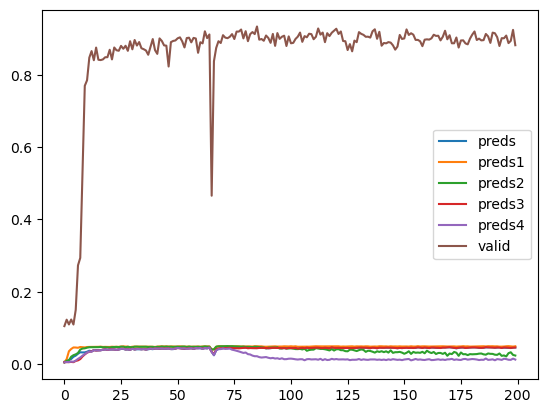

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

  0%|          | 0/200 [00:00<?, ?it/s]

***训练集***

main branch： 0.105

准确识别驾驶员： 0.09

无法准确识别驾驶员： 0.08625

准确识别行为： 0.10875

无法准确识别行为： 0.11125

flag1 0.09 flag2 0.10875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  0%|          | 1/200 [00:14<47:15, 14.25s/it]

valid-f1: 0.03967870941123372

valid-precision: 0.08773652195183392

valid-recall: 0.11058127458492095

process: 1  loss: 187.5584053993225  train_correct: 0.0 valid_loss 469.4359402656555  val_correct: 0.11923371647509579

The model has been saved!!

The best val_acc is  0.11923371647509579

***训练集***

main branch： 0.14625

准确识别驾驶员： 0.17375

无法准确识别驾驶员： 0.1375

准确识别行为： 0.1075

无法准确识别行为： 0.1225

flag1 0.17375 flag2 0.1075


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 2/200 [00:28<46:17, 14.03s/it]

valid-f1: 0.03756813961953977

valid-precision: 0.03462815690124491

valid-recall: 0.0953729416569621

process: 2  loss: 182.62789249420166  train_correct: 0.0 valid_loss 467.37154269218445  val_correct: 0.10436781609195403

***训练集***

main branch： 0.21125

准确识别驾驶员： 0.44625

无法准确识别驾驶员： 0.27625

准确识别行为： 0.11375

无法准确识别行为： 0.1175

flag1 0.44625 flag2 0.11375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 3/200 [00:42<46:20, 14.11s/it]

valid-f1: 0.02128348653050527

valid-precision: 0.014427625951105309

valid-recall: 0.10093167701863355

process: 3  loss: 161.02297639846802  train_correct: 0.0 valid_loss 468.64183354377747  val_correct: 0.10789272030651341

***训练集***

main branch： 0.3

准确识别驾驶员： 0.7675

无法准确识别驾驶员： 0.435

准确识别行为： 0.11625

无法准确识别行为： 0.13

flag1 0.7675 flag2 0.11625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 4/200 [00:56<45:41, 13.99s/it]

valid-f1: 0.03961057266783036

valid-precision: 0.07373461228216013

valid-recall: 0.08857790649031314

process: 4  loss: 129.68078470230103  train_correct: 0.0 valid_loss 467.662002325058  val_correct: 0.09072796934865901

***训练集***

main branch： 0.40125

准确识别驾驶员： 0.86875

无法准确识别驾驶员： 0.53375

准确识别行为： 0.13125

无法准确识别行为： 0.14125

flag1 0.86875 flag2 0.13125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▎         | 5/200 [01:10<45:37, 14.04s/it]

valid-f1: 0.019950331125827815

valid-precision: 0.011080459770114941

valid-recall: 0.1

process: 5  loss: 113.82851457595825  train_correct: 0.0 valid_loss 466.4913753271103  val_correct: 0.11080459770114942

***训练集***

main branch： 0.515

准确识别驾驶员： 0.915

无法准确识别驾驶员： 0.62125

准确识别行为： 0.17125

无法准确识别行为： 0.23125

flag1 0.915 flag2 0.17125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 6/200 [01:24<45:40, 14.13s/it]

valid-f1: 0.19980459206277185

valid-precision: 0.2632516964262548

valid-recall: 0.2689366728032666

process: 6  loss: 101.66434526443481  train_correct: 0.0 valid_loss 458.8224399089813  val_correct: 0.28

The model has been saved!!

The best val_acc is  0.28

***训练集***

main branch： 0.57625

准确识别驾驶员： 0.9375

无法准确识别驾驶员： 0.69875

准确识别行为： 0.25625

无法准确识别行为： 0.3075

flag1 0.9375 flag2 0.25625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 7/200 [01:38<45:36, 14.18s/it]

valid-f1: 0.1727302818727186

valid-precision: 0.18463352253643672

valid-recall: 0.2628479329099516

process: 7  loss: 93.00234389305115  train_correct: 0.0 valid_loss 445.30191242694855  val_correct: 0.2714176245210728

***训练集***

main branch： 0.6325

准确识别驾驶员： 0.94875

无法准确识别驾驶员： 0.8025

准确识别行为： 0.3225

无法准确识别行为： 0.3725

flag1 0.94875 flag2 0.3225


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 8/200 [01:53<45:26, 14.20s/it]

valid-f1: 0.2557951066087297

valid-precision: 0.448256396152626

valid-recall: 0.3058820477023447

process: 8  loss: 87.51896381378174  train_correct: 0.0 valid_loss 427.1958373785019  val_correct: 0.31724137931034485

The model has been saved!!

The best val_acc is  0.31724137931034485

***训练集***

main branch： 0.6575

准确识别驾驶员： 0.9325

无法准确识别驾驶员： 0.85625

准确识别行为： 0.41125

无法准确识别行为： 0.49125

flag1 0.9325 flag2 0.41125


  4%|▍         | 9/200 [02:07<45:21, 14.25s/it]

valid-f1: 0.6368330048530065

valid-precision: 0.7342444639529233

valid-recall: 0.6309748342719155

process: 9  loss: 82.126140832901  train_correct: 0.0 valid_loss 371.7830630540848  val_correct: 0.6456704980842912

The model has been saved!!

The best val_acc is  0.6456704980842912

***训练集***

main branch： 0.71625

准确识别驾驶员： 0.93875

无法准确识别驾驶员： 0.90625

准确识别行为： 0.58

无法准确识别行为： 0.6

flag1 0.93875 flag2 0.58


  5%|▌         | 10/200 [02:21<44:57, 14.20s/it]

valid-f1: 0.6456175072711547

valid-precision: 0.7574440246696135

valid-recall: 0.6651469962836678

process: 10  loss: 74.38835000991821  train_correct: 0.0 valid_loss 311.0984778404236  val_correct: 0.6821455938697318

The model has been saved!!

The best val_acc is  0.6821455938697318

***训练集***

main branch： 0.70375

准确识别驾驶员： 0.9375

无法准确识别驾驶员： 0.91

准确识别行为： 0.61625

无法准确识别行为： 0.6425

flag1 0.9375 flag2 0.61625


  6%|▌         | 11/200 [02:35<44:30, 14.13s/it]

valid-f1: 0.6430335916751478

valid-precision: 0.7395972493249445

valid-recall: 0.6630632218126139

process: 11  loss: 69.1474997997284  train_correct: 0.0 valid_loss 282.5187129378319  val_correct: 0.6720306513409962

***训练集***

main branch： 0.71125

准确识别驾驶员： 0.93375

无法准确识别驾驶员： 0.91625

准确识别行为： 0.68875

无法准确识别行为： 0.69625

flag1 0.93375 flag2 0.68875


  6%|▌         | 12/200 [02:49<44:29, 14.20s/it]

valid-f1: 0.7202511975637238

valid-precision: 0.7904687679585225

valid-recall: 0.7442814941139176

process: 12  loss: 61.17688179016113  train_correct: 0.0 valid_loss 213.28308671712875  val_correct: 0.7635249042145594

The model has been saved!!

The best val_acc is  0.7635249042145594

***训练集***

main branch： 0.735

准确识别驾驶员： 0.94125

无法准确识别驾驶员： 0.92875

准确识别行为： 0.71875

无法准确识别行为： 0.71875

flag1 0.94125 flag2 0.71875


  6%|▋         | 13/200 [03:03<44:00, 14.12s/it]

valid-f1: 0.7774322750742482

valid-precision: 0.8221143888675414

valid-recall: 0.7977584743430672

process: 13  loss: 53.96713638305664  train_correct: 0.0 valid_loss 160.98440127074718  val_correct: 0.8156321839080459

The model has been saved!!

The best val_acc is  0.8156321839080459

***训练集***

main branch： 0.7775

准确识别驾驶员： 0.94375

无法准确识别驾驶员： 0.9325

准确识别行为： 0.75125

无法准确识别行为： 0.75125

flag1 0.94375 flag2 0.75125


  7%|▋         | 14/200 [03:17<43:46, 14.12s/it]

valid-f1: 0.8211026506330918

valid-precision: 0.8340782946278777

valid-recall: 0.8206924768517881

process: 14  loss: 47.032758593559265  train_correct: 0.0 valid_loss 152.98356360197067  val_correct: 0.8298850574712644

The model has been saved!!

The best val_acc is  0.8298850574712644

***训练集***

main branch： 0.78375

准确识别驾驶员： 0.9325

无法准确识别驾驶员： 0.915

准确识别行为： 0.77375

无法准确识别行为： 0.7625

flag1 0.9325 flag2 0.77375


  8%|▊         | 15/200 [03:31<43:11, 14.01s/it]

valid-f1: 0.8460076631095148

valid-precision: 0.8631671864981396

valid-recall: 0.8497171197718053

process: 15  loss: 44.943963408470154  train_correct: 0.0 valid_loss 118.45266444981098  val_correct: 0.8628352490421456

The model has been saved!!

The best val_acc is  0.8628352490421456

***训练集***

main branch： 0.7425

准确识别驾驶员： 0.94

无法准确识别驾驶员： 0.9375

准确识别行为： 0.755

无法准确识别行为： 0.75

flag1 0.94 flag2 0.755


  8%|▊         | 16/200 [03:45<42:57, 14.01s/it]

valid-f1: 0.7951839424458125

valid-precision: 0.829090734260997

valid-recall: 0.8054815721425207

process: 16  loss: 45.743823647499084  train_correct: 0.0 valid_loss 128.267967838794  val_correct: 0.8140996168582375

***训练集***

main branch： 0.7575

准确识别驾驶员： 0.92875

无法准确识别驾驶员： 0.93

准确识别行为： 0.7675

无法准确识别行为： 0.75875

flag1 0.92875 flag2 0.7675


  8%|▊         | 17/200 [03:59<42:31, 13.94s/it]

valid-f1: 0.816193937133965

valid-precision: 0.8337134633538621

valid-recall: 0.8164997519539657

process: 17  loss: 43.77468866109848  train_correct: 0.0 valid_loss 129.3587492927909  val_correct: 0.8257471264367816

***训练集***

main branch： 0.795

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.94625

准确识别行为： 0.80625

无法准确识别行为： 0.7975

flag1 0.95875 flag2 0.80625


  9%|▉         | 18/200 [04:13<42:24, 13.98s/it]

valid-f1: 0.8792749704728487

valid-precision: 0.885508449821416

valid-recall: 0.8806857544420188

process: 18  loss: 37.718694627285004  train_correct: 0.0 valid_loss 100.58186119794846  val_correct: 0.8884291187739464

The model has been saved!!

The best val_acc is  0.8884291187739464

***训练集***

main branch： 0.79375

准确识别驾驶员： 0.95125

无法准确识别驾驶员： 0.9475

准确识别行为： 0.79

无法准确识别行为： 0.78875

flag1 0.95125 flag2 0.79


 10%|▉         | 19/200 [04:27<42:01, 13.93s/it]

valid-f1: 0.8554152979183627

valid-precision: 0.8574620920582191

valid-recall: 0.8585372870090918

process: 19  loss: 37.564639151096344  train_correct: 0.0 valid_loss 95.28181384503841  val_correct: 0.8628352490421456

***训练集***

main branch： 0.8325

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.94625

准确识别行为： 0.82

无法准确识别行为： 0.82375

flag1 0.96375 flag2 0.82


 10%|█         | 20/200 [04:41<41:36, 13.87s/it]

valid-f1: 0.8556388775804175

valid-precision: 0.8775640908469191

valid-recall: 0.8601543322300141

process: 20  loss: 33.1646266579628  train_correct: 0.0 valid_loss 92.73196027427912  val_correct: 0.8726436781609196

***训练集***

main branch： 0.7875

准确识别驾驶员： 0.95125

无法准确识别驾驶员： 0.90125

准确识别行为： 0.8

无法准确识别行为： 0.79

flag1 0.95125 flag2 0.8


 10%|█         | 21/200 [04:55<41:30, 13.92s/it]

valid-f1: 0.8495156419839562

valid-precision: 0.855784912630668

valid-recall: 0.849612633505927

process: 21  loss: 36.23184299468994  train_correct: 0.0 valid_loss 100.99064828455448  val_correct: 0.8602298850574712

***训练集***

main branch： 0.785

准确识别驾驶员： 0.95125

无法准确识别驾驶员： 0.94

准确识别行为： 0.79

无法准确识别行为： 0.7925

flag1 0.95125 flag2 0.79


 11%|█         | 22/200 [05:08<41:03, 13.84s/it]

valid-f1: 0.8764078880778797

valid-precision: 0.8848806711563352

valid-recall: 0.8770579748777303

process: 22  loss: 36.38562899827957  train_correct: 0.0 valid_loss 89.61778442189097  val_correct: 0.8853639846743295

***训练集***

main branch： 0.82375

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.9525

准确识别行为： 0.82875

无法准确识别行为： 0.8225

flag1 0.965 flag2 0.82875


 12%|█▏        | 23/200 [05:22<40:57, 13.88s/it]

valid-f1: 0.8538454324728258

valid-precision: 0.8733321634993162

valid-recall: 0.8576520433424468

process: 23  loss: 30.857132375240326  train_correct: 0.0 valid_loss 92.9912141840905  val_correct: 0.8704980842911877

***训练集***

main branch： 0.82875

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.945

准确识别行为： 0.81125

无法准确识别行为： 0.8225

flag1 0.95875 flag2 0.81125


 12%|█▏        | 24/200 [05:36<40:35, 13.84s/it]

valid-f1: 0.8504368172037022

valid-precision: 0.868437384415139

valid-recall: 0.8478356005416966

process: 24  loss: 32.15300917625427  train_correct: 0.0 valid_loss 104.33122362941504  val_correct: 0.8508812260536398

***训练集***

main branch： 0.79875

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.965

准确识别行为： 0.7975

无法准确识别行为： 0.79375

flag1 0.96375 flag2 0.7975


 12%|█▎        | 25/200 [05:50<40:32, 13.90s/it]

valid-f1: 0.8611033725434865

valid-precision: 0.8690083997840791

valid-recall: 0.8611426875289261

process: 25  loss: 36.26295882463455  train_correct: 0.0 valid_loss 92.64149870537221  val_correct: 0.8645210727969349

***训练集***

main branch： 0.835

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.95875

准确识别行为： 0.83375

无法准确识别行为： 0.83125

flag1 0.97 flag2 0.83375


 13%|█▎        | 26/200 [06:04<40:08, 13.84s/it]

valid-f1: 0.8648371720845711

valid-precision: 0.8753669843371492

valid-recall: 0.8667653770500902

process: 26  loss: 30.03597640991211  train_correct: 0.0 valid_loss 91.76328087598085  val_correct: 0.8726436781609196

***训练集***

main branch： 0.8325

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.95375

准确识别行为： 0.83125

无法准确识别行为： 0.83

flag1 0.96875 flag2 0.83125


 14%|█▎        | 27/200 [06:17<39:47, 13.80s/it]

valid-f1: 0.838196909205155

valid-precision: 0.8569202382016192

valid-recall: 0.8375100469221264

process: 27  loss: 29.880566656589508  train_correct: 0.0 valid_loss 105.66214679088444  val_correct: 0.8430651340996168

***训练集***

main branch： 0.83875

准确识别驾驶员： 0.95375

无法准确识别驾驶员： 0.9575

准确识别行为： 0.83125

无法准确识别行为： 0.83

flag1 0.95375 flag2 0.83125


 14%|█▍        | 28/200 [06:32<39:47, 13.88s/it]

valid-f1: 0.8607771081946007

valid-precision: 0.8788984008480991

valid-recall: 0.8618598101274841

process: 28  loss: 28.228821575641632  train_correct: 0.0 valid_loss 83.1400447152555  val_correct: 0.8738697318007663

***训练集***

main branch： 0.805

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.96

准确识别行为： 0.8225

无法准确识别行为： 0.80625

flag1 0.975 flag2 0.8225


 14%|█▍        | 29/200 [06:45<39:21, 13.81s/it]

valid-f1: 0.9027569424234692

valid-precision: 0.9064868454195155

valid-recall: 0.9022633802356512

process: 29  loss: 31.936436474323273  train_correct: 0.0 valid_loss 69.36508654616773  val_correct: 0.9062068965517242

The model has been saved!!

The best val_acc is  0.9062068965517242

***训练集***

main branch： 0.85

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.95

准确识别行为： 0.85875

无法准确识别行为： 0.84875

flag1 0.965 flag2 0.85875


 15%|█▌        | 30/200 [06:59<39:13, 13.84s/it]

valid-f1: 0.8786970310091528

valid-precision: 0.882984183994625

valid-recall: 0.878513328387941

process: 30  loss: 26.50429829955101  train_correct: 0.0 valid_loss 78.6622569244355  val_correct: 0.8855172413793103

***训练集***

main branch： 0.815

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.945

准确识别行为： 0.8225

无法准确识别行为： 0.8225

flag1 0.9625 flag2 0.8225


 16%|█▌        | 31/200 [07:13<38:44, 13.75s/it]

valid-f1: 0.8907829460036446

valid-precision: 0.894109316142103

valid-recall: 0.8913720840494559

process: 31  loss: 30.33025860786438  train_correct: 0.0 valid_loss 74.90309922862798  val_correct: 0.8951724137931034

***训练集***

main branch： 0.82875

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.93

准确识别行为： 0.83125

无法准确识别行为： 0.83

flag1 0.95875 flag2 0.83125


 16%|█▌        | 32/200 [07:26<38:32, 13.76s/it]

valid-f1: 0.8587892631030322

valid-precision: 0.8639395416480312

valid-recall: 0.8605261376153732

process: 32  loss: 30.810928106307983  train_correct: 0.0 valid_loss 92.25602825172246  val_correct: 0.8625287356321839

***训练集***

main branch： 0.82

准确识别驾驶员： 0.95125

无法准确识别驾驶员： 0.9275

准确识别行为： 0.83625

无法准确识别行为： 0.83125

flag1 0.95125 flag2 0.83625


 16%|█▋        | 33/200 [07:40<38:10, 13.72s/it]

valid-f1: 0.8951216685150042

valid-precision: 0.9078361085071103

valid-recall: 0.8928797249364155

process: 33  loss: 29.37123054265976  train_correct: 0.0 valid_loss 72.56354185659438  val_correct: 0.9025287356321839

***训练集***

main branch： 0.845

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.94625

准确识别行为： 0.845

无法准确识别行为： 0.86

flag1 0.96625 flag2 0.845


 17%|█▋        | 34/200 [07:54<38:08, 13.79s/it]

valid-f1: 0.8763992251565098

valid-precision: 0.895192510839405

valid-recall: 0.8739396630361513

process: 34  loss: 26.099925220012665  train_correct: 0.0 valid_loss 80.32889215089381  val_correct: 0.881992337164751

***训练集***

main branch： 0.835

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.95375

准确识别行为： 0.84125

无法准确识别行为： 0.84125

flag1 0.96375 flag2 0.84125


 18%|█▊        | 35/200 [08:08<37:52, 13.77s/it]

valid-f1: 0.8833020146216507

valid-precision: 0.8947515542513818

valid-recall: 0.8825259970144668

process: 35  loss: 27.068769991397858  train_correct: 0.0 valid_loss 75.98478196747601  val_correct: 0.8895019157088122

***训练集***

main branch： 0.8375

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.95625

准确识别行为： 0.845

无法准确识别行为： 0.835

flag1 0.96875 flag2 0.845


 18%|█▊        | 36/200 [08:21<37:34, 13.74s/it]

valid-f1: 0.868271926984208

valid-precision: 0.8810609626752054

valid-recall: 0.867853977670374

process: 36  loss: 27.878425747156143  train_correct: 0.0 valid_loss 92.77317870873958  val_correct: 0.8720306513409962

***训练集***

main branch： 0.84375

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.96375

准确识别行为： 0.85625

无法准确识别行为： 0.8525

flag1 0.9775 flag2 0.85625


 18%|█▊        | 37/200 [08:35<37:28, 13.80s/it]

valid-f1: 0.8800609213936574

valid-precision: 0.8918358839981323

valid-recall: 0.8769196941002096

process: 37  loss: 24.105919748544693  train_correct: 0.0 valid_loss 81.70283447951078  val_correct: 0.881072796934866

***训练集***

main branch： 0.8225

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.9625

准确识别行为： 0.83625

无法准确识别行为： 0.8175

flag1 0.96875 flag2 0.83625


 19%|█▉        | 38/200 [08:49<37:01, 13.71s/it]

valid-f1: 0.8936277095291654

valid-precision: 0.8989006646524305

valid-recall: 0.8940451955172202

process: 38  loss: 27.595065712928772  train_correct: 0.0 valid_loss 74.34753114543855  val_correct: 0.8948659003831417

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.955

准确识别行为： 0.86625

无法准确识别行为： 0.8625

flag1 0.9625 flag2 0.86625


 20%|█▉        | 39/200 [09:03<36:54, 13.75s/it]

valid-f1: 0.8810941018630466

valid-precision: 0.8868972600742724

valid-recall: 0.8808196857810607

process: 39  loss: 24.17816561460495  train_correct: 0.0 valid_loss 73.25448870286345  val_correct: 0.8821455938697318

***训练集***

main branch： 0.86

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.97625

准确识别行为： 0.8725

无法准确识别行为： 0.8625

flag1 0.97875 flag2 0.8725


 20%|██        | 40/200 [09:16<36:34, 13.71s/it]

valid-f1: 0.8786802552564194

valid-precision: 0.8859449323625496

valid-recall: 0.8779675528024352

process: 40  loss: 22.8947634100914  train_correct: 0.0 valid_loss 81.67818015627563  val_correct: 0.8841379310344828

***训练集***

main branch： 0.84375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.96625

准确识别行为： 0.84875

无法准确识别行为： 0.84125

flag1 0.98 flag2 0.84875


 20%|██        | 41/200 [09:30<36:27, 13.76s/it]

valid-f1: 0.9012157710581391

valid-precision: 0.9145792267071366

valid-recall: 0.8977972950795119

process: 41  loss: 25.619042813777924  train_correct: 0.0 valid_loss 68.1198146622628  val_correct: 0.9049808429118774

***训练集***

main branch： 0.83875

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.96

准确识别行为： 0.855

无法准确识别行为： 0.85375

flag1 0.9625 flag2 0.855


 21%|██        | 42/200 [09:44<36:05, 13.70s/it]

valid-f1: 0.8217806708349167

valid-precision: 0.8470471113794836

valid-recall: 0.8172359807796781

process: 42  loss: 24.115260064601898  train_correct: 0.0 valid_loss 119.68892713612877  val_correct: 0.8223754789272031

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.9625

准确识别行为： 0.8775

无法准确识别行为： 0.87375

flag1 0.975 flag2 0.8775


 22%|██▏       | 43/200 [09:57<35:52, 13.71s/it]

valid-f1: 0.8839666183234025

valid-precision: 0.9018861289885735

valid-recall: 0.8805528251244377

process: 43  loss: 21.64481744170189  train_correct: 0.0 valid_loss 71.16558002773672  val_correct: 0.8875095785440613

***训练集***

main branch： 0.86375

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.9675

准确识别行为： 0.86625

无法准确识别行为： 0.8575

flag1 0.97375 flag2 0.86625


 22%|██▏       | 44/200 [10:11<35:46, 13.76s/it]

valid-f1: 0.8990751433201275

valid-precision: 0.9098017097373774

valid-recall: 0.8970369357374549

process: 44  loss: 23.929533019661903  train_correct: 0.0 valid_loss 71.12273836135864  val_correct: 0.9008429118773946

***训练集***

main branch： 0.85875

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.94375

准确识别行为： 0.85375

无法准确识别行为： 0.85625

flag1 0.97125 flag2 0.85375


 22%|██▎       | 45/200 [10:25<35:30, 13.75s/it]

valid-f1: 0.9116249030748735

valid-precision: 0.9169479400181085

valid-recall: 0.9103174129897535

process: 45  loss: 26.266506612300873  train_correct: 0.0 valid_loss 64.81535039143637  val_correct: 0.9138697318007662

The model has been saved!!

The best val_acc is  0.9138697318007662

***训练集***

main branch： 0.8575

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.96125

准确识别行为： 0.8675

无法准确识别行为： 0.86125

flag1 0.9675 flag2 0.8675


 23%|██▎       | 46/200 [10:39<35:20, 13.77s/it]

valid-f1: 0.8933098391895088

valid-precision: 0.9028937625693114

valid-recall: 0.890690518515337

process: 46  loss: 22.778818428516388  train_correct: 0.0 valid_loss 74.097638821695  val_correct: 0.8980842911877395

***训练集***

main branch： 0.84875

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.95375

准确识别行为： 0.84625

无法准确识别行为： 0.85375

flag1 0.96 flag2 0.84625


 24%|██▎       | 47/200 [10:53<35:02, 13.74s/it]

valid-f1: 0.872371469102515

valid-precision: 0.8895827289129542

valid-recall: 0.8696421734130834

process: 47  loss: 26.239949226379395  train_correct: 0.0 valid_loss 88.61134993331507  val_correct: 0.8798467432950191

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.9725

准确识别行为： 0.88375

无法准确识别行为： 0.87625

flag1 0.98125 flag2 0.88375


 24%|██▍       | 48/200 [11:06<34:56, 13.79s/it]

valid-f1: 0.8853908091048428

valid-precision: 0.8868523075167266

valid-recall: 0.886571472079966

process: 48  loss: 21.118671655654907  train_correct: 0.0 valid_loss 70.29377899225801  val_correct: 0.8908812260536398

***训练集***

main branch： 0.86375

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.97125

准确识别行为： 0.875

无法准确识别行为： 0.8625

flag1 0.975 flag2 0.875


 24%|██▍       | 49/200 [11:20<34:33, 13.73s/it]

valid-f1: 0.9020702256203943

valid-precision: 0.904191110120139

valid-recall: 0.9032341878064413

process: 49  loss: 21.41989317536354  train_correct: 0.0 valid_loss 72.06059825979173  val_correct: 0.9045210727969348

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.9675

准确识别行为： 0.88125

无法准确识别行为： 0.88

flag1 0.98 flag2 0.88125


 25%|██▌       | 50/200 [11:34<34:18, 13.73s/it]

valid-f1: 0.9030543592395965

valid-precision: 0.9068774273921065

valid-recall: 0.9022186803272003

process: 50  loss: 20.87997615337372  train_correct: 0.0 valid_loss 69.70872947759926  val_correct: 0.9055938697318008

***训练集***

main branch： 0.8725

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.96125

准确识别行为： 0.8725

无法准确识别行为： 0.87

flag1 0.98 flag2 0.8725


 26%|██▌       | 51/200 [11:48<34:09, 13.75s/it]

valid-f1: 0.9002963055119071

valid-precision: 0.9135178225682216

valid-recall: 0.8972681826766795

process: 51  loss: 21.429129898548126  train_correct: 0.0 valid_loss 69.89644661778584  val_correct: 0.9063601532567049

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.96875

准确识别行为： 0.88

无法准确识别行为： 0.87875

flag1 0.975 flag2 0.88


 26%|██▌       | 52/200 [12:01<33:52, 13.73s/it]

valid-f1: 0.8981672616494872

valid-precision: 0.9068652334404638

valid-recall: 0.8968831519934387

process: 52  loss: 22.03798308968544  train_correct: 0.0 valid_loss 72.63186053512618  val_correct: 0.9037547892720307

***训练集***

main branch： 0.86375

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.95375

准确识别行为： 0.86875

无法准确识别行为： 0.87

flag1 0.9675 flag2 0.86875


 26%|██▋       | 53/200 [12:15<33:45, 13.78s/it]

valid-f1: 0.9049899286352965

valid-precision: 0.919551068967228

valid-recall: 0.9010770560640873

process: 53  loss: 21.972762942314148  train_correct: 0.0 valid_loss 69.99798924429342  val_correct: 0.9095785440613027

***训练集***

main branch： 0.85125

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.94125

准确识别行为： 0.86875

无法准确识别行为： 0.86375

flag1 0.96375 flag2 0.86875


 27%|██▋       | 54/200 [12:29<33:22, 13.71s/it]

valid-f1: 0.8713176498991716

valid-precision: 0.8783164401652084

valid-recall: 0.8723672628369306

process: 54  loss: 24.677699506282806  train_correct: 0.0 valid_loss 81.38301564892754  val_correct: 0.8806130268199234

***训练集***

main branch： 0.845

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.965

准确识别行为： 0.85375

无法准确识别行为： 0.85125

flag1 0.9725 flag2 0.85375


 28%|██▊       | 55/200 [12:43<33:15, 13.76s/it]

valid-f1: 0.8706804160631203

valid-precision: 0.8915900924781293

valid-recall: 0.8685111352064985

process: 55  loss: 23.620927274227142  train_correct: 0.0 valid_loss 79.32683287747204  val_correct: 0.8737164750957854

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.96

准确识别行为： 0.885

无法准确识别行为： 0.88875

flag1 0.975 flag2 0.885


 28%|██▊       | 56/200 [12:56<32:58, 13.74s/it]

valid-f1: 0.8934448513147026

valid-precision: 0.9043842558895229

valid-recall: 0.8916085423731648

process: 56  loss: 20.351240783929825  train_correct: 0.0 valid_loss 78.88809476979077  val_correct: 0.8948659003831417

***训练集***

main branch： 0.84125

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.97125

准确识别行为： 0.83875

无法准确识别行为： 0.84

flag1 0.96875 flag2 0.83875


 28%|██▊       | 57/200 [13:10<32:48, 13.76s/it]

valid-f1: 0.8850463086450157

valid-precision: 0.8984976408148624

valid-recall: 0.8824514011463995

process: 57  loss: 27.016372710466385  train_correct: 0.0 valid_loss 77.4965948574245  val_correct: 0.8836781609195402

***训练集***

main branch： 0.85

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.95875

准确识别行为： 0.86625

无法准确识别行为： 0.87

flag1 0.96 flag2 0.86625


 29%|██▉       | 58/200 [13:24<32:30, 13.74s/it]

valid-f1: 0.882142114355748

valid-precision: 0.9026662998388948

valid-recall: 0.8818388390834784

process: 58  loss: 24.20437827706337  train_correct: 0.0 valid_loss 77.42309569614008  val_correct: 0.89272030651341

***训练集***

main branch： 0.83375

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.965

准确识别行为： 0.83875

无法准确识别行为： 0.84125

flag1 0.97375 flag2 0.83875


 30%|██▉       | 59/200 [13:37<32:11, 13.70s/it]

valid-f1: 0.9129784374771551

valid-precision: 0.9177840444597141

valid-recall: 0.9110141648107912

process: 59  loss: 26.800916969776154  train_correct: 0.0 valid_loss 58.875856816768646  val_correct: 0.9166283524904214

The model has been saved!!

The best val_acc is  0.9166283524904214

***训练集***

main branch： 0.8475

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.94875

准确识别行为： 0.865

无法准确识别行为： 0.85375

flag1 0.965 flag2 0.865


 30%|███       | 60/200 [13:51<32:07, 13.76s/it]

valid-f1: 0.8890305545703804

valid-precision: 0.8939487830714257

valid-recall: 0.8900338940616914

process: 60  loss: 23.734658882021904  train_correct: 0.0 valid_loss 64.81207638373598  val_correct: 0.8928735632183908

***训练集***

main branch： 0.87125

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.9675

准确识别行为： 0.89125

无法准确识别行为： 0.87875

flag1 0.9775 flag2 0.89125


 30%|███       | 61/200 [14:05<31:44, 13.70s/it]

valid-f1: 0.9093963484088319

valid-precision: 0.9132080361507219

valid-recall: 0.9099278499196813

process: 61  loss: 19.612902611494064  train_correct: 0.0 valid_loss 66.023213095963  val_correct: 0.9146360153256705

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.97

准确识别行为： 0.88375

无法准确识别行为： 0.89125

flag1 0.97625 flag2 0.88375


 31%|███       | 62/200 [14:19<31:35, 13.74s/it]

valid-f1: 0.9046654161611125

valid-precision: 0.9113235767785426

valid-recall: 0.9036298954548503

process: 62  loss: 22.018796384334564  train_correct: 0.0 valid_loss 66.97989698708989  val_correct: 0.9089655172413793

***训练集***

main branch： 0.86375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.97125

准确识别行为： 0.86375

无法准确识别行为： 0.865

flag1 0.98 flag2 0.86375


 32%|███▏      | 63/200 [14:32<31:20, 13.73s/it]

valid-f1: 0.8726238525606244

valid-precision: 0.8947886496847908

valid-recall: 0.8721495645337815

process: 63  loss: 22.758244276046753  train_correct: 0.0 valid_loss 80.19630422443151  val_correct: 0.8801532567049808

***训练集***

main branch： 0.875

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.98375

准确识别行为： 0.87875

无法准确识别行为： 0.87375

flag1 0.985 flag2 0.87875


 32%|███▏      | 64/200 [14:46<31:13, 13.78s/it]

valid-f1: 0.9219550817009798

valid-precision: 0.9295389622264351

valid-recall: 0.9195441147962435

process: 64  loss: 19.702434539794922  train_correct: 0.0 valid_loss 58.99775175284594  val_correct: 0.9264367816091954

The model has been saved!!

The best val_acc is  0.9264367816091954

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.97375

准确识别行为： 0.905

无法准确识别行为： 0.90375

flag1 0.9825 flag2 0.905

预热结束


 32%|███▎      | 65/200 [15:00<30:55, 13.74s/it]

valid-f1: 0.8609562112648605

valid-precision: 0.8774211421434313

valid-recall: 0.8585982025822713

process: 65  loss: 16.5973731726408  train_correct: 0.0 valid_loss 96.7800465276232  val_correct: 0.8668199233716475

***训练集***

main branch： 0.7525

准确识别驾驶员： 0.91375

无法准确识别驾驶员： 0.9075

准确识别行为： 0.7425

无法准确识别行为： 0.75375

flag1 0.91375 flag2 0.7425


 33%|███▎      | 66/200 [15:14<30:38, 13.72s/it]

valid-f1: 0.6197305833494725

valid-precision: 0.7702610200123132

valid-recall: 0.6266019337139153

process: 66  loss: 292.5925073623657  train_correct: 0.0 valid_loss 261.29605239629745  val_correct: 0.6363218390804598

***训练集***

main branch： 0.69375

准确识别驾驶员： 0.9275

无法准确识别驾驶员： 0.92625

准确识别行为： 0.735

无法准确识别行为： 0.66625

flag1 0.9275 flag2 0.735


 34%|███▎      | 67/200 [15:28<30:39, 13.83s/it]

valid-f1: 0.828504621163504

valid-precision: 0.8583416643066212

valid-recall: 0.8253672893703555

process: 67  loss: 115.79948925971985  train_correct: 0.0 valid_loss 172.71684929728508  val_correct: 0.8338697318007663

***训练集***

main branch： 0.87

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.985

准确识别行为： 0.87875

无法准确识别行为： 0.85625

flag1 0.98375 flag2 0.87875


 34%|███▍      | 68/200 [15:41<30:24, 13.82s/it]

valid-f1: 0.8474254650611595

valid-precision: 0.8644945308613297

valid-recall: 0.845665198624264

process: 68  loss: 96.1237564086914  train_correct: 0.0 valid_loss 175.31080305576324  val_correct: 0.8527203065134099

***训练集***

main branch： 0.87125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.9775

准确识别行为： 0.895

无法准确识别行为： 0.89

flag1 0.97875 flag2 0.895


 34%|███▍      | 69/200 [15:55<30:16, 13.86s/it]

valid-f1: 0.8839137890526431

valid-precision: 0.8880145273235373

valid-recall: 0.8840821573405927

process: 69  loss: 87.12884211540222  train_correct: 0.0 valid_loss 175.91214841604233  val_correct: 0.8888888888888888

***训练集***

main branch： 0.88

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.9875

准确识别行为： 0.89375

无法准确识别行为： 0.88625

flag1 0.98625 flag2 0.89375


 35%|███▌      | 70/200 [16:09<29:58, 13.84s/it]

valid-f1: 0.8991883435345203

valid-precision: 0.9059123939632127

valid-recall: 0.8985957856200912

process: 70  loss: 79.60871767997742  train_correct: 0.0 valid_loss 175.41924291849136  val_correct: 0.9048275862068965

***训练集***

main branch： 0.885

准确识别驾驶员： 0.995

无法准确识别驾驶员： 0.99625

准确识别行为： 0.8975

无法准确识别行为： 0.89125

flag1 0.995 flag2 0.8975


 36%|███▌      | 71/200 [16:23<29:48, 13.86s/it]

valid-f1: 0.8838032200673664

valid-precision: 0.9017780568769813

valid-recall: 0.8844224955272264

process: 71  loss: 72.34647393226624  train_correct: 0.0 valid_loss 175.6435203552246  val_correct: 0.8942528735632184

***训练集***

main branch： 0.885

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.98375

准确识别行为： 0.89625

无法准确识别行为： 0.8775

flag1 0.98 flag2 0.89625


 36%|███▌      | 72/200 [16:37<29:29, 13.82s/it]

valid-f1: 0.8841003719846624

valid-precision: 0.8991560253708597

valid-recall: 0.8855916438927416

process: 72  loss: 65.8914520740509  train_correct: 0.0 valid_loss 184.12674421072006  val_correct: 0.8944061302681993

***训练集***

main branch： 0.905

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.99125

准确识别行为： 0.89375

无法准确识别行为： 0.8675

flag1 0.99 flag2 0.89375


 36%|███▋      | 73/200 [16:51<29:25, 13.90s/it]

valid-f1: 0.9034879443409067

valid-precision: 0.9142287332368809

valid-recall: 0.9013079804370345

process: 73  loss: 59.5812623500824  train_correct: 0.0 valid_loss 189.2545623779297  val_correct: 0.9094252873563219

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.99125

准确识别行为： 0.895

无法准确识别行为： 0.86125

flag1 0.98625 flag2 0.895


 37%|███▋      | 74/200 [17:05<29:07, 13.87s/it]

valid-f1: 0.9028244933239623

valid-precision: 0.9084051393146039

valid-recall: 0.9019633633254204

process: 74  loss: 55.89247107505798  train_correct: 0.0 valid_loss 190.86941596865654  val_correct: 0.9088122605363985

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.98875

准确识别行为： 0.9025

无法准确识别行为： 0.8225

flag1 0.99 flag2 0.9025


 38%|███▊      | 75/200 [17:19<28:50, 13.85s/it]

valid-f1: 0.914776054326379

valid-precision: 0.9194014130944526

valid-recall: 0.9130918044817278

process: 75  loss: 52.41559135913849  train_correct: 0.0 valid_loss 164.26332294940948  val_correct: 0.919080459770115

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.9725

准确识别行为： 0.895

无法准确识别行为： 0.8275

flag1 0.9725 flag2 0.895


 38%|███▊      | 76/200 [17:33<28:50, 13.95s/it]

valid-f1: 0.906097303748789

valid-precision: 0.9201730485490854

valid-recall: 0.9067122666383334

process: 76  loss: 49.40736937522888  train_correct: 0.0 valid_loss 175.56655710935593  val_correct: 0.9154022988505747

***训练集***

main branch： 0.915

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.98

准确识别行为： 0.89375

无法准确识别行为： 0.7825

flag1 0.99 flag2 0.89375


 38%|███▊      | 77/200 [17:46<28:26, 13.87s/it]

valid-f1: 0.8680873348917235

valid-precision: 0.8873115107053998

valid-recall: 0.8673268185161618

process: 77  loss: 46.16122615337372  train_correct: 0.0 valid_loss 176.12753960490227  val_correct: 0.8731034482758621

***训练集***

main branch： 0.895

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.9675

准确识别行为： 0.88125

无法准确识别行为： 0.72

flag1 0.975 flag2 0.88125


 39%|███▉      | 78/200 [18:00<28:20, 13.94s/it]

valid-f1: 0.8847912599495771

valid-precision: 0.8921427626498749

valid-recall: 0.8853154123717365

process: 78  loss: 45.93678796291351  train_correct: 0.0 valid_loss 165.78793010115623  val_correct: 0.8873563218390804

***训练集***

main branch： 0.905

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.975

准确识别行为： 0.88375

无法准确识别行为： 0.71125

flag1 0.97875 flag2 0.88375


 40%|███▉      | 79/200 [18:14<27:58, 13.87s/it]

valid-f1: 0.897417079437943

valid-precision: 0.905098652948445

valid-recall: 0.896160533408284

process: 79  loss: 43.21886873245239  train_correct: 0.0 valid_loss 156.8043610751629  val_correct: 0.9020689655172414

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.97125

准确识别行为： 0.885

无法准确识别行为： 0.63625

flag1 0.98125 flag2 0.885


 40%|████      | 80/200 [18:28<27:50, 13.92s/it]

valid-f1: 0.8543422909308844

valid-precision: 0.8846915310645134

valid-recall: 0.8584747192518158

process: 80  loss: 42.34300708770752  train_correct: 0.0 valid_loss 157.3320875763893  val_correct: 0.8704980842911877

***训练集***

main branch： 0.9225

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.96125

准确识别行为： 0.9125

无法准确识别行为： 0.665

flag1 0.97875 flag2 0.9125


 40%|████      | 81/200 [18:42<27:33, 13.89s/it]

valid-f1: 0.8931391339581045

valid-precision: 0.9119426574588225

valid-recall: 0.8908763841780638

process: 81  loss: 38.00105619430542  train_correct: 0.0 valid_loss 144.29206904768944  val_correct: 0.9019157088122606

***训练集***

main branch： 0.895

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.96375

准确识别行为： 0.89125

无法准确识别行为： 0.59

flag1 0.98 flag2 0.89125


 41%|████      | 82/200 [18:56<27:23, 13.93s/it]

valid-f1: 0.8901844984115049

valid-precision: 0.9026913220806799

valid-recall: 0.8907181072355936

process: 82  loss: 38.766785740852356  train_correct: 0.0 valid_loss 129.1290289759636  val_correct: 0.8993103448275862

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.97125

准确识别行为： 0.88375

无法准确识别行为： 0.535

flag1 0.9875 flag2 0.88375


 42%|████▏     | 83/200 [19:10<27:08, 13.92s/it]

valid-f1: 0.9078495820982916

valid-precision: 0.9193331351859552

valid-recall: 0.9074596171824979

process: 83  loss: 37.46347188949585  train_correct: 0.0 valid_loss 100.08828161656857  val_correct: 0.9163218390804597

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.93875

准确识别行为： 0.88

无法准确识别行为： 0.51875

flag1 0.9725 flag2 0.88


 42%|████▏     | 84/200 [19:24<26:53, 13.91s/it]

valid-f1: 0.8681675988643576

valid-precision: 0.8910053672871519

valid-recall: 0.8665046034281685

process: 84  loss: 38.094051241874695  train_correct: 0.0 valid_loss 131.44596382975578  val_correct: 0.8754022988505747

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.945

准确识别行为： 0.88375

无法准确识别行为： 0.495

flag1 0.98 flag2 0.88375


 42%|████▎     | 85/200 [19:38<26:49, 14.00s/it]

valid-f1: 0.9008532306732902

valid-precision: 0.915708751287507

valid-recall: 0.8997917326839895

process: 85  loss: 35.66577970981598  train_correct: 0.0 valid_loss 111.37436284124851  val_correct: 0.9085057471264368

***训练集***

main branch： 0.9

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.935

准确识别行为： 0.8925

无法准确识别行为： 0.46125

flag1 0.97375 flag2 0.8925


 43%|████▎     | 86/200 [19:52<26:34, 13.98s/it]

valid-f1: 0.8956115505332246

valid-precision: 0.9033211107960215

valid-recall: 0.8938031450574835

process: 86  loss: 34.16638994216919  train_correct: 0.0 valid_loss 103.12046827375889  val_correct: 0.9013026819923372

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.95125

准确识别行为： 0.89125

无法准确识别行为： 0.44875

flag1 0.9825 flag2 0.89125


 44%|████▎     | 87/200 [20:06<26:23, 14.02s/it]

valid-f1: 0.9012863958483864

valid-precision: 0.9215433956876862

valid-recall: 0.8983149485218578

process: 87  loss: 32.95782405138016  train_correct: 0.0 valid_loss 98.80815982818604  val_correct: 0.9085057471264368

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.9425

准确识别行为： 0.895

无法准确识别行为： 0.40875

flag1 0.97875 flag2 0.895


 44%|████▍     | 88/200 [20:20<26:06, 13.98s/it]

valid-f1: 0.8972431948898096

valid-precision: 0.9077979168440292

valid-recall: 0.8961881917634222

process: 88  loss: 31.54050362110138  train_correct: 0.0 valid_loss 97.30288863182068  val_correct: 0.9042145593869731

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.92125

准确识别行为： 0.9025

无法准确识别行为： 0.415

flag1 0.97625 flag2 0.9025


 44%|████▍     | 89/200 [20:34<26:01, 14.07s/it]

valid-f1: 0.8800518652864773

valid-precision: 0.8878910306635209

valid-recall: 0.8778608292144403

process: 89  loss: 30.261736750602722  train_correct: 0.0 valid_loss 104.93905279040337  val_correct: 0.8826053639846744

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.9375

准确识别行为： 0.87625

无法准确识别行为： 0.36875

flag1 0.9725 flag2 0.87625


 45%|████▌     | 90/200 [20:48<25:41, 14.01s/it]

valid-f1: 0.8849673044059259

valid-precision: 0.9009352223994174

valid-recall: 0.8852930507610626

process: 90  loss: 32.64938938617706  train_correct: 0.0 valid_loss 96.89592784643173  val_correct: 0.8937931034482759

***训练集***

main branch： 0.88

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.94

准确识别行为： 0.87625

无法准确识别行为： 0.37875

flag1 0.98 flag2 0.87625


 46%|████▌     | 91/200 [21:02<25:29, 14.04s/it]

valid-f1: 0.8354407294218211

valid-precision: 0.8727022282852135

valid-recall: 0.8331390743843254

process: 91  loss: 33.00149041414261  train_correct: 0.0 valid_loss 112.29399947077036  val_correct: 0.842911877394636

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.9225

准确识别行为： 0.8825

无法准确识别行为： 0.3775

flag1 0.97875 flag2 0.8825


 46%|████▌     | 92/200 [21:16<25:11, 14.00s/it]

valid-f1: 0.8747181812431049

valid-precision: 0.8924887853129233

valid-recall: 0.8745118523811662

process: 92  loss: 31.24254083633423  train_correct: 0.0 valid_loss 91.16325554996729  val_correct: 0.8841379310344828

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.895

准确识别行为： 0.88125

无法准确识别行为： 0.345

flag1 0.9675 flag2 0.88125


 46%|████▋     | 93/200 [21:30<24:54, 13.97s/it]

valid-f1: 0.8917305230168694

valid-precision: 0.9063330806599046

valid-recall: 0.8880905811814849

process: 93  loss: 33.24003839492798  train_correct: 0.0 valid_loss 90.41183365881443  val_correct: 0.8962452107279694

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.89125

准确识别行为： 0.91

无法准确识别行为： 0.35375

flag1 0.97625 flag2 0.91


 47%|████▋     | 94/200 [21:44<24:51, 14.07s/it]

valid-f1: 0.8921977963831912

valid-precision: 0.9005644169741371

valid-recall: 0.8920211585572124

process: 94  loss: 27.77713119983673  train_correct: 0.0 valid_loss 80.18841527402401  val_correct: 0.8991570881226054

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.9175

准确识别行为： 0.88625

无法准确识别行为： 0.31

flag1 0.97625 flag2 0.88625


 48%|████▊     | 95/200 [21:58<24:31, 14.01s/it]

valid-f1: 0.8676352746646095

valid-precision: 0.8882261143158816

valid-recall: 0.8644411741513318

process: 95  loss: 29.27622526884079  train_correct: 0.0 valid_loss 98.79064882546663  val_correct: 0.874176245210728

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.90875

准确识别行为： 0.9

无法准确识别行为： 0.34875

flag1 0.965 flag2 0.9


 48%|████▊     | 96/200 [22:12<24:20, 14.04s/it]

valid-f1: 0.9161609890355518

valid-precision: 0.9189445516505286

valid-recall: 0.9160185881567136

process: 96  loss: 29.132101476192474  train_correct: 0.0 valid_loss 69.23808941245079  val_correct: 0.9198467432950191

***训练集***

main branch： 0.92875

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.9125

准确识别行为： 0.92125

无法准确识别行为： 0.355

flag1 0.98375 flag2 0.92125


 48%|████▊     | 97/200 [22:26<23:59, 13.98s/it]

valid-f1: 0.8926934694805491

valid-precision: 0.9042461955262098

valid-recall: 0.8905123600567736

process: 97  loss: 23.05627930164337  train_correct: 0.0 valid_loss 79.78854874521494  val_correct: 0.8959386973180077

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.885

准确识别行为： 0.88875

无法准确识别行为： 0.32375

flag1 0.975 flag2 0.88875


 49%|████▉     | 98/200 [22:40<23:52, 14.05s/it]

valid-f1: 0.9007223001192088

valid-precision: 0.9105424638209364

valid-recall: 0.8989486500317889

process: 98  loss: 26.84181410074234  train_correct: 0.0 valid_loss 71.20662074163556  val_correct: 0.9077394636015326

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.88625

准确识别行为： 0.9

无法准确识别行为： 0.2875

flag1 0.97875 flag2 0.9


 50%|████▉     | 99/200 [22:54<23:35, 14.02s/it]

valid-f1: 0.8509697955581151

valid-precision: 0.8750714930314052

valid-recall: 0.8490968290380385

process: 99  loss: 27.34807538986206  train_correct: 0.0 valid_loss 96.10657401382923  val_correct: 0.8574712643678161

***训练集***

main branch： 0.905

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.865

准确识别行为： 0.8975

无法准确识别行为： 0.29

flag1 0.9775 flag2 0.8975


 50%|█████     | 100/200 [23:09<23:27, 14.08s/it]

valid-f1: 0.8912790553952605

valid-precision: 0.906203842351508

valid-recall: 0.8887970926488379

process: 100  loss: 25.8401398062706  train_correct: 0.0 valid_loss 76.07214771583676  val_correct: 0.8990038314176245

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.88

准确识别行为： 0.89625

无法准确识别行为： 0.2875

flag1 0.965 flag2 0.89625


 50%|█████     | 101/200 [23:22<23:07, 14.01s/it]

valid-f1: 0.8935814077201464

valid-precision: 0.8957594402021222

valid-recall: 0.8944078854531196

process: 101  loss: 26.50313711166382  train_correct: 0.0 valid_loss 76.8241866119206  val_correct: 0.8976245210727969

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.84

准确识别行为： 0.8775

无法准确识别行为： 0.29125

flag1 0.96375 flag2 0.8775


 51%|█████     | 102/200 [23:36<22:51, 14.00s/it]

valid-f1: 0.8957434428594503

valid-precision: 0.9031639306117109

valid-recall: 0.8943567689806551

process: 102  loss: 30.447046041488647  train_correct: 0.0 valid_loss 85.80883847177029  val_correct: 0.901455938697318

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.85875

准确识别行为： 0.89375

无法准确识别行为： 0.30125

flag1 0.96875 flag2 0.89375


 52%|█████▏    | 103/200 [23:51<22:46, 14.09s/it]

valid-f1: 0.906408378028382

valid-precision: 0.9096287512013239

valid-recall: 0.9065292907486361

process: 103  loss: 29.3065447807312  train_correct: 0.0 valid_loss 73.14567295461893  val_correct: 0.9127969348659004

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.8525

准确识别行为： 0.88875

无法准确识别行为： 0.2825

flag1 0.97625 flag2 0.88875


 52%|█████▏    | 104/200 [24:05<22:28, 14.04s/it]

valid-f1: 0.8827359489473485

valid-precision: 0.8952588054444105

valid-recall: 0.8795700202853951

process: 104  loss: 28.485949158668518  train_correct: 0.0 valid_loss 91.8992565125227  val_correct: 0.888735632183908

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.83875

准确识别行为： 0.8925

无法准确识别行为： 0.2925

flag1 0.97125 flag2 0.8925


 52%|█████▎    | 105/200 [24:19<22:18, 14.09s/it]

valid-f1: 0.8924949961569721

valid-precision: 0.8990637903276362

valid-recall: 0.8946249393700955

process: 105  loss: 26.08554434776306  train_correct: 0.0 valid_loss 77.70868793874979  val_correct: 0.8959386973180077

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.85875

准确识别行为： 0.89125

无法准确识别行为： 0.2825

flag1 0.975 flag2 0.89125


 53%|█████▎    | 106/200 [24:33<22:00, 14.05s/it]

valid-f1: 0.8717089064375759

valid-precision: 0.8794174998209158

valid-recall: 0.8732904448533135

process: 106  loss: 25.88672125339508  train_correct: 0.0 valid_loss 89.9755433127284  val_correct: 0.8757088122605364

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.82625

准确识别行为： 0.915

无法准确识别行为： 0.275

flag1 0.9725 flag2 0.915


 54%|█████▎    | 107/200 [24:47<21:52, 14.11s/it]

valid-f1: 0.92157279119268

valid-precision: 0.9320735110563982

valid-recall: 0.9195209414659977

process: 107  loss: 23.418432474136353  train_correct: 0.0 valid_loss 66.57012437656522  val_correct: 0.9272030651340997

The model has been saved!!

The best val_acc is  0.9272030651340997

***训练集***

main branch： 0.915

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.835

准确识别行为： 0.90375

无法准确识别行为： 0.27

flag1 0.97875 flag2 0.90375


 54%|█████▍    | 108/200 [25:01<21:35, 14.08s/it]

valid-f1: 0.9189832608602323

valid-precision: 0.9248782861568777

valid-recall: 0.9174228826001787

process: 108  loss: 22.927268087863922  train_correct: 0.0 valid_loss 63.99318678304553  val_correct: 0.9236781609195402

***训练集***

main branch： 0.885

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.87125

准确识别行为： 0.88625

无法准确识别行为： 0.28

flag1 0.97875 flag2 0.88625


 55%|█████▍    | 109/200 [25:15<21:26, 14.13s/it]

valid-f1: 0.8855200273202228

valid-precision: 0.922452305089628

valid-recall: 0.8855011863926734

process: 109  loss: 25.44686257839203  train_correct: 0.0 valid_loss 78.59801073744893  val_correct: 0.8985440613026819

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.87

准确识别行为： 0.88125

无法准确识别行为： 0.25625

flag1 0.98625 flag2 0.88125


 55%|█████▌    | 110/200 [25:29<21:08, 14.10s/it]

valid-f1: 0.9013286184163277

valid-precision: 0.9164437392954798

valid-recall: 0.8964475846617912

process: 110  loss: 25.32811665534973  train_correct: 0.0 valid_loss 75.9672285579145  val_correct: 0.9031417624521073

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.90625

准确识别行为： 0.8925

无法准确识别行为： 0.2925

flag1 0.98125 flag2 0.8925


 56%|█████▌    | 111/200 [25:43<20:51, 14.06s/it]

valid-f1: 0.9140237609709363

valid-precision: 0.924356393796973

valid-recall: 0.9113524428367736

process: 111  loss: 24.788083016872406  train_correct: 0.0 valid_loss 62.85181846097112  val_correct: 0.9177011494252874

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.86625

准确识别行为： 0.89125

无法准确识别行为： 0.25875

flag1 0.9825 flag2 0.89125


 56%|█████▌    | 112/200 [25:58<20:43, 14.13s/it]

valid-f1: 0.9054069109538746

valid-precision: 0.9127608216181864

valid-recall: 0.9045190581832641

process: 112  loss: 25.09987074136734  train_correct: 0.0 valid_loss 70.43920705094934  val_correct: 0.9098850574712644

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.81

准确识别行为： 0.89875

无法准确识别行为： 0.30375

flag1 0.96375 flag2 0.89875


 56%|█████▋    | 113/200 [26:11<20:23, 14.06s/it]

valid-f1: 0.8777161637870867

valid-precision: 0.8894606594643157

valid-recall: 0.8807585243039983

process: 113  loss: 25.911618053913116  train_correct: 0.0 valid_loss 77.91024948656559  val_correct: 0.8809195402298851

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.805

准确识别行为： 0.90625

无法准确识别行为： 0.26125

flag1 0.97875 flag2 0.90625


 57%|█████▋    | 114/200 [26:26<20:12, 14.10s/it]

valid-f1: 0.9117827793241796

valid-precision: 0.9175908974443937

valid-recall: 0.9088651585367785

process: 114  loss: 23.379519283771515  train_correct: 0.0 valid_loss 66.48298364132643  val_correct: 0.9134099616858238

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.84625

准确识别行为： 0.8975

无法准确识别行为： 0.2975

flag1 0.9875 flag2 0.8975


 57%|█████▊    | 115/200 [26:40<19:52, 14.03s/it]

valid-f1: 0.912609906250248

valid-precision: 0.9138857081903204

valid-recall: 0.9130020842301592

process: 115  loss: 23.016527712345123  train_correct: 0.0 valid_loss 63.504063395783305  val_correct: 0.9172413793103448

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.83875

准确识别行为： 0.9075

无法准确识别行为： 0.22

flag1 0.9775 flag2 0.9075


 58%|█████▊    | 116/200 [26:54<19:42, 14.08s/it]

valid-f1: 0.876385257436256

valid-precision: 0.9030224518007461

valid-recall: 0.876781457264018

process: 116  loss: 22.862000226974487  train_correct: 0.0 valid_loss 81.7690582536161  val_correct: 0.8870498084291187

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.81625

准确识别行为： 0.885

无法准确识别行为： 0.22625

flag1 0.97875 flag2 0.885


 58%|█████▊    | 117/200 [27:08<19:21, 13.99s/it]

valid-f1: 0.8905277598153678

valid-precision: 0.8996633301221107

valid-recall: 0.8897819317414427

process: 117  loss: 24.34124729037285  train_correct: 0.0 valid_loss 80.56835355423391  val_correct: 0.8934865900383142

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.8175

准确识别行为： 0.88625

无法准确识别行为： 0.26875

flag1 0.975 flag2 0.88625


 59%|█████▉    | 118/200 [27:22<19:13, 14.07s/it]

valid-f1: 0.8688995384324585

valid-precision: 0.9004262884362999

valid-recall: 0.8706170618298884

process: 118  loss: 25.764974296092987  train_correct: 0.0 valid_loss 84.63450413197279  val_correct: 0.8833716475095785

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.7775

准确识别行为： 0.9075

无法准确识别行为： 0.29375

flag1 0.965 flag2 0.9075


 60%|█████▉    | 119/200 [27:36<18:55, 14.02s/it]

valid-f1: 0.9135365358406838

valid-precision: 0.9221702918737302

valid-recall: 0.9109772234392345

process: 119  loss: 24.328034311532974  train_correct: 0.0 valid_loss 62.14468804188073  val_correct: 0.918007662835249

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.7575

准确识别行为： 0.88625

无法准确识别行为： 0.24125

flag1 0.975 flag2 0.88625


 60%|██████    | 120/200 [27:50<18:40, 14.01s/it]

valid-f1: 0.892584231777613

valid-precision: 0.9017280872906639

valid-recall: 0.8915732459088079

process: 120  loss: 24.728082060813904  train_correct: 0.0 valid_loss 78.34188502654433  val_correct: 0.8963984674329502

***训练集***

main branch： 0.885

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.83375

准确识别行为： 0.88875

无法准确识别行为： 0.255

flag1 0.97875 flag2 0.88875


 60%|██████    | 121/200 [28:04<18:34, 14.11s/it]

valid-f1: 0.8983594177012373

valid-precision: 0.9093252217370706

valid-recall: 0.8956205820282079

process: 121  loss: 24.21992927789688  train_correct: 0.0 valid_loss 66.81079228594899  val_correct: 0.9036015325670498

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.8275

准确识别行为： 0.88125

无法准确识别行为： 0.24875

flag1 0.98 flag2 0.88125


 61%|██████    | 122/200 [28:18<18:15, 14.05s/it]

valid-f1: 0.8652770385311197

valid-precision: 0.8896592213437516

valid-recall: 0.8636086939125501

process: 122  loss: 24.941198110580444  train_correct: 0.0 valid_loss 88.74364339187741  val_correct: 0.870191570881226

***训练集***

main branch： 0.8725

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.7525

准确识别行为： 0.87125

无法准确识别行为： 0.22375

flag1 0.97375 flag2 0.87125


 62%|██████▏   | 123/200 [28:32<18:03, 14.08s/it]

valid-f1: 0.8901288973990962

valid-precision: 0.8983611474114215

valid-recall: 0.8893725255201668

process: 123  loss: 26.757641851902008  train_correct: 0.0 valid_loss 75.87969262525439  val_correct: 0.8944061302681993

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.815

准确识别行为： 0.9025

无法准确识别行为： 0.30875

flag1 0.9725 flag2 0.9025


 62%|██████▏   | 124/200 [28:46<17:46, 14.03s/it]

valid-f1: 0.9256395398093165

valid-precision: 0.929801468578934

valid-recall: 0.9241774119443764

process: 124  loss: 22.903497993946075  train_correct: 0.0 valid_loss 57.24666832014918  val_correct: 0.9298084291187739

The model has been saved!!

The best val_acc is  0.9298084291187739

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.7675

准确识别行为： 0.9075

无法准确识别行为： 0.25

flag1 0.98 flag2 0.9075


 62%|██████▎   | 125/200 [29:00<17:37, 14.10s/it]

valid-f1: 0.9120804019668224

valid-precision: 0.9142331408918659

valid-recall: 0.9127891184935273

process: 125  loss: 21.59090483188629  train_correct: 0.0 valid_loss 61.51132494211197  val_correct: 0.9158620689655173

***训练集***

main branch： 0.9

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.83375

准确识别行为： 0.8975

无法准确识别行为： 0.23375

flag1 0.97625 flag2 0.8975


 63%|██████▎   | 126/200 [29:14<17:19, 14.05s/it]

valid-f1: 0.9118887564451352

valid-precision: 0.9141610224927167

valid-recall: 0.9127716681299518

process: 126  loss: 23.483426332473755  train_correct: 0.0 valid_loss 59.853040585294366  val_correct: 0.9155555555555556

***训练集***

main branch： 0.93125

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.7575

准确识别行为： 0.92625

无法准确识别行为： 0.26625

flag1 0.9875 flag2 0.92625


 64%|██████▎   | 127/200 [29:28<17:07, 14.08s/it]

valid-f1: 0.9024373797458196

valid-precision: 0.9056556404824558

valid-recall: 0.9029978613834422

process: 127  loss: 18.30199283361435  train_correct: 0.0 valid_loss 65.97084510140121  val_correct: 0.9046743295019157

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.79625

准确识别行为： 0.91375

无法准确识别行为： 0.24875

flag1 0.9825 flag2 0.91375


 64%|██████▍   | 128/200 [29:42<16:50, 14.03s/it]

valid-f1: 0.8955377635706252

valid-precision: 0.9029232232692335

valid-recall: 0.8936906317589868

process: 128  loss: 21.501966148614883  train_correct: 0.0 valid_loss 70.55308728292584  val_correct: 0.8967049808429118

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.6825

准确识别行为： 0.90875

无法准确识别行为： 0.25

flag1 0.97125 flag2 0.90875


 64%|██████▍   | 129/200 [29:56<16:32, 13.98s/it]

valid-f1: 0.9014821039134155

valid-precision: 0.9016860286292647

valid-recall: 0.9027703954434964

process: 129  loss: 22.583320915699005  train_correct: 0.0 valid_loss 64.1185512226075  val_correct: 0.9063601532567049

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.775

准确识别行为： 0.88875

无法准确识别行为： 0.2325

flag1 0.9675 flag2 0.88875


 65%|██████▌   | 130/200 [30:10<16:25, 14.08s/it]

valid-f1: 0.8937582319578017

valid-precision: 0.9081592412661716

valid-recall: 0.8905856060411252

process: 130  loss: 23.921256065368652  train_correct: 0.0 valid_loss 72.46256149373949  val_correct: 0.8967049808429118

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.73375

准确识别行为： 0.9

无法准确识别行为： 0.2825

flag1 0.97375 flag2 0.9


 66%|██████▌   | 131/200 [30:24<16:07, 14.02s/it]

valid-f1: 0.9051838604879461

valid-precision: 0.9071726374096816

valid-recall: 0.9060946392502771

process: 131  loss: 22.386524528265  train_correct: 0.0 valid_loss 60.290325520560145  val_correct: 0.9086590038314176

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.78125

准确识别行为： 0.8825

无法准确识别行为： 0.26375

flag1 0.96 flag2 0.8825


 66%|██████▌   | 132/200 [30:38<15:55, 14.05s/it]

valid-f1: 0.8984569229138056

valid-precision: 0.9052882061621865

valid-recall: 0.8963706290000074

process: 132  loss: 27.103896915912628  train_correct: 0.0 valid_loss 66.6190825253725  val_correct: 0.902375478927203

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.68125

准确识别行为： 0.9025

无法准确识别行为： 0.26875

flag1 0.975 flag2 0.9025


 66%|██████▋   | 133/200 [30:52<15:39, 14.02s/it]

valid-f1: 0.9059757358887556

valid-precision: 0.9194892309815703

valid-recall: 0.9039261221074982

process: 133  loss: 23.88517540693283  train_correct: 0.0 valid_loss 62.87296769768  val_correct: 0.9124904214559387

***训练集***

main branch： 0.93875

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.63875

准确识别行为： 0.925

无法准确识别行为： 0.28

flag1 0.98 flag2 0.925


 67%|██████▋   | 134/200 [31:06<15:24, 14.00s/it]

valid-f1: 0.9167992267973503

valid-precision: 0.9210763701708327

valid-recall: 0.9154036501484771

process: 134  loss: 19.205090403556824  train_correct: 0.0 valid_loss 56.617162458598614  val_correct: 0.9207662835249042

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.83125

准确识别行为： 0.895

无法准确识别行为： 0.285

flag1 0.97875 flag2 0.895


 68%|██████▊   | 135/200 [31:20<15:09, 13.99s/it]

valid-f1: 0.9231689173040722

valid-precision: 0.9260851236233822

valid-recall: 0.922093577130555

process: 135  loss: 23.16188484430313  train_correct: 0.0 valid_loss 53.60866739414632  val_correct: 0.9259770114942528

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.71

准确识别行为： 0.88875

无法准确识别行为： 0.22375

flag1 0.9775 flag2 0.88875


 68%|██████▊   | 136/200 [31:34<14:55, 14.00s/it]

valid-f1: 0.9207320975935446

valid-precision: 0.9223489555443937

valid-recall: 0.9201782199630353

process: 136  loss: 24.251266479492188  train_correct: 0.0 valid_loss 57.0578650906682  val_correct: 0.9235249042145594

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.7025

准确识别行为： 0.8925

无法准确识别行为： 0.25875

flag1 0.9825 flag2 0.8925


 68%|██████▊   | 137/200 [31:48<14:39, 13.96s/it]

valid-f1: 0.9153001498840693

valid-precision: 0.9191371897297879

valid-recall: 0.9138332765678168

process: 137  loss: 21.738417893648148  train_correct: 0.0 valid_loss 58.29063124768436  val_correct: 0.9184674329501916

***训练集***

main branch： 0.9

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.7925

准确识别行为： 0.90375

无法准确识别行为： 0.28125

flag1 0.9725 flag2 0.90375


 69%|██████▉   | 138/200 [32:02<14:22, 13.92s/it]

valid-f1: 0.9092197135755373

valid-precision: 0.9105330181627661

valid-recall: 0.9097348848609187

process: 138  loss: 21.89591211080551  train_correct: 0.0 valid_loss 64.44270266592503  val_correct: 0.9124904214559387

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.68125

准确识别行为： 0.895

无法准确识别行为： 0.2625

flag1 0.97875 flag2 0.895


 70%|██████▉   | 139/200 [32:16<14:13, 13.99s/it]

valid-f1: 0.9043126557813898

valid-precision: 0.9085270748751985

valid-recall: 0.9039816111585945

process: 139  loss: 20.53367382287979  train_correct: 0.0 valid_loss 62.45639212988317  val_correct: 0.9106513409961686

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.70875

准确识别行为： 0.905

无法准确识别行为： 0.2325

flag1 0.97375 flag2 0.905


 70%|███████   | 140/200 [32:30<13:57, 13.96s/it]

valid-f1: 0.9187380694828672

valid-precision: 0.9239472446099383

valid-recall: 0.9163060212419494

process: 140  loss: 21.926596462726593  train_correct: 0.0 valid_loss 60.77088828198612  val_correct: 0.9219923371647509

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.7575

准确识别行为： 0.88625

无法准确识别行为： 0.22875

flag1 0.96875 flag2 0.88625


 70%|███████   | 141/200 [32:44<13:47, 14.02s/it]

valid-f1: 0.9211587324353715

valid-precision: 0.9249258108980698

valid-recall: 0.9194335782904121

process: 141  loss: 24.84674435853958  train_correct: 0.0 valid_loss 58.39245371520519  val_correct: 0.9242911877394636

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.7475

准确识别行为： 0.895

无法准确识别行为： 0.2625

flag1 0.9675 flag2 0.895


 71%|███████   | 142/200 [32:58<13:31, 13.98s/it]

valid-f1: 0.8971546400012377

valid-precision: 0.9161365971192689

valid-recall: 0.8950738961624257

process: 142  loss: 24.352091908454895  train_correct: 0.0 valid_loss 72.52419586479664  val_correct: 0.9046743295019157

***训练集***

main branch： 0.91625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.67125

准确识别行为： 0.905

无法准确识别行为： 0.31375

flag1 0.975 flag2 0.905


 72%|███████▏  | 143/200 [33:12<13:20, 14.04s/it]

valid-f1: 0.9379722275973126

valid-precision: 0.9396250473626635

valid-recall: 0.9368645684396535

process: 143  loss: 20.51912596821785  train_correct: 0.0 valid_loss 49.63499638065696  val_correct: 0.9408429118773947

The model has been saved!!

The best val_acc is  0.9408429118773947

***训练集***

main branch： 0.9

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.74625

准确识别行为： 0.89875

无法准确识别行为： 0.25

flag1 0.975 flag2 0.89875


 72%|███████▏  | 144/200 [33:26<13:02, 13.97s/it]

valid-f1: 0.8967346751888149

valid-precision: 0.9223927842845105

valid-recall: 0.893439958876052

process: 144  loss: 21.457518965005875  train_correct: 0.0 valid_loss 71.24273725785315  val_correct: 0.9039080459770115

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.77875

准确识别行为： 0.91625

无法准确识别行为： 0.26875

flag1 0.9875 flag2 0.91625


 72%|███████▎  | 145/200 [33:40<12:51, 14.02s/it]

valid-f1: 0.9069247043237088

valid-precision: 0.916664683548818

valid-recall: 0.9043241940751041

process: 145  loss: 18.995193898677826  train_correct: 0.0 valid_loss 67.87770319916308  val_correct: 0.9111111111111111

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.6875

准确识别行为： 0.905

无法准确识别行为： 0.26125

flag1 0.9775 flag2 0.905


 73%|███████▎  | 146/200 [33:54<12:36, 14.01s/it]

valid-f1: 0.9269011154314603

valid-precision: 0.9380926088816086

valid-recall: 0.9232090352973177

process: 146  loss: 20.552952736616135  train_correct: 0.0 valid_loss 57.02612060494721  val_correct: 0.9304214559386973

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.65125

准确识别行为： 0.9225

无法准确识别行为： 0.27625

flag1 0.985 flag2 0.9225


 74%|███████▎  | 147/200 [34:08<12:18, 13.94s/it]

valid-f1: 0.9170638125727418

valid-precision: 0.9272903427292054

valid-recall: 0.9134816988495089

process: 147  loss: 18.498546957969666  train_correct: 0.0 valid_loss 63.200220335274935  val_correct: 0.9206130268199234

***训练集***

main branch： 0.91875

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.71625

准确识别行为： 0.9225

无法准确识别行为： 0.27125

flag1 0.9825 flag2 0.9225


 74%|███████▍  | 148/200 [34:22<12:10, 14.05s/it]

valid-f1: 0.908056045179993

valid-precision: 0.9204999428885957

valid-recall: 0.9052040919356458

process: 148  loss: 17.7928449511528  train_correct: 0.0 valid_loss 63.8906059153378  val_correct: 0.9134099616858238

***训练集***

main branch： 0.9225

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.69125

准确识别行为： 0.9275

无法准确识别行为： 0.23625

flag1 0.97625 flag2 0.9275


 74%|███████▍  | 149/200 [34:36<11:52, 13.96s/it]

valid-f1: 0.9075889387652483

valid-precision: 0.9189329833650793

valid-recall: 0.9057200748096367

process: 149  loss: 18.289310604333878  train_correct: 0.0 valid_loss 67.2730583222583  val_correct: 0.9137164750957855

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.64

准确识别行为： 0.90625

无法准确识别行为： 0.23125

flag1 0.97875 flag2 0.90625


 75%|███████▌  | 150/200 [34:50<11:42, 14.06s/it]

valid-f1: 0.9186808757122519

valid-precision: 0.925955263123105

valid-recall: 0.9165165252567299

process: 150  loss: 21.25304627418518  train_correct: 0.0 valid_loss 61.102349519729614  val_correct: 0.9219923371647509

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.69625

准确识别行为： 0.91625

无法准确识别行为： 0.2725

flag1 0.985 flag2 0.91625


 76%|███████▌  | 151/200 [35:04<11:26, 14.00s/it]

valid-f1: 0.928104080451036

valid-precision: 0.9357127783585174

valid-recall: 0.9252619131760035

process: 151  loss: 18.791152000427246  train_correct: 0.0 valid_loss 58.14715872891247  val_correct: 0.9318007662835249

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.77125

准确识别行为： 0.89

无法准确识别行为： 0.28625

flag1 0.97625 flag2 0.89


 76%|███████▌  | 152/200 [35:18<11:11, 14.00s/it]

valid-f1: 0.9154969801905803

valid-precision: 0.9293467731302766

valid-recall: 0.9113206108165542

process: 152  loss: 22.680837273597717  train_correct: 0.0 valid_loss 62.33489201590419  val_correct: 0.92

***训练集***

main branch： 0.8725

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.66875

准确识别行为： 0.87875

无法准确识别行为： 0.2425

flag1 0.98 flag2 0.87875


 76%|███████▋  | 153/200 [35:32<10:57, 13.99s/it]

valid-f1: 0.9177558896816285

valid-precision: 0.9251368229322487

valid-recall: 0.9146687031330757

process: 153  loss: 24.181313276290894  train_correct: 0.0 valid_loss 58.07121559418738  val_correct: 0.9209195402298851

***训练集***

main branch： 0.91625

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.67875

准确识别行为： 0.91875

无法准确识别行为： 0.28

flag1 0.98125 flag2 0.91875


 77%|███████▋  | 154/200 [35:46<10:45, 14.02s/it]

valid-f1: 0.9221104818787115

valid-precision: 0.9254659471602713

valid-recall: 0.9206650836450399

process: 154  loss: 18.702838212251663  train_correct: 0.0 valid_loss 53.698825201019645  val_correct: 0.9259770114942528

***训练集***

main branch： 0.91375

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.605

准确识别行为： 0.93

无法准确识别行为： 0.25375

flag1 0.98375 flag2 0.93


 78%|███████▊  | 155/200 [36:00<10:32, 14.05s/it]

valid-f1: 0.9242613813940672

valid-precision: 0.9321044958232803

valid-recall: 0.9216143930958219

process: 155  loss: 16.549395382404327  train_correct: 0.0 valid_loss 55.725392079912126  val_correct: 0.9279693486590038

***训练集***

main branch： 0.925

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.59875

准确识别行为： 0.925

无法准确识别行为： 0.2575

flag1 0.98375 flag2 0.925


 78%|███████▊  | 156/200 [36:14<10:16, 14.01s/it]

valid-f1: 0.9148976974141544

valid-precision: 0.9266240148315665

valid-recall: 0.9115521489501204

process: 156  loss: 16.389037400484085  train_correct: 0.0 valid_loss 60.296976709738374  val_correct: 0.9183141762452107

***训练集***

main branch： 0.925

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.68

准确识别行为： 0.92375

无法准确识别行为： 0.26875

flag1 0.985 flag2 0.92375


 78%|███████▊  | 157/200 [36:28<10:05, 14.07s/it]

valid-f1: 0.887142125458665

valid-precision: 0.9041428762426046

valid-recall: 0.8852855296047608

process: 157  loss: 18.149219781160355  train_correct: 0.0 valid_loss 75.7550721950829  val_correct: 0.8925670498084292

***训练集***

main branch： 0.91625

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.72125

准确识别行为： 0.90875

无法准确识别行为： 0.25125

flag1 0.9775 flag2 0.90875


 79%|███████▉  | 158/200 [36:42<09:48, 14.02s/it]

valid-f1: 0.9198536160605005

valid-precision: 0.9218449145596601

valid-recall: 0.9190253855774266

process: 158  loss: 19.960932195186615  train_correct: 0.0 valid_loss 50.9889853708446  val_correct: 0.9230651340996169

***训练集***

main branch： 0.915

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.65125

准确识别行为： 0.9225

无法准确识别行为： 0.26

flag1 0.97875 flag2 0.9225


 80%|███████▉  | 159/200 [36:57<09:36, 14.06s/it]

valid-f1: 0.9056740486519603

valid-precision: 0.9062416382556814

valid-recall: 0.906119262209564

process: 159  loss: 18.32597506046295  train_correct: 0.0 valid_loss 57.05876923725009  val_correct: 0.9104980842911877

***训练集***

main branch： 0.91

准确识别驾驶员： 0.99125

无法准确识别驾驶员： 0.6425

准确识别行为： 0.9075

无法准确识别行为： 0.2625

flag1 0.99125 flag2 0.9075


 80%|████████  | 160/200 [37:10<09:20, 14.00s/it]

valid-f1: 0.9076662494984437

valid-precision: 0.9134039416862517

valid-recall: 0.9053842251058386

process: 160  loss: 18.80172336101532  train_correct: 0.0 valid_loss 61.30319611914456  val_correct: 0.9120306513409961

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.625

准确识别行为： 0.9025

无法准确识别行为： 0.2075

flag1 0.9775 flag2 0.9025


 80%|████████  | 161/200 [37:24<09:06, 14.00s/it]

valid-f1: 0.9177351638402206

valid-precision: 0.9204929880235984

valid-recall: 0.9175576257942069

process: 161  loss: 20.10189524292946  train_correct: 0.0 valid_loss 53.66478696838021  val_correct: 0.9204597701149425

***训练集***

main branch： 0.895

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.6625

准确识别行为： 0.895

无法准确识别行为： 0.275

flag1 0.975 flag2 0.895


 81%|████████  | 162/200 [37:38<08:50, 13.95s/it]

valid-f1: 0.9008456393399784

valid-precision: 0.9184749123804206

valid-recall: 0.8992050577010067

process: 162  loss: 21.889784038066864  train_correct: 0.0 valid_loss 66.50849553663284  val_correct: 0.9100383141762453

***训练集***

main branch： 0.905

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.65

准确识别行为： 0.8975

无法准确识别行为： 0.25625

flag1 0.97625 flag2 0.8975


 82%|████████▏ | 163/200 [37:53<08:39, 14.05s/it]

valid-f1: 0.8957620172959269

valid-precision: 0.926124620962064

valid-recall: 0.8902430249388136

process: 163  loss: 20.051074028015137  train_correct: 0.0 valid_loss 71.48877342045307  val_correct: 0.9008429118773946

***训练集***

main branch： 0.91375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.66

准确识别行为： 0.90875

无法准确识别行为： 0.2425

flag1 0.98 flag2 0.90875


 82%|████████▏ | 164/200 [38:06<08:24, 14.01s/it]

valid-f1: 0.8968398125161038

valid-precision: 0.9020022619340422

valid-recall: 0.8946210414273674

process: 164  loss: 19.7883058488369  train_correct: 0.0 valid_loss 68.07763422653079  val_correct: 0.8986973180076628

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.5125

准确识别行为： 0.88125

无法准确识别行为： 0.27125

flag1 0.97625 flag2 0.88125


 82%|████████▎ | 165/200 [38:20<08:09, 13.98s/it]

valid-f1: 0.8669586043219042

valid-precision: 0.8979520814611467

valid-recall: 0.8711266925227962

process: 165  loss: 23.359978884458542  train_correct: 0.0 valid_loss 82.01507835276425  val_correct: 0.886743295019157

***训练集***

main branch： 0.8725

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.75

准确识别行为： 0.88375

无法准确识别行为： 0.25375

flag1 0.975 flag2 0.88375


 83%|████████▎ | 166/200 [38:35<07:58, 14.07s/it]

valid-f1: 0.9191098722690094

valid-precision: 0.9287720673666456

valid-recall: 0.9161910505216035

process: 166  loss: 23.34661567211151  train_correct: 0.0 valid_loss 58.10721662081778  val_correct: 0.9236781609195402

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.6175

准确识别行为： 0.8875

无法准确识别行为： 0.25625

flag1 0.97125 flag2 0.8875


 84%|████████▎ | 167/200 [38:49<07:42, 14.03s/it]

valid-f1: 0.8852295427255437

valid-precision: 0.914684818894574

valid-recall: 0.8818794919259343

process: 167  loss: 23.450207114219666  train_correct: 0.0 valid_loss 77.78792570717633  val_correct: 0.8931800766283525

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.57125

准确识别行为： 0.90125

无法准确识别行为： 0.31

flag1 0.97 flag2 0.90125


 84%|████████▍ | 168/200 [39:03<07:31, 14.10s/it]

valid-f1: 0.9105607458027618

valid-precision: 0.918710024328125

valid-recall: 0.90894510173677

process: 168  loss: 21.392413794994354  train_correct: 0.0 valid_loss 57.47939321119338  val_correct: 0.9163218390804597

***训练集***

main branch： 0.91875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.52625

准确识别行为： 0.9075

无法准确识别行为： 0.25125

flag1 0.97375 flag2 0.9075


 84%|████████▍ | 169/200 [39:17<07:14, 14.03s/it]

valid-f1: 0.9191306018031542

valid-precision: 0.920070336639679

valid-recall: 0.9189704002979294

process: 169  loss: 18.783529222011566  train_correct: 0.0 valid_loss 57.661035960540175  val_correct: 0.9224521072796935

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.68625

准确识别行为： 0.91

无法准确识别行为： 0.23375

flag1 0.9725 flag2 0.91


 85%|████████▌ | 170/200 [39:31<07:02, 14.07s/it]

valid-f1: 0.9041130261216288

valid-precision: 0.9187857989239532

valid-recall: 0.9012788575896554

process: 170  loss: 20.678819060325623  train_correct: 0.0 valid_loss 65.19390612095594  val_correct: 0.9091187739463602

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.655

准确识别行为： 0.885

无法准确识别行为： 0.28125

flag1 0.96625 flag2 0.885


 86%|████████▌ | 171/200 [39:45<06:46, 14.00s/it]

valid-f1: 0.9071568752845055

valid-precision: 0.9089087125043491

valid-recall: 0.9083249163005387

process: 171  loss: 22.859762370586395  train_correct: 0.0 valid_loss 60.009389598853886  val_correct: 0.9117241379310345

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.53625

准确识别行为： 0.91125

无法准确识别行为： 0.25125

flag1 0.97125 flag2 0.91125


 86%|████████▌ | 172/200 [39:59<06:33, 14.04s/it]

valid-f1: 0.8877605880908698

valid-precision: 0.8980763470288531

valid-recall: 0.8884535290560956

process: 172  loss: 20.62472501397133  train_correct: 0.0 valid_loss 68.75917716510594  val_correct: 0.8942528735632184

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.62

准确识别行为： 0.905

无法准确识别行为： 0.27875

flag1 0.97375 flag2 0.905


 86%|████████▋ | 173/200 [40:13<06:18, 14.02s/it]

valid-f1: 0.9063139053682916

valid-precision: 0.908302007444661

valid-recall: 0.9069767942347221

process: 173  loss: 19.530149221420288  train_correct: 0.0 valid_loss 65.46847142465413  val_correct: 0.909272030651341

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.56

准确识别行为： 0.91375

无法准确识别行为： 0.2425

flag1 0.98125 flag2 0.91375


 87%|████████▋ | 174/200 [40:27<06:03, 13.97s/it]

valid-f1: 0.903692493201657

valid-precision: 0.9075326683814785

valid-recall: 0.9022147964076641

process: 174  loss: 17.86893093585968  train_correct: 0.0 valid_loss 63.9831018447876  val_correct: 0.9063601532567049

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.54625

准确识别行为： 0.905

无法准确识别行为： 0.23375

flag1 0.97625 flag2 0.905


 88%|████████▊ | 175/200 [40:41<05:51, 14.08s/it]

valid-f1: 0.8851857173188821

valid-precision: 0.9012214958559625

valid-recall: 0.8830560341872651

process: 175  loss: 19.104963809251785  train_correct: 0.0 valid_loss 72.14455244503915  val_correct: 0.8879693486590038

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.4825

准确识别行为： 0.90875

无法准确识别行为： 0.26125

flag1 0.97625 flag2 0.90875


 88%|████████▊ | 176/200 [40:55<05:36, 14.01s/it]

valid-f1: 0.9138021692888838

valid-precision: 0.9267801257155961

valid-recall: 0.9101794834818249

process: 176  loss: 19.615429371595383  train_correct: 0.0 valid_loss 58.475627686828375  val_correct: 0.9186206896551724

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.54

准确识别行为： 0.91625

无法准确识别行为： 0.25125

flag1 0.97875 flag2 0.91625


 88%|████████▊ | 177/200 [41:09<05:23, 14.05s/it]

valid-f1: 0.8944650765762457

valid-precision: 0.9048100110168669

valid-recall: 0.8942555580287157

process: 177  loss: 18.459910184144974  train_correct: 0.0 valid_loss 69.82158690132201  val_correct: 0.8951724137931034

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.9925

无法准确识别驾驶员： 0.60375

准确识别行为： 0.91

无法准确识别行为： 0.2525

flag1 0.9925 flag2 0.91


 89%|████████▉ | 178/200 [41:23<05:07, 13.99s/it]

valid-f1: 0.9244289626751975

valid-precision: 0.9317485890483678

valid-recall: 0.9219674775045009

process: 178  loss: 17.77331256866455  train_correct: 0.0 valid_loss 54.02396582625806  val_correct: 0.9284291187739464

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.60125

准确识别行为： 0.91625

无法准确识别行为： 0.23375

flag1 0.98625 flag2 0.91625


 90%|████████▉ | 179/200 [41:37<04:54, 14.02s/it]

valid-f1: 0.8978076688914246

valid-precision: 0.9187480079572021

valid-recall: 0.8967914137163746

process: 179  loss: 17.082169324159622  train_correct: 0.0 valid_loss 64.48497385904193  val_correct: 0.9063601532567049

***训练集***

main branch： 0.92375

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.5825

准确识别行为： 0.925

无法准确识别行为： 0.23375

flag1 0.99 flag2 0.925


 90%|█████████ | 180/200 [41:51<04:39, 13.98s/it]

valid-f1: 0.9272968299257348

valid-precision: 0.9326652517234961

valid-recall: 0.9252302066936036

process: 180  loss: 17.669550389051437  train_correct: 0.0 valid_loss 51.76534554362297  val_correct: 0.9305747126436782

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.6175

准确识别行为： 0.90625

无法准确识别行为： 0.27625

flag1 0.98125 flag2 0.90625


 90%|█████████ | 181/200 [42:05<04:26, 14.02s/it]

valid-f1: 0.9100743326066711

valid-precision: 0.9199616568709436

valid-recall: 0.906933784154301

process: 181  loss: 19.51481467485428  train_correct: 0.0 valid_loss 56.986984002403915  val_correct: 0.9149425287356322

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.55125

准确识别行为： 0.9

无法准确识别行为： 0.26

flag1 0.98125 flag2 0.9


 91%|█████████ | 182/200 [42:19<04:11, 13.97s/it]

valid-f1: 0.8732292047116281

valid-precision: 0.9040316023279388

valid-recall: 0.870470121092711

process: 182  loss: 19.675063967704773  train_correct: 0.0 valid_loss 79.24575763940811  val_correct: 0.8775478927203065

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.61875

准确识别行为： 0.9075

无法准确识别行为： 0.245

flag1 0.98625 flag2 0.9075


 92%|█████████▏| 183/200 [42:33<03:57, 13.94s/it]

valid-f1: 0.905348392629777

valid-precision: 0.9185195407265612

valid-recall: 0.9035375684793951

process: 183  loss: 19.130229651927948  train_correct: 0.0 valid_loss 65.95220841094851  val_correct: 0.9118773946360154

***训练集***

main branch： 0.92

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.5375

准确识别行为： 0.91875

无法准确识别行为： 0.22875

flag1 0.9875 flag2 0.91875


 92%|█████████▏| 184/200 [42:47<03:44, 14.01s/it]

valid-f1: 0.9110565362391355

valid-precision: 0.9114609220340146

valid-recall: 0.9125713248473541

process: 184  loss: 17.8642538189888  train_correct: 0.0 valid_loss 56.49914384447038  val_correct: 0.9152490421455939

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.53

准确识别行为： 0.9125

无法准确识别行为： 0.2875

flag1 0.98375 flag2 0.9125


 92%|█████████▎| 185/200 [43:01<03:29, 13.99s/it]

valid-f1: 0.9048248310140415

valid-precision: 0.9164505593533236

valid-recall: 0.9027021636392126

process: 185  loss: 18.080667108297348  train_correct: 0.0 valid_loss 60.844074534252286  val_correct: 0.9104980842911877

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.44625

准确识别行为： 0.9075

无法准确识别行为： 0.26375

flag1 0.98625 flag2 0.9075


 93%|█████████▎| 186/200 [43:15<03:16, 14.04s/it]

valid-f1: 0.9106633633454676

valid-precision: 0.9151331663454648

valid-recall: 0.9091000821864099

process: 186  loss: 17.934307754039764  train_correct: 0.0 valid_loss 60.8102165479213  val_correct: 0.9149425287356322

***训练集***

main branch： 0.93125

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.53125

准确识别行为： 0.92625

无法准确识别行为： 0.2675

flag1 0.9825 flag2 0.92625


 94%|█████████▎| 187/200 [43:29<03:01, 13.99s/it]

valid-f1: 0.8949493157766957

valid-precision: 0.9101029179344742

valid-recall: 0.8930399961032986

process: 187  loss: 16.101436495780945  train_correct: 0.0 valid_loss 65.5877919383347  val_correct: 0.902375478927203

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.60875

准确识别行为： 0.91125

无法准确识别行为： 0.2625

flag1 0.98 flag2 0.91125


 94%|█████████▍| 188/200 [43:43<02:48, 14.04s/it]

valid-f1: 0.9008404322415936

valid-precision: 0.917520952840205

valid-recall: 0.8973488467375675

process: 188  loss: 18.816606253385544  train_correct: 0.0 valid_loss 66.59374672081321  val_correct: 0.9063601532567049

***训练集***

main branch： 0.93375

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.495

准确识别行为： 0.9275

无法准确识别行为： 0.23

flag1 0.97625 flag2 0.9275


 94%|█████████▍| 189/200 [43:57<02:33, 13.98s/it]

valid-f1: 0.9197715311855209

valid-precision: 0.9281206306010545

valid-recall: 0.9182330835412742

process: 189  loss: 16.92293182015419  train_correct: 0.0 valid_loss 56.736254955641925  val_correct: 0.9239846743295019

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.6125

准确识别行为： 0.915

无法准确识别行为： 0.2825

flag1 0.98625 flag2 0.915


 95%|█████████▌| 190/200 [44:11<02:20, 14.03s/it]

valid-f1: 0.9154733370544944

valid-precision: 0.9246166844589329

valid-recall: 0.9151056950337197

process: 190  loss: 18.187027633190155  train_correct: 0.0 valid_loss 55.98539066314697  val_correct: 0.9201532567049808

***训练集***

main branch： 0.915

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.52875

准确识别行为： 0.92

无法准确识别行为： 0.22375

flag1 0.9825 flag2 0.92


 96%|█████████▌| 191/200 [44:25<02:05, 13.98s/it]

valid-f1: 0.903491302206926

valid-precision: 0.913271141577938

valid-recall: 0.9007745778573886

process: 191  loss: 16.12239283323288  train_correct: 0.0 valid_loss 68.58121302910149  val_correct: 0.9071264367816092

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.54125

准确识别行为： 0.91625

无法准确识别行为： 0.3075

flag1 0.975 flag2 0.91625


 96%|█████████▌| 192/200 [44:39<01:51, 13.97s/it]

valid-f1: 0.8944183621121411

valid-precision: 0.8990002103443882

valid-recall: 0.8945675752885391

process: 192  loss: 18.605172783136368  train_correct: 0.0 valid_loss 67.73764833528548  val_correct: 0.8982375478927203

***训练集***

main branch： 0.92

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.535

准确识别行为： 0.915

无法准确识别行为： 0.23875

flag1 0.98625 flag2 0.915


 96%|█████████▋| 193/200 [44:53<01:38, 14.08s/it]

valid-f1: 0.898525558700672

valid-precision: 0.9062004440384687

valid-recall: 0.8976351493763376

process: 193  loss: 17.538482829928398  train_correct: 0.0 valid_loss 61.97796214465052  val_correct: 0.903448275862069

***训练集***

main branch： 0.91875

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.3975

准确识别行为： 0.9075

无法准确识别行为： 0.26125

flag1 0.9725 flag2 0.9075


 97%|█████████▋| 194/200 [45:07<01:24, 14.02s/it]

valid-f1: 0.9015345538895474

valid-precision: 0.9120825099675013

valid-recall: 0.9012225210568203

process: 194  loss: 18.52789431810379  train_correct: 0.0 valid_loss 68.97849653940648  val_correct: 0.9075862068965517

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.47

准确识别行为： 0.92875

无法准确识别行为： 0.23375

flag1 0.9825 flag2 0.92875


 98%|█████████▊| 195/200 [45:21<01:10, 14.10s/it]

valid-f1: 0.9029925139425112

valid-precision: 0.9165453186754015

valid-recall: 0.9007687705017643

process: 195  loss: 16.872586145997047  train_correct: 0.0 valid_loss 63.1544802216813  val_correct: 0.9075862068965517

***训练集***

main branch： 0.93

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.54625

准确识别行为： 0.93

无法准确识别行为： 0.2775

flag1 0.98375 flag2 0.93


 98%|█████████▊| 196/200 [45:35<00:56, 14.05s/it]

valid-f1: 0.9148956149576815

valid-precision: 0.91881042958107

valid-recall: 0.9134985170862029

process: 196  loss: 15.559655472636223  train_correct: 0.0 valid_loss 58.09294133167714  val_correct: 0.9189272030651341

***训练集***

main branch： 0.92375

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.57625

准确识别行为： 0.925

无法准确识别行为： 0.23375

flag1 0.98125 flag2 0.925


 98%|█████████▊| 197/200 [45:49<00:42, 14.03s/it]

valid-f1: 0.9090881368224208

valid-precision: 0.9114303152641957

valid-recall: 0.9089487198267123

process: 197  loss: 16.287547141313553  train_correct: 0.0 valid_loss 59.56853996682912  val_correct: 0.9131034482758621

***训练集***

main branch： 0.91375

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.46375

准确识别行为： 0.92375

无法准确识别行为： 0.25375

flag1 0.97125 flag2 0.92375


 99%|█████████▉| 198/200 [46:03<00:28, 14.06s/it]

valid-f1: 0.8487217709948551

valid-precision: 0.8876634186949947

valid-recall: 0.8492817578813325

process: 198  loss: 18.14696091413498  train_correct: 0.0 valid_loss 85.49976235255599  val_correct: 0.8574712643678161

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.56875

准确识别行为： 0.89875

无法准确识别行为： 0.2675

flag1 0.97625 flag2 0.89875


100%|█████████▉| 199/200 [46:17<00:14, 14.06s/it]

valid-f1: 0.889043466938803

valid-precision: 0.9205922679680543

valid-recall: 0.8877150398898715

process: 199  loss: 20.37417584657669  train_correct: 0.0 valid_loss 76.33282178081572  val_correct: 0.8994636015325671

***训练集***

main branch： 0.92

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.4875

准确识别行为： 0.9225

无法准确识别行为： 0.2775

flag1 0.98 flag2 0.9225


100%|██████████| 200/200 [46:31<00:00, 13.96s/it]

valid-f1: 0.901727143748217

valid-precision: 0.9108807659131509

valid-recall: 0.9009202066324035

process: 200  loss: 17.92016166448593  train_correct: 0.0 valid_loss 65.11652711872011  val_correct: 0.9062068965517242


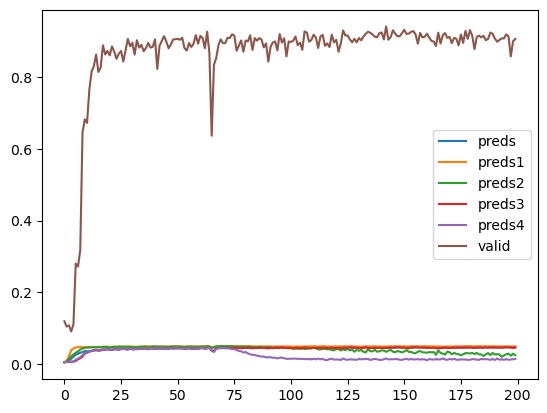

当前 [32, 0.0004, 10, 200, 25]

[0.9357854406130268, 0.9334865900383141, 0.9408429118773947]

0.9367049808429119

===

[0.9309152279239481, 0.9301678672677391, 0.9379722275973126]

0.9330184409296667

===

[0.9282247553401003, 0.9287534769377441, 0.9368645684396535]

0.9312809335724993

===

[0.9413786119527836, 0.9336335063684273, 0.9396250473626635]

0.9382123885612915

===


In [4]:
def _freeze_norm_stats(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
lr = 0.0001
batch_size = 8
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop((224,224), scale=(0.75, 1.0)),
        transforms.RandomRotation((-15,15)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(),
    ])
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

average_valid_results = []
average_f1_results = []
average_recall_results = []
average_precision_results = []

average_test_results = []
average_f1_results_test = []
average_recall_results_test = []
average_precision_results_test = []
for config in [[32,0.0004,10,200,25]]:
    
    alphas = [1,1,1]
    
    alpha1,alpha2,alpha3 = alphas
    average_valid_results = []
    average_f1_results = []
    average_recall_results = []
    average_precision_results = []

    average_test_results = []
    average_f1_results_test = []
    average_recall_results_test = []
    average_precision_results_test = []
    for seed in [2,1,0]:
        batch_size,lr,warmupepoch,epoch_num,select_batch_num = config
        alpha = 1
        
        lrcounter = 0
        seed4batch = seed
        T = 2
        cudnn.benchmark = False
        cudnn.deterministic = True
        torch.manual_seed(seed)  # 为CPU设置随机种子
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # 为所有GPU设置随机种子
        random.seed(seed)
        np.random.seed(seed)



        def get_num_correct(out, labels):  #求准确率
            return out.argmax(dim=1).eq(labels).sum().item()

        
        path = '../v8-baselines/best'+str(seed)+'.pkl'

        model_generator = MSFIN('').cuda()
        

        optimizer_generator = torch.optim.Adam(model_generator.parameters(),lr=lr)
        
        scheduler_warmup_generator = GradualWarmupScheduler(optimizer_generator, multiplier=1, total_epoch=warmupepoch)
        optimizer_generator.zero_grad()
        optimizer_generator.step()
        
        
        maxval=0
        maxtest_followmaxval=0
        maxf1_followmaxval = 0
        maxrecall_followmaxval = 0
        maxprecision_followmaxval = 0
        
        maxf1_followmaxval_test = 0
        maxrecall_followmaxval_test = 0
        maxprecision_followmaxval_test = 0
        
        
        finaltestlabel_followmaxval = []
        finaltestlabel_pred_followmaxval = []

        earlystopcounter = 0

        T = 10
        minvalidloss = 99999

        val_loss_curve = []
        val_acc_curve = []
        test_acc_curve = []
        
        train_acc_1 = []
        train_acc_2 = []
        train_acc_3 = []
        train_acc_4 = []
        train_acc_5 = []
        
        idxlist = [i for i in range(train_len)]
        
        flag1 = 0
        flag2 = 0
        warm_end = False
        for epoch in tqdm(range(1,epoch_num+1)):

            scheduler_warmup_generator.step()
            np.random.seed(seed)
            np.random.shuffle(idxlist)
            
            total_loss=0
            valid_loss = 0
            train_correct=0
            test_correct = 0
            val_correct=0
            model_generator.train()
            model_generator.apply(_freeze_norm_stats)

            
            train_counter = 0
            
            train_correct1 = 0
            train_correct2 = 0
            train_correct3 = 0
            train_correct4 = 0
            train_correct5 = 0
            
            def getBatch(len_dataset,batch_size):
                batch_num = len_dataset // batch_size
                batch_res = len_dataset % batch_size

                if batch_res>0:
                    batchlist = [batch_size] * batch_num + [batch_res]
                else:
                    batchlist = [batch_size] * batch_num
                return batchlist
            train_batch_list = getBatch(train_len,batch_size)
            
            for idx,b in enumerate(train_batch_list[:select_batch_num]):
                start = 0+sum(train_batch_list[:idx])
                end = 0+sum(train_batch_list[:idx+1])
                batchidxlist = idxlist[start:end]
                
            
                x = []
                y = []
                y2 = []
                for image_inbatch_id in batchidxlist:
                    d = trainset[image_inbatch_id]
                    x.append(train_transform(d[0]))
                    y.append(d[1])
                    y2.append(d[2])
                
                images = torch.stack(x,0).cuda()
                
                
                labels = torch.LongTensor(y).cuda()
                labels2 = torch.LongTensor(y2).cuda()
                
                
                one_hot_labels = F.one_hot(labels,10)
                one_hot_labels2 = F.one_hot(labels2,len_train_subs)
                fake_label = torch.ones_like(one_hot_labels).cuda()/10
                fake_label2 = torch.ones_like(one_hot_labels2).cuda()/len_train_subs


                optimizer_generator.zero_grad()

                preds,preds1,preds2,preds3,preds4 = model_generator(images,False)
                
                
                if warm_end:
                    loss = F.cross_entropy(preds,labels)

                    loss = loss + F.cross_entropy(preds1,labels2)
                    loss = loss + F.cross_entropy(preds3,labels)
                    loss = loss + F.kl_div(F.log_softmax(preds2,-1),fake_label2,reduction='batchmean')
                    loss = loss + F.kl_div(F.log_softmax(preds4,-1),fake_label,reduction='batchmean')

                else:
                    
                    loss = F.cross_entropy(preds,labels)

                    loss = loss + F.cross_entropy(preds1,labels2)
                    loss = loss + F.cross_entropy(preds3,labels)
                    
                loss.backward()
                optimizer_generator.step()

                total_loss+=loss.item()
                train_correct1+=get_num_correct(preds,labels)
                train_correct2+=get_num_correct(preds1,labels2)
                train_correct3+=get_num_correct(preds2,labels2)
                train_correct4+=get_num_correct(preds3,labels)
                train_correct5+=get_num_correct(preds4,labels)
            
            print('***训练集***')
            print('main branch：',train_correct1/select_batch_num/32)
            
            print('准确识别驾驶员：',train_correct2/select_batch_num/32)
            print('无法准确识别驾驶员：',train_correct3/select_batch_num/32)
            print('准确识别行为：',train_correct4/select_batch_num/32)
            print('无法准确识别行为：',train_correct5/select_batch_num/32)
            flag1 = train_correct2/select_batch_num/32
            flag2 = train_correct4/select_batch_num/32
            print('flag1',flag1,'flag2',flag2)
            if flag1 >= 0.9 and flag2 >= 0.9 and not warm_end:
                print('预热结束')
                warm_end = True
                optimizer_generator = torch.optim.Adam(model_generator.parameters(),lr=lr)
        
                scheduler_warmup_generator = GradualWarmupScheduler(optimizer_generator, multiplier=1, total_epoch=warmupepoch)
                optimizer_generator.zero_grad()
                optimizer_generator.step()

            
            valid_preds = []
            valid_labels = []
                
            model_generator.eval()
            with torch.no_grad():
                validxlist = [i for i in range(valid_len)]
                valid_batch_list = getBatch(valid_len,batch_size)
                
                for idx,b in enumerate(valid_batch_list):
                    start = 0+sum(valid_batch_list[:idx])
                    end = 0+sum(valid_batch_list[:idx+1])
                    batchidxlist = validxlist[start:end]

                    x = []
                    y = []
                    y2 = []
                    for image_inbatch_id in batchidxlist:
                        #im_o = 
                        d = validset[image_inbatch_id]
                        #print()
                        x.append(test_transform(d[0]))
                        y.append(d[1])
                        y2.append(d[2])

                    images = torch.stack(x,0).cuda()
                    labels = torch.LongTensor(y).cuda()
                    

                    _,_,_,preds,_ = model_generator(images)

                    loss = F.cross_entropy(preds,labels)
                    
                    valid_loss+=loss.item()
                    val_correct+=get_num_correct(preds,labels)
                    
                    valid_preds += preds.argmax(-1).cpu().numpy().tolist()
                    valid_labels += y
            
            F1=f1_score(valid_labels,valid_preds,average="macro")
            print("valid-f1:",F1)
            precision=precision_score(valid_labels,valid_preds,average="macro")
            print("valid-precision:",precision)
            recall=recall_score(valid_labels,valid_preds,average="macro")
            print("valid-recall:",recall)
            
            print('process:',epoch," loss:",total_loss," train_correct:",train_correct/train_len,'valid_loss',valid_loss," val_correct:",val_correct/valid_len)
            train_acc = train_correct/train_len
            val_acc=val_correct/valid_len
            
            train_acc_1.append(train_correct1/train_all)
            train_acc_2.append(train_correct2/train_all)
            train_acc_3.append(train_correct3/train_all)
            train_acc_4.append(train_correct4/train_all)
            train_acc_5.append(train_correct5/train_all)
            val_loss_curve.append(valid_loss)
            val_acc_curve.append(val_acc)
            
            
            if val_acc > maxval:
                
                maxval = val_acc
                maxf1_followmaxval = F1
                maxrecall_followmaxval = recall
                maxprecision_followmaxval = precision

                
                earlystopcounter = 0
                torch.save(model_generator.state_dict(), 'best'+str(seed)+'.pkl')
                print('The model has been saved!!')
                print('The best val_acc is ',maxval)
            
        x = range(len(val_loss_curve))


        plt.figure()
        
        plt.plot(x, train_acc_1,label = 'preds')
        plt.plot(x, train_acc_2,label = 'preds1')
        plt.plot(x, train_acc_3,label = 'preds2')
        plt.plot(x, train_acc_4,label = 'preds3')
        plt.plot(x, train_acc_5,label = 'preds4')

        plt.plot(x, val_acc_curve,label = 'valid')

        plt.legend()
        plt.show()
        average_valid_results.append(maxval)
        average_f1_results.append(maxf1_followmaxval)
        average_recall_results.append(maxrecall_followmaxval)
        average_precision_results.append(maxprecision_followmaxval)

    def summary(average_valid_results):
        print(average_valid_results)
        print(sum(average_valid_results)/len(average_valid_results))
        print('===')

    print('当前',config)
    summary(average_valid_results)
    summary(average_f1_results)
    summary(average_recall_results)
    summary(average_precision_results)

